In [8]:
import numpy as np

class DenseLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.zeros((1, output_dim))
        self.input = None
        self.d_weights = None
        self.d_bias = None  

    def forward(self, X):
        self.input = X
        return np.dot(X, self.weights) + self.bias

    def backward(self, d_out, learning_rate):
        self.d_weights = np.dot(self.input.T, d_out)
        self.d_bias = np.sum(d_out, axis=0, keepdims=True)
        d_input = np.dot(d_out, self.weights.T)
        return d_input

In [9]:
class ReLU:
    def forward(self, X):
        self.input = X
        return np.maximum(0, X)

    def backward(self, d_out):
        return d_out * (self.input > 0)

In [10]:
class BatchNormalization:
    def __init__(self, dim, epsilon=1e-5, momentum=0.9):
        self.gamma = np.ones(dim)
        self.beta = np.zeros(dim)
        self.epsilon = epsilon
        self.momentum = momentum
        self.running_mean = np.zeros(dim)
        self.running_var = np.zeros(dim)
        self.input = None

    def forward(self, X, training=True):
        if training:
            self.mean = np.mean(X, axis=0)
            self.var = np.var(X, axis=0)
            self.input = X

            self.X_norm = (X - self.mean) / np.sqrt(self.var + self.epsilon)
            out = self.gamma * self.X_norm + self.beta

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            out = self.gamma * X_norm + self.beta
        
        return out

    def backward(self, d_out, learning_rate):
        N, D = d_out.shape

        X_mu = self.input - self.mean
        std_inv = 1. / np.sqrt(self.var + self.epsilon)

        dX_norm = d_out * self.gamma
        dvar = np.sum(dX_norm * X_mu, axis=0) * -0.5 * std_inv**3
        dmean = np.sum(dX_norm * -std_inv, axis=0) + dvar * np.mean(-2. * X_mu, axis=0)

        dX = (dX_norm * std_inv) + (dvar * 2 * X_mu / N) + (dmean / N)
        self.gamma -= learning_rate * np.sum(d_out * self.X_norm, axis=0)
        self.beta -= learning_rate * np.sum(d_out, axis=0)
        
        return dX


In [11]:
class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate

    def forward(self, X, training=True):
        if training:
            self.mask = np.random.rand(*X.shape) > self.dropout_rate
            return X * self.mask / (1 - self.dropout_rate)
        else:
            return X

    def backward(self, d_out):
        return d_out * self.mask / (1 - self.dropout_rate)


In [12]:
class AdamOptimizer:
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, params, grads):
        self.t += 1
        updated_params = {}

        for key in params:
            if key not in self.m:
                self.m[key] = [np.zeros_like(grads[key][0]),np.zeros_like(grads[key][1])]
                self.v[key] = [np.zeros_like(grads[key][0]),np.zeros_like(grads[key][1])]

            self.m[key][0] = self.beta1 * self.m[key][0] + (1 - self.beta1) * grads[key][0]
            self.m[key][1] = self.beta1 * self.m[key][1] + (1 - self.beta1) * grads[key][1]

            self.v[key][0] = self.beta2 * self.v[key][0] + (1 - self.beta2) * (grads[key][0] ** 2)
            self.v[key][1] = self.beta2 * self.v[key][1] + (1 - self.beta2) * (grads[key][1] ** 2)

            m_hat_weights = self.m[key][0] / (1 - self.beta1 ** self.t)
            m_hat_bias = self.m[key][1] / (1 - self.beta1 ** self.t)
            v_hat_weights = self.v[key][0] / (1 - self.beta2 ** self.t)
            v_hat_bias = self.v[key][1] / (1 - self.beta2 ** self.t)

            updated_params[key] =[params[key][0] - self.learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + self.epsilon),
                                    params[key][1] - self.learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + self.epsilon)]

        return updated_params



In [13]:
class Softmax:
    def forward(self, X):
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output

    def backward(self, d_out):
        return self.output * (d_out - np.sum(d_out * self.output, axis=1, keepdims=True))


In [14]:
class FeedForwardNeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        self.layers = []
        
        # Adding first Dense layer
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(DenseLayer(prev_dim, hidden_dim))
            self.layers.append(BatchNormalization(hidden_dim))
            self.layers.append(ReLU())
            self.layers.append(Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Adding final Dense layer
        self.layers.append(DenseLayer(prev_dim, output_dim))
        self.layers.append(Softmax())

    def forward(self, X, training=True):
        # Forward pass through all layers
        for layer in self.layers:
            if isinstance(layer, (Dropout,BatchNormalization)):
                X = layer.forward(X, training)
            else:
                X = layer.forward(X)
        return X

    def backward(self, d_out, learning_rate):
        # Backward pass through all layers in reverse order
        for layer in reversed(self.layers):
            if isinstance(layer, (DenseLayer, BatchNormalization)):
                d_out = layer.backward(d_out, learning_rate)
            elif isinstance(layer, (ReLU, Dropout, Softmax)):
                d_out = layer.backward(d_out)

    def update_params(self, adam_optimizer):
        # Parameter and gradient dicts
        params = {}
        grads = {}
        
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                params[id(layer)] = [layer.weights,layer.bias]
                grads[id(layer)] = [layer.d_weights,layer.d_bias]
        
        # Updating parameters using Adam optimizer
        updated_params = adam_optimizer.update(params, grads)

        # Updating the layers with the new parameters
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                layer.weights = updated_params[id(layer)][0]
                layer.bias = updated_params[id(layer)][1]


Data Import

In [15]:
from torchvision import datasets, transforms

# Define transformation
transform = transforms.ToTensor()

# Load the training dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Load the test dataset separately
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

Model Training Function

In [16]:
import tqdm
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
np.random.seed(42)

class Model:
    def __init__(self,input_dim,hidden_dims,output_dim,dropout_rate,learning_rate,batch_size,num_epochs,ratio):
        # Hyperparameters
        self.input_dim = input_dim 
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim 
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.batch_size = batch_size 
        self.num_epochs = num_epochs
        self.ratio = ratio

        # Initialize the fnn
        self.fnn = FeedForwardNeuralNetwork(self.input_dim, self.hidden_dims, self.output_dim, self.dropout_rate)
        self.adam_optimizer = AdamOptimizer(self.learning_rate)

    def fit(self,dataset,history,train):

        # Split the dataset for training and validation
        train_size = int(self.ratio * len(dataset)) 
        val_size = len(dataset) - train_size
        train_subset, val_subset = random_split(dataset, [train_size, val_size])

        # Create DataLoaders for training and validation subsets
        if train:
            train_loader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=self.batch_size, shuffle=False)
        else:
            train_loader = dataset

        # Training loop
        print(self.num_epochs)
        for epoch in range(self.num_epochs):
            epoch_loss = 0
            correct = 0
            total = 0

            for images, labels in tqdm.tqdm(train_loader):
                # Flatten images
                images = images.view(-1, 28 * 28).numpy()
                
                # Forward pass
                outputs = self.fnn.forward(images, training=True)
                
                # One-hot encoding for labels
                one_hot_labels = np.eye(self.output_dim)[labels.numpy()]

                # Compute loss (cross-entropy loss)
                loss = -np.sum(one_hot_labels * np.log(outputs + 1e-8)) / len(labels)
                epoch_loss += loss

                # Backward pass
                d_out = outputs - np.eye(self.output_dim)[labels.numpy()]
                self.fnn.backward(d_out, self.learning_rate)

                # Update parameters
                self.fnn.update_params(self.adam_optimizer)

                # Calculate accuracy
                predictions = np.argmax(outputs, axis=1)
                correct += (predictions == labels.numpy()).sum()
                total += labels.size(0)

            train_accuracy = correct / total
            history['train_loss'].append(epoch_loss / len(train_loader))
            history['train_acc'].append(train_accuracy)

            # Display epoch results
            print("total: ",total,"correct: ",correct)
            epoch_accuracy = correct / total
            print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss/ len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}')


            # Testing phase
            all_predictions = []
            all_true_labels = []

            correct = 0
            total = 0
            epoch_loss = 0
            
            if train:
                for images, labels in val_loader:
                    # Flatten images
                    images = images.view(-1, 28 * 28).numpy()

                    # Forward pass (inference mode)
                    outputs = self.fnn.forward(images, training=False)
                    predictions = np.argmax(outputs, axis=1)

                    # One-hot encoding for labels
                    one_hot_labels = np.eye(self.output_dim)[labels.numpy()]

                    # Compute loss (cross-entropy loss)
                    loss = -np.sum(one_hot_labels * np.log(outputs + 1e-8)) / len(labels)
                    #print(len(labels))
                    epoch_loss += loss

                    # Collect results
                    all_predictions.extend(predictions)
                    all_true_labels.extend(labels.numpy())

                    # Calculate accuracy
                    correct += (predictions == labels.numpy()).sum()
                    total += labels.size(0)
                    
                if epoch == self.num_epochs - 1:
                    conf_matrix = confusion_matrix(all_true_labels, all_predictions)
                    print("Confusion Matrix:")
                    print(conf_matrix)
                    history['confusion_mat'].append(conf_matrix)

            if train:
                # Calculate accuracy using sklearn
                accuracy = accuracy_score(all_true_labels, all_predictions)
                print(f'Validation Accuracy: {accuracy:.4f}')

                val_accuracy = correct / total
                val_f1 = f1_score(all_true_labels, all_predictions, average='macro')
                val_loss = epoch_loss / len(val_loader)
                history['val_loss'].append(val_loss)
                print(f'Validation loss: {val_loss:.4f}')
                history['val_acc'].append(val_accuracy)
                history['val_f1'].append(val_f1)
                print(f'Validation Macro F1: {val_f1:.4f}')

        return self.fnn

Testing Function

In [17]:
def Test(model,data):
    all_predictions = []
    all_labels = []
    for images, labels in data:
        # Flatten the images
        images = images.view(images.size(0), -1).numpy()

        # Forward pass through the loaded model
        outputs = model.forward(images)

        # Get the predicted class (highest probability)
        predictions = np.argmax(outputs, axis=1)

        # Collect predictions and true labels for accuracy computation
        all_predictions.extend(predictions)
        all_labels.extend(labels.numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Step 4: Evaluate the model
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Hyperparamers

In [18]:
input_dim = 28 * 28  # Image size (28x28)
output_dim = 10  # Number of classes (0-9)
dropout_rate = 0.2
batch_size = 64
num_epochs = 40
data_split_ratio = 0.8

hidden_dims = [[512,256,128,64],[512,256,128],[512,256],[256,128],]  # Hidden layers
learning_rates = [0.005,0.001,0.0005,0.0001]

histories = []
models = []

All Model Runner

In [12]:
for hidden_dim in hidden_dims:
    for learning_rate in learning_rates:
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': [], 'model_info':[],'confusion_mat':[]}
        history['model_info'].append(hidden_dim)
        history['model_info'].append(learning_rate)
        model_current = Model(input_dim,hidden_dim,output_dim,dropout_rate,learning_rate,batch_size,num_epochs,data_split_ratio)
        model = model_current.fit(train_dataset,history,train=True)
        histories.append(history)
        models.append(model)
        
 

40


100%|██████████| 750/750 [00:35<00:00, 21.16it/s]


total:  48000 correct:  37751
Epoch [1/40], Loss: 0.6533, Accuracy: 0.7865
Validation Accuracy: 0.8425
Validation loss: 0.4576
Validation Macro F1: 0.8418


100%|██████████| 750/750 [00:35<00:00, 20.96it/s]


total:  48000 correct:  40449
Epoch [2/40], Loss: 0.4871, Accuracy: 0.8427
Validation Accuracy: 0.8527
Validation loss: 0.4379
Validation Macro F1: 0.8486


100%|██████████| 750/750 [00:36<00:00, 20.45it/s]


total:  48000 correct:  41174
Epoch [3/40], Loss: 0.4394, Accuracy: 0.8578
Validation Accuracy: 0.8666
Validation loss: 0.3967
Validation Macro F1: 0.8658


100%|██████████| 750/750 [00:38<00:00, 19.36it/s]


total:  48000 correct:  41412
Epoch [4/40], Loss: 0.4194, Accuracy: 0.8628
Validation Accuracy: 0.8607
Validation loss: 0.4102
Validation Macro F1: 0.8557


100%|██████████| 750/750 [00:34<00:00, 21.73it/s]


total:  48000 correct:  41785
Epoch [5/40], Loss: 0.3981, Accuracy: 0.8705
Validation Accuracy: 0.8662
Validation loss: 0.4115
Validation Macro F1: 0.8688


100%|██████████| 750/750 [00:34<00:00, 21.55it/s]


total:  48000 correct:  42025
Epoch [6/40], Loss: 0.3849, Accuracy: 0.8755
Validation Accuracy: 0.8753
Validation loss: 0.3703
Validation Macro F1: 0.8747


100%|██████████| 750/750 [00:35<00:00, 21.31it/s]


total:  48000 correct:  42262
Epoch [7/40], Loss: 0.3728, Accuracy: 0.8805
Validation Accuracy: 0.8764
Validation loss: 0.3683
Validation Macro F1: 0.8764


100%|██████████| 750/750 [00:34<00:00, 21.90it/s]


total:  48000 correct:  42447
Epoch [8/40], Loss: 0.3581, Accuracy: 0.8843
Validation Accuracy: 0.8818
Validation loss: 0.3548
Validation Macro F1: 0.8826


100%|██████████| 750/750 [00:34<00:00, 21.95it/s]


total:  48000 correct:  42633
Epoch [9/40], Loss: 0.3493, Accuracy: 0.8882
Validation Accuracy: 0.8646
Validation loss: 0.3976
Validation Macro F1: 0.8652


100%|██████████| 750/750 [00:34<00:00, 21.86it/s]


total:  48000 correct:  42722
Epoch [10/40], Loss: 0.3427, Accuracy: 0.8900
Validation Accuracy: 0.8786
Validation loss: 0.3551
Validation Macro F1: 0.8756


100%|██████████| 750/750 [00:34<00:00, 21.78it/s]


total:  48000 correct:  42838
Epoch [11/40], Loss: 0.3353, Accuracy: 0.8925
Validation Accuracy: 0.8851
Validation loss: 0.3358
Validation Macro F1: 0.8853


100%|██████████| 750/750 [00:34<00:00, 21.96it/s]


total:  48000 correct:  43069
Epoch [12/40], Loss: 0.3253, Accuracy: 0.8973
Validation Accuracy: 0.8820
Validation loss: 0.3544
Validation Macro F1: 0.8810


100%|██████████| 750/750 [00:36<00:00, 20.54it/s]


total:  48000 correct:  43104
Epoch [13/40], Loss: 0.3241, Accuracy: 0.8980
Validation Accuracy: 0.8862
Validation loss: 0.3501
Validation Macro F1: 0.8856


100%|██████████| 750/750 [00:35<00:00, 20.88it/s]


total:  48000 correct:  43149
Epoch [14/40], Loss: 0.3191, Accuracy: 0.8989
Validation Accuracy: 0.8875
Validation loss: 0.3530
Validation Macro F1: 0.8871


100%|██████████| 750/750 [00:34<00:00, 21.55it/s]


total:  48000 correct:  43354
Epoch [15/40], Loss: 0.3100, Accuracy: 0.9032
Validation Accuracy: 0.8843
Validation loss: 0.3490
Validation Macro F1: 0.8833


100%|██████████| 750/750 [00:33<00:00, 22.20it/s]


total:  48000 correct:  43437
Epoch [16/40], Loss: 0.2993, Accuracy: 0.9049
Validation Accuracy: 0.8855
Validation loss: 0.3522
Validation Macro F1: 0.8842


100%|██████████| 750/750 [00:33<00:00, 22.18it/s]


total:  48000 correct:  43563
Epoch [17/40], Loss: 0.2980, Accuracy: 0.9076
Validation Accuracy: 0.8880
Validation loss: 0.3450
Validation Macro F1: 0.8878


100%|██████████| 750/750 [00:33<00:00, 22.22it/s]


total:  48000 correct:  43641
Epoch [18/40], Loss: 0.2951, Accuracy: 0.9092
Validation Accuracy: 0.8844
Validation loss: 0.3522
Validation Macro F1: 0.8830


100%|██████████| 750/750 [00:33<00:00, 22.14it/s]


total:  48000 correct:  43772
Epoch [19/40], Loss: 0.2875, Accuracy: 0.9119
Validation Accuracy: 0.8874
Validation loss: 0.3598
Validation Macro F1: 0.8881


100%|██████████| 750/750 [00:33<00:00, 22.06it/s]


total:  48000 correct:  43839
Epoch [20/40], Loss: 0.2860, Accuracy: 0.9133
Validation Accuracy: 0.8921
Validation loss: 0.3302
Validation Macro F1: 0.8918


100%|██████████| 750/750 [00:33<00:00, 22.15it/s]


total:  48000 correct:  43794
Epoch [21/40], Loss: 0.2837, Accuracy: 0.9124
Validation Accuracy: 0.8932
Validation loss: 0.3368
Validation Macro F1: 0.8927


100%|██████████| 750/750 [00:33<00:00, 22.16it/s]


total:  48000 correct:  43947
Epoch [22/40], Loss: 0.2744, Accuracy: 0.9156
Validation Accuracy: 0.8932
Validation loss: 0.3239
Validation Macro F1: 0.8927


100%|██████████| 750/750 [00:34<00:00, 21.81it/s]


total:  48000 correct:  44035
Epoch [23/40], Loss: 0.2694, Accuracy: 0.9174
Validation Accuracy: 0.8975
Validation loss: 0.3235
Validation Macro F1: 0.8978


100%|██████████| 750/750 [00:34<00:00, 21.87it/s]


total:  48000 correct:  44077
Epoch [24/40], Loss: 0.2655, Accuracy: 0.9183
Validation Accuracy: 0.8948
Validation loss: 0.3275
Validation Macro F1: 0.8950


100%|██████████| 750/750 [00:35<00:00, 21.29it/s]


total:  48000 correct:  44227
Epoch [25/40], Loss: 0.2636, Accuracy: 0.9214
Validation Accuracy: 0.8942
Validation loss: 0.3342
Validation Macro F1: 0.8937


100%|██████████| 750/750 [00:34<00:00, 21.52it/s]


total:  48000 correct:  44210
Epoch [26/40], Loss: 0.2590, Accuracy: 0.9210
Validation Accuracy: 0.8928
Validation loss: 0.3368
Validation Macro F1: 0.8918


100%|██████████| 750/750 [00:41<00:00, 17.87it/s]


total:  48000 correct:  44335
Epoch [27/40], Loss: 0.2557, Accuracy: 0.9236
Validation Accuracy: 0.8918
Validation loss: 0.3499
Validation Macro F1: 0.8915


100%|██████████| 750/750 [00:46<00:00, 16.02it/s]


total:  48000 correct:  44464
Epoch [28/40], Loss: 0.2469, Accuracy: 0.9263
Validation Accuracy: 0.8776
Validation loss: 0.4182
Validation Macro F1: 0.8777


100%|██████████| 750/750 [00:41<00:00, 18.05it/s]


total:  48000 correct:  44417
Epoch [29/40], Loss: 0.2448, Accuracy: 0.9254
Validation Accuracy: 0.8918
Validation loss: 0.3366
Validation Macro F1: 0.8922


100%|██████████| 750/750 [00:46<00:00, 16.30it/s]


total:  48000 correct:  44474
Epoch [30/40], Loss: 0.2480, Accuracy: 0.9265
Validation Accuracy: 0.8992
Validation loss: 0.3335
Validation Macro F1: 0.8994


100%|██████████| 750/750 [00:46<00:00, 16.28it/s]


total:  48000 correct:  44610
Epoch [31/40], Loss: 0.2364, Accuracy: 0.9294
Validation Accuracy: 0.9021
Validation loss: 0.3268
Validation Macro F1: 0.9015


100%|██████████| 750/750 [00:47<00:00, 15.71it/s]


total:  48000 correct:  44582
Epoch [32/40], Loss: 0.2406, Accuracy: 0.9288
Validation Accuracy: 0.8949
Validation loss: 0.3477
Validation Macro F1: 0.8946


100%|██████████| 750/750 [00:39<00:00, 19.17it/s]


total:  48000 correct:  44652
Epoch [33/40], Loss: 0.2338, Accuracy: 0.9303
Validation Accuracy: 0.8921
Validation loss: 0.3568
Validation Macro F1: 0.8896


100%|██████████| 750/750 [00:34<00:00, 21.68it/s]


total:  48000 correct:  44721
Epoch [34/40], Loss: 0.2312, Accuracy: 0.9317
Validation Accuracy: 0.8977
Validation loss: 0.3387
Validation Macro F1: 0.8967


100%|██████████| 750/750 [00:33<00:00, 22.20it/s]


total:  48000 correct:  44819
Epoch [35/40], Loss: 0.2249, Accuracy: 0.9337
Validation Accuracy: 0.8963
Validation loss: 0.3392
Validation Macro F1: 0.8953


100%|██████████| 750/750 [00:33<00:00, 22.21it/s]


total:  48000 correct:  44839
Epoch [36/40], Loss: 0.2267, Accuracy: 0.9341
Validation Accuracy: 0.8922
Validation loss: 0.3528
Validation Macro F1: 0.8920


100%|██████████| 750/750 [00:48<00:00, 15.57it/s]


total:  48000 correct:  44876
Epoch [37/40], Loss: 0.2239, Accuracy: 0.9349
Validation Accuracy: 0.8983
Validation loss: 0.3551
Validation Macro F1: 0.8976


100%|██████████| 750/750 [00:45<00:00, 16.57it/s]


total:  48000 correct:  44948
Epoch [38/40], Loss: 0.2199, Accuracy: 0.9364
Validation Accuracy: 0.8880
Validation loss: 0.3841
Validation Macro F1: 0.8852


100%|██████████| 750/750 [00:37<00:00, 20.23it/s]


total:  48000 correct:  44991
Epoch [39/40], Loss: 0.2161, Accuracy: 0.9373
Validation Accuracy: 0.9000
Validation loss: 0.3436
Validation Macro F1: 0.8992


100%|██████████| 750/750 [00:46<00:00, 16.12it/s]


total:  48000 correct:  45068
Epoch [40/40], Loss: 0.2174, Accuracy: 0.9389
Confusion Matrix:
[[ 922    0   24   36    0    2  181    0    5    0]
 [   0 1184    0   19    2    0    1    0    0    0]
 [  11    0 1001    8   62    0   76    1    2    0]
 [  16    3    6 1197   34    1   27    0    2    0]
 [   2    2  111   39  976    0   75    0    2    0]
 [   0    0    0    0    0 1128    1   20    2   19]
 [  91    3  107   22   51    0  938    0    8    0]
 [   0    0    0    0    0   12    0 1106    1   45]
 [  10    2    3    5    5    3   10    5 1160    0]
 [   0    0    0    0    0    7    0   33    0 1173]]
Validation Accuracy: 0.8988
Validation loss: 0.3324
Validation Macro F1: 0.8991
40


100%|██████████| 750/750 [00:46<00:00, 16.28it/s]


total:  48000 correct:  37781
Epoch [1/40], Loss: 0.7250, Accuracy: 0.7871
Validation Accuracy: 0.8465
Validation loss: 0.4711
Validation Macro F1: 0.8450


100%|██████████| 750/750 [00:40<00:00, 18.60it/s]


total:  48000 correct:  40558
Epoch [2/40], Loss: 0.4858, Accuracy: 0.8450
Validation Accuracy: 0.8628
Validation loss: 0.3999
Validation Macro F1: 0.8604


100%|██████████| 750/750 [00:45<00:00, 16.46it/s]


total:  48000 correct:  41240
Epoch [3/40], Loss: 0.4350, Accuracy: 0.8592
Validation Accuracy: 0.8750
Validation loss: 0.3665
Validation Macro F1: 0.8727


100%|██████████| 750/750 [00:46<00:00, 16.23it/s]


total:  48000 correct:  41725
Epoch [4/40], Loss: 0.4051, Accuracy: 0.8693
Validation Accuracy: 0.8775
Validation loss: 0.3484
Validation Macro F1: 0.8768


100%|██████████| 750/750 [00:44<00:00, 17.01it/s]


total:  48000 correct:  41955
Epoch [5/40], Loss: 0.3861, Accuracy: 0.8741
Validation Accuracy: 0.8806
Validation loss: 0.3490
Validation Macro F1: 0.8786


100%|██████████| 750/750 [00:50<00:00, 14.90it/s]


total:  48000 correct:  42223
Epoch [6/40], Loss: 0.3768, Accuracy: 0.8796
Validation Accuracy: 0.8866
Validation loss: 0.3358
Validation Macro F1: 0.8850


100%|██████████| 750/750 [00:50<00:00, 14.81it/s]


total:  48000 correct:  42435
Epoch [7/40], Loss: 0.3597, Accuracy: 0.8841
Validation Accuracy: 0.8797
Validation loss: 0.3418
Validation Macro F1: 0.8796


100%|██████████| 750/750 [00:39<00:00, 19.07it/s]


total:  48000 correct:  42617
Epoch [8/40], Loss: 0.3466, Accuracy: 0.8879
Validation Accuracy: 0.8872
Validation loss: 0.3233
Validation Macro F1: 0.8872


100%|██████████| 750/750 [00:33<00:00, 22.35it/s]


total:  48000 correct:  42725
Epoch [9/40], Loss: 0.3435, Accuracy: 0.8901
Validation Accuracy: 0.8860
Validation loss: 0.3368
Validation Macro F1: 0.8830


100%|██████████| 750/750 [00:34<00:00, 21.86it/s]


total:  48000 correct:  42833
Epoch [10/40], Loss: 0.3299, Accuracy: 0.8924
Validation Accuracy: 0.8831
Validation loss: 0.3373
Validation Macro F1: 0.8783


100%|██████████| 750/750 [00:45<00:00, 16.39it/s]


total:  48000 correct:  43002
Epoch [11/40], Loss: 0.3238, Accuracy: 0.8959
Validation Accuracy: 0.8894
Validation loss: 0.3286
Validation Macro F1: 0.8873


100%|██████████| 750/750 [00:44<00:00, 16.93it/s]


total:  48000 correct:  43116
Epoch [12/40], Loss: 0.3175, Accuracy: 0.8982
Validation Accuracy: 0.8899
Validation loss: 0.3224
Validation Macro F1: 0.8884


100%|██████████| 750/750 [00:34<00:00, 21.50it/s]


total:  48000 correct:  43251
Epoch [13/40], Loss: 0.3112, Accuracy: 0.9011
Validation Accuracy: 0.8932
Validation loss: 0.3170
Validation Macro F1: 0.8915


100%|██████████| 750/750 [00:36<00:00, 20.48it/s]


total:  48000 correct:  43424
Epoch [14/40], Loss: 0.3004, Accuracy: 0.9047
Validation Accuracy: 0.8886
Validation loss: 0.3211
Validation Macro F1: 0.8889


100%|██████████| 750/750 [00:34<00:00, 21.58it/s]


total:  48000 correct:  43494
Epoch [15/40], Loss: 0.2946, Accuracy: 0.9061
Validation Accuracy: 0.8953
Validation loss: 0.3132
Validation Macro F1: 0.8933


100%|██████████| 750/750 [00:31<00:00, 23.81it/s]


total:  48000 correct:  43608
Epoch [16/40], Loss: 0.2894, Accuracy: 0.9085
Validation Accuracy: 0.8892
Validation loss: 0.3220
Validation Macro F1: 0.8882


100%|██████████| 750/750 [00:32<00:00, 23.35it/s]


total:  48000 correct:  43649
Epoch [17/40], Loss: 0.2853, Accuracy: 0.9094
Validation Accuracy: 0.8963
Validation loss: 0.3008
Validation Macro F1: 0.8948


100%|██████████| 750/750 [00:31<00:00, 23.44it/s]


total:  48000 correct:  43761
Epoch [18/40], Loss: 0.2794, Accuracy: 0.9117
Validation Accuracy: 0.8811
Validation loss: 0.3513
Validation Macro F1: 0.8799


100%|██████████| 750/750 [00:31<00:00, 23.48it/s]


total:  48000 correct:  43837
Epoch [19/40], Loss: 0.2742, Accuracy: 0.9133
Validation Accuracy: 0.8973
Validation loss: 0.3111
Validation Macro F1: 0.8950


100%|██████████| 750/750 [00:31<00:00, 23.57it/s]


total:  48000 correct:  43892
Epoch [20/40], Loss: 0.2730, Accuracy: 0.9144
Validation Accuracy: 0.8895
Validation loss: 0.3307
Validation Macro F1: 0.8884


100%|██████████| 750/750 [00:32<00:00, 23.37it/s]


total:  48000 correct:  44036
Epoch [21/40], Loss: 0.2648, Accuracy: 0.9174
Validation Accuracy: 0.8929
Validation loss: 0.3156
Validation Macro F1: 0.8930


100%|██████████| 750/750 [00:31<00:00, 23.62it/s]


total:  48000 correct:  44068
Epoch [22/40], Loss: 0.2617, Accuracy: 0.9181
Validation Accuracy: 0.8995
Validation loss: 0.3014
Validation Macro F1: 0.8990


100%|██████████| 750/750 [00:32<00:00, 23.39it/s]


total:  48000 correct:  44141
Epoch [23/40], Loss: 0.2588, Accuracy: 0.9196
Validation Accuracy: 0.8967
Validation loss: 0.3134
Validation Macro F1: 0.8957


100%|██████████| 750/750 [00:32<00:00, 23.28it/s]


total:  48000 correct:  44185
Epoch [24/40], Loss: 0.2560, Accuracy: 0.9205
Validation Accuracy: 0.8847
Validation loss: 0.3441
Validation Macro F1: 0.8852


100%|██████████| 750/750 [00:31<00:00, 23.68it/s]


total:  48000 correct:  44263
Epoch [25/40], Loss: 0.2527, Accuracy: 0.9221
Validation Accuracy: 0.8893
Validation loss: 0.3324
Validation Macro F1: 0.8879


100%|██████████| 750/750 [00:31<00:00, 24.06it/s]


total:  48000 correct:  44358
Epoch [26/40], Loss: 0.2491, Accuracy: 0.9241
Validation Accuracy: 0.8936
Validation loss: 0.3237
Validation Macro F1: 0.8923


100%|██████████| 750/750 [00:31<00:00, 23.90it/s]


total:  48000 correct:  44419
Epoch [27/40], Loss: 0.2430, Accuracy: 0.9254
Validation Accuracy: 0.8998
Validation loss: 0.3132
Validation Macro F1: 0.8980


100%|██████████| 750/750 [00:31<00:00, 23.75it/s]


total:  48000 correct:  44502
Epoch [28/40], Loss: 0.2413, Accuracy: 0.9271
Validation Accuracy: 0.9008
Validation loss: 0.3119
Validation Macro F1: 0.8985


100%|██████████| 750/750 [00:31<00:00, 23.84it/s]


total:  48000 correct:  44519
Epoch [29/40], Loss: 0.2380, Accuracy: 0.9275
Validation Accuracy: 0.8979
Validation loss: 0.3269
Validation Macro F1: 0.8970


100%|██████████| 750/750 [00:31<00:00, 23.86it/s]


total:  48000 correct:  44637
Epoch [30/40], Loss: 0.2325, Accuracy: 0.9299
Validation Accuracy: 0.8982
Validation loss: 0.3047
Validation Macro F1: 0.8969


100%|██████████| 750/750 [00:30<00:00, 24.41it/s]


total:  48000 correct:  44587
Epoch [31/40], Loss: 0.2345, Accuracy: 0.9289
Validation Accuracy: 0.8967
Validation loss: 0.3247
Validation Macro F1: 0.8960


100%|██████████| 750/750 [00:31<00:00, 23.79it/s]


total:  48000 correct:  44763
Epoch [32/40], Loss: 0.2300, Accuracy: 0.9326
Validation Accuracy: 0.9002
Validation loss: 0.3114
Validation Macro F1: 0.8984


100%|██████████| 750/750 [00:31<00:00, 23.81it/s]


total:  48000 correct:  44686
Epoch [33/40], Loss: 0.2305, Accuracy: 0.9310
Validation Accuracy: 0.9002
Validation loss: 0.3180
Validation Macro F1: 0.8985


100%|██████████| 750/750 [00:31<00:00, 24.03it/s]


total:  48000 correct:  44775
Epoch [34/40], Loss: 0.2281, Accuracy: 0.9328
Validation Accuracy: 0.8950
Validation loss: 0.3301
Validation Macro F1: 0.8940


100%|██████████| 750/750 [00:30<00:00, 24.53it/s]


total:  48000 correct:  44816
Epoch [35/40], Loss: 0.2231, Accuracy: 0.9337
Validation Accuracy: 0.9007
Validation loss: 0.3135
Validation Macro F1: 0.8993


100%|██████████| 750/750 [00:31<00:00, 23.90it/s]


total:  48000 correct:  44849
Epoch [36/40], Loss: 0.2204, Accuracy: 0.9344
Validation Accuracy: 0.9006
Validation loss: 0.3222
Validation Macro F1: 0.8994


100%|██████████| 750/750 [00:31<00:00, 24.00it/s]


total:  48000 correct:  44847
Epoch [37/40], Loss: 0.2209, Accuracy: 0.9343
Validation Accuracy: 0.8992
Validation loss: 0.3146
Validation Macro F1: 0.8985


100%|██████████| 750/750 [00:31<00:00, 23.69it/s]


total:  48000 correct:  44991
Epoch [38/40], Loss: 0.2109, Accuracy: 0.9373
Validation Accuracy: 0.9019
Validation loss: 0.3165
Validation Macro F1: 0.8996


100%|██████████| 750/750 [00:31<00:00, 24.01it/s]


total:  48000 correct:  45029
Epoch [39/40], Loss: 0.2111, Accuracy: 0.9381
Validation Accuracy: 0.8942
Validation loss: 0.3295
Validation Macro F1: 0.8933


100%|██████████| 750/750 [00:31<00:00, 23.83it/s]


total:  48000 correct:  45016
Epoch [40/40], Loss: 0.2078, Accuracy: 0.9378
Confusion Matrix:
[[1041    0   11   45    3    0   68    0    2    1]
 [   1 1181    1   28    3    0    1    0    2    0]
 [  32    1 1000   17   74    1   70    0    4    0]
 [  15    8    2 1080   37    0   18    0    2    0]
 [   1    2   86   45  982    0   53    0    3    0]
 [   0    1    0    0    0 1221    0   34    5    6]
 [ 161    2   78   23   82    0  819    0    8    0]
 [   0    0    0    0    0   19    0 1164    3   15]
 [   6    0    3    5    0    5    5    3 1157    0]
 [   0    1    0    1    0   12    0   73    1 1166]]
Validation Accuracy: 0.9009
Validation loss: 0.3121
Validation Macro F1: 0.8990
40


100%|██████████| 750/750 [00:30<00:00, 24.43it/s]


total:  48000 correct:  35287
Epoch [1/40], Loss: 0.9191, Accuracy: 0.7351
Validation Accuracy: 0.8377
Validation loss: 0.5088
Validation Macro F1: 0.8396


100%|██████████| 750/750 [00:31<00:00, 23.94it/s]


total:  48000 correct:  40595
Epoch [2/40], Loss: 0.5065, Accuracy: 0.8457
Validation Accuracy: 0.8622
Validation loss: 0.4132
Validation Macro F1: 0.8616


100%|██████████| 750/750 [00:31<00:00, 23.83it/s]


total:  48000 correct:  41252
Epoch [3/40], Loss: 0.4445, Accuracy: 0.8594
Validation Accuracy: 0.8728
Validation loss: 0.3864
Validation Macro F1: 0.8707


100%|██████████| 750/750 [00:31<00:00, 23.91it/s]


total:  48000 correct:  41698
Epoch [4/40], Loss: 0.4146, Accuracy: 0.8687
Validation Accuracy: 0.8650
Validation loss: 0.3937
Validation Macro F1: 0.8658


100%|██████████| 750/750 [00:31<00:00, 23.90it/s]


total:  48000 correct:  41982
Epoch [5/40], Loss: 0.3926, Accuracy: 0.8746
Validation Accuracy: 0.8714
Validation loss: 0.3718
Validation Macro F1: 0.8708


100%|██████████| 750/750 [00:31<00:00, 24.02it/s]


total:  48000 correct:  42197
Epoch [6/40], Loss: 0.3755, Accuracy: 0.8791
Validation Accuracy: 0.8830
Validation loss: 0.3559
Validation Macro F1: 0.8812


100%|██████████| 750/750 [00:31<00:00, 24.04it/s]


total:  48000 correct:  42397
Epoch [7/40], Loss: 0.3607, Accuracy: 0.8833
Validation Accuracy: 0.8808
Validation loss: 0.3469
Validation Macro F1: 0.8778


100%|██████████| 750/750 [00:31<00:00, 24.14it/s]


total:  48000 correct:  42700
Epoch [8/40], Loss: 0.3473, Accuracy: 0.8896
Validation Accuracy: 0.8821
Validation loss: 0.3448
Validation Macro F1: 0.8814


100%|██████████| 750/750 [00:30<00:00, 24.25it/s]


total:  48000 correct:  42763
Epoch [9/40], Loss: 0.3391, Accuracy: 0.8909
Validation Accuracy: 0.8816
Validation loss: 0.3370
Validation Macro F1: 0.8797


100%|██████████| 750/750 [00:31<00:00, 23.73it/s]


total:  48000 correct:  42881
Epoch [10/40], Loss: 0.3309, Accuracy: 0.8934
Validation Accuracy: 0.8878
Validation loss: 0.3215
Validation Macro F1: 0.8863


100%|██████████| 750/750 [00:31<00:00, 23.66it/s]


total:  48000 correct:  43045
Epoch [11/40], Loss: 0.3229, Accuracy: 0.8968
Validation Accuracy: 0.8865
Validation loss: 0.3283
Validation Macro F1: 0.8853


100%|██████████| 750/750 [00:30<00:00, 24.36it/s]


total:  48000 correct:  43137
Epoch [12/40], Loss: 0.3146, Accuracy: 0.8987
Validation Accuracy: 0.8898
Validation loss: 0.3291
Validation Macro F1: 0.8898


100%|██████████| 750/750 [00:32<00:00, 22.92it/s]


total:  48000 correct:  43298
Epoch [13/40], Loss: 0.3071, Accuracy: 0.9020
Validation Accuracy: 0.8872
Validation loss: 0.3314
Validation Macro F1: 0.8871


100%|██████████| 750/750 [00:31<00:00, 23.65it/s]


total:  48000 correct:  43425
Epoch [14/40], Loss: 0.2998, Accuracy: 0.9047
Validation Accuracy: 0.8949
Validation loss: 0.3165
Validation Macro F1: 0.8937


100%|██████████| 750/750 [00:31<00:00, 23.93it/s]


total:  48000 correct:  43447
Epoch [15/40], Loss: 0.2930, Accuracy: 0.9051
Validation Accuracy: 0.8945
Validation loss: 0.3140
Validation Macro F1: 0.8939


100%|██████████| 750/750 [00:31<00:00, 23.89it/s]


total:  48000 correct:  43598
Epoch [16/40], Loss: 0.2910, Accuracy: 0.9083
Validation Accuracy: 0.8972
Validation loss: 0.3167
Validation Macro F1: 0.8967


100%|██████████| 750/750 [00:31<00:00, 23.94it/s]


total:  48000 correct:  43666
Epoch [17/40], Loss: 0.2836, Accuracy: 0.9097
Validation Accuracy: 0.8887
Validation loss: 0.3379
Validation Macro F1: 0.8866


100%|██████████| 750/750 [00:30<00:00, 24.44it/s]


total:  48000 correct:  43775
Epoch [18/40], Loss: 0.2788, Accuracy: 0.9120
Validation Accuracy: 0.8802
Validation loss: 0.3586
Validation Macro F1: 0.8817


100%|██████████| 750/750 [00:31<00:00, 23.92it/s]


total:  48000 correct:  43912
Epoch [19/40], Loss: 0.2723, Accuracy: 0.9148
Validation Accuracy: 0.8843
Validation loss: 0.3509
Validation Macro F1: 0.8802


100%|██████████| 750/750 [00:31<00:00, 24.08it/s]


total:  48000 correct:  43978
Epoch [20/40], Loss: 0.2676, Accuracy: 0.9162
Validation Accuracy: 0.8933
Validation loss: 0.3156
Validation Macro F1: 0.8936


100%|██████████| 750/750 [00:30<00:00, 24.31it/s]


total:  48000 correct:  44086
Epoch [21/40], Loss: 0.2622, Accuracy: 0.9185
Validation Accuracy: 0.8958
Validation loss: 0.3128
Validation Macro F1: 0.8951


100%|██████████| 750/750 [00:32<00:00, 23.35it/s]


total:  48000 correct:  44110
Epoch [22/40], Loss: 0.2586, Accuracy: 0.9190
Validation Accuracy: 0.8861
Validation loss: 0.3467
Validation Macro F1: 0.8850


100%|██████████| 750/750 [00:32<00:00, 23.02it/s]


total:  48000 correct:  44227
Epoch [23/40], Loss: 0.2561, Accuracy: 0.9214
Validation Accuracy: 0.8918
Validation loss: 0.3235
Validation Macro F1: 0.8914


100%|██████████| 750/750 [00:33<00:00, 22.70it/s]


total:  48000 correct:  44284
Epoch [24/40], Loss: 0.2527, Accuracy: 0.9226
Validation Accuracy: 0.8940
Validation loss: 0.3303
Validation Macro F1: 0.8933


100%|██████████| 750/750 [00:31<00:00, 23.94it/s]


total:  48000 correct:  44327
Epoch [25/40], Loss: 0.2493, Accuracy: 0.9235
Validation Accuracy: 0.8972
Validation loss: 0.3199
Validation Macro F1: 0.8974


100%|██████████| 750/750 [00:31<00:00, 23.93it/s]


total:  48000 correct:  44364
Epoch [26/40], Loss: 0.2470, Accuracy: 0.9243
Validation Accuracy: 0.8952
Validation loss: 0.3262
Validation Macro F1: 0.8945


100%|██████████| 750/750 [00:30<00:00, 24.47it/s]


total:  48000 correct:  44439
Epoch [27/40], Loss: 0.2433, Accuracy: 0.9258
Validation Accuracy: 0.8917
Validation loss: 0.3291
Validation Macro F1: 0.8922


100%|██████████| 750/750 [00:31<00:00, 24.08it/s]


total:  48000 correct:  44486
Epoch [28/40], Loss: 0.2397, Accuracy: 0.9268
Validation Accuracy: 0.9011
Validation loss: 0.3059
Validation Macro F1: 0.9005


100%|██████████| 750/750 [00:31<00:00, 24.00it/s]


total:  48000 correct:  44506
Epoch [29/40], Loss: 0.2371, Accuracy: 0.9272
Validation Accuracy: 0.9008
Validation loss: 0.3099
Validation Macro F1: 0.9007


100%|██████████| 750/750 [00:31<00:00, 23.95it/s]


total:  48000 correct:  44530
Epoch [30/40], Loss: 0.2348, Accuracy: 0.9277
Validation Accuracy: 0.8932
Validation loss: 0.3264
Validation Macro F1: 0.8926


100%|██████████| 750/750 [00:30<00:00, 24.32it/s]


total:  48000 correct:  44624
Epoch [31/40], Loss: 0.2302, Accuracy: 0.9297
Validation Accuracy: 0.9000
Validation loss: 0.3071
Validation Macro F1: 0.8998


100%|██████████| 750/750 [00:31<00:00, 23.57it/s]


total:  48000 correct:  44750
Epoch [32/40], Loss: 0.2248, Accuracy: 0.9323
Validation Accuracy: 0.9003
Validation loss: 0.3111
Validation Macro F1: 0.8997


100%|██████████| 750/750 [00:31<00:00, 23.75it/s]


total:  48000 correct:  44799
Epoch [33/40], Loss: 0.2214, Accuracy: 0.9333
Validation Accuracy: 0.8968
Validation loss: 0.3125
Validation Macro F1: 0.8974


100%|██████████| 750/750 [00:30<00:00, 24.47it/s]


total:  48000 correct:  44861
Epoch [34/40], Loss: 0.2178, Accuracy: 0.9346
Validation Accuracy: 0.8982
Validation loss: 0.3167
Validation Macro F1: 0.8990


100%|██████████| 750/750 [00:31<00:00, 23.87it/s]


total:  48000 correct:  44907
Epoch [35/40], Loss: 0.2154, Accuracy: 0.9356
Validation Accuracy: 0.8994
Validation loss: 0.3135
Validation Macro F1: 0.8989


100%|██████████| 750/750 [00:30<00:00, 24.47it/s]


total:  48000 correct:  44878
Epoch [36/40], Loss: 0.2155, Accuracy: 0.9350
Validation Accuracy: 0.8980
Validation loss: 0.3258
Validation Macro F1: 0.8975


100%|██████████| 750/750 [00:31<00:00, 23.99it/s]


total:  48000 correct:  45010
Epoch [37/40], Loss: 0.2105, Accuracy: 0.9377
Validation Accuracy: 0.9008
Validation loss: 0.3187
Validation Macro F1: 0.8997


100%|██████████| 750/750 [00:31<00:00, 23.73it/s]


total:  48000 correct:  45011
Epoch [38/40], Loss: 0.2117, Accuracy: 0.9377
Validation Accuracy: 0.8978
Validation loss: 0.3285
Validation Macro F1: 0.8966


100%|██████████| 750/750 [00:31<00:00, 23.90it/s]


total:  48000 correct:  44962
Epoch [39/40], Loss: 0.2085, Accuracy: 0.9367
Validation Accuracy: 0.9015
Validation loss: 0.3168
Validation Macro F1: 0.9015


100%|██████████| 750/750 [00:31<00:00, 23.98it/s]


total:  48000 correct:  45106
Epoch [40/40], Loss: 0.2058, Accuracy: 0.9397
Confusion Matrix:
[[1042    1   13   14    4    0  129    0    2    0]
 [   4 1133    0   11    0    0    3    0    0    0]
 [  24    1 1001   11   97    1   63    0    5    0]
 [  39    6    7 1075   32    1   31    0    3    0]
 [   3    2   70   37 1023    0   80    0    1    0]
 [   0    0    1    0    0 1190    1   17    6    4]
 [ 126    1   78   20   52    0  888    0    4    0]
 [   0    0    0    0    0   52    0 1105    1   53]
 [   7    1    6    3    7    4   10    4 1189    1]
 [   0    0    0    0    0   22    0   19    1 1158]]
Validation Accuracy: 0.9003
Validation loss: 0.3277
Validation Macro F1: 0.9004
40


100%|██████████| 750/750 [00:31<00:00, 24.00it/s]


total:  48000 correct:  36234
Epoch [1/40], Loss: 1.3458, Accuracy: 0.7549
Validation Accuracy: 0.8224
Validation loss: 0.7875
Validation Macro F1: 0.7912


100%|██████████| 750/750 [00:31<00:00, 24.16it/s]


total:  48000 correct:  40098
Epoch [2/40], Loss: 0.6988, Accuracy: 0.8354
Validation Accuracy: 0.8677
Validation loss: 0.5110
Validation Macro F1: 0.8675


100%|██████████| 750/750 [00:30<00:00, 24.54it/s]


total:  48000 correct:  41384
Epoch [3/40], Loss: 0.5299, Accuracy: 0.8622
Validation Accuracy: 0.8729
Validation loss: 0.4379
Validation Macro F1: 0.8722


100%|██████████| 750/750 [00:31<00:00, 23.98it/s]


total:  48000 correct:  41799
Epoch [4/40], Loss: 0.4686, Accuracy: 0.8708
Validation Accuracy: 0.8799
Validation loss: 0.3936
Validation Macro F1: 0.8789


100%|██████████| 750/750 [00:31<00:00, 23.99it/s]


total:  48000 correct:  42210
Epoch [5/40], Loss: 0.4250, Accuracy: 0.8794
Validation Accuracy: 0.8804
Validation loss: 0.3750
Validation Macro F1: 0.8804


100%|██████████| 750/750 [00:30<00:00, 24.48it/s]


total:  48000 correct:  42409
Epoch [6/40], Loss: 0.4004, Accuracy: 0.8835
Validation Accuracy: 0.8889
Validation loss: 0.3444
Validation Macro F1: 0.8888


100%|██████████| 750/750 [00:31<00:00, 24.02it/s]


total:  48000 correct:  42641
Epoch [7/40], Loss: 0.3783, Accuracy: 0.8884
Validation Accuracy: 0.8834
Validation loss: 0.3531
Validation Macro F1: 0.8846


100%|██████████| 750/750 [00:31<00:00, 23.67it/s]


total:  48000 correct:  42787
Epoch [8/40], Loss: 0.3636, Accuracy: 0.8914
Validation Accuracy: 0.8832
Validation loss: 0.3534
Validation Macro F1: 0.8850


100%|██████████| 750/750 [00:31<00:00, 23.87it/s]


total:  48000 correct:  42937
Epoch [9/40], Loss: 0.3544, Accuracy: 0.8945
Validation Accuracy: 0.8873
Validation loss: 0.3419
Validation Macro F1: 0.8873


100%|██████████| 750/750 [00:32<00:00, 23.17it/s]


total:  48000 correct:  43203
Epoch [10/40], Loss: 0.3357, Accuracy: 0.9001
Validation Accuracy: 0.8861
Validation loss: 0.3332
Validation Macro F1: 0.8844


100%|██████████| 750/750 [00:32<00:00, 23.29it/s]


total:  48000 correct:  43342
Epoch [11/40], Loss: 0.3241, Accuracy: 0.9030
Validation Accuracy: 0.8905
Validation loss: 0.3292
Validation Macro F1: 0.8912


100%|██████████| 750/750 [00:35<00:00, 21.11it/s]


total:  48000 correct:  43315
Epoch [12/40], Loss: 0.3218, Accuracy: 0.9024
Validation Accuracy: 0.8938
Validation loss: 0.3198
Validation Macro F1: 0.8920


100%|██████████| 750/750 [00:44<00:00, 16.68it/s]


total:  48000 correct:  43477
Epoch [13/40], Loss: 0.3130, Accuracy: 0.9058
Validation Accuracy: 0.8964
Validation loss: 0.3117
Validation Macro F1: 0.8963


100%|██████████| 750/750 [00:40<00:00, 18.55it/s]


total:  48000 correct:  43682
Epoch [14/40], Loss: 0.2998, Accuracy: 0.9100
Validation Accuracy: 0.8874
Validation loss: 0.3342
Validation Macro F1: 0.8858


100%|██████████| 750/750 [00:41<00:00, 17.99it/s]


total:  48000 correct:  43757
Epoch [15/40], Loss: 0.2954, Accuracy: 0.9116
Validation Accuracy: 0.8968
Validation loss: 0.3083
Validation Macro F1: 0.8961


100%|██████████| 750/750 [00:44<00:00, 16.78it/s]


total:  48000 correct:  43734
Epoch [16/40], Loss: 0.2934, Accuracy: 0.9111
Validation Accuracy: 0.8967
Validation loss: 0.3075
Validation Macro F1: 0.8965


100%|██████████| 750/750 [00:48<00:00, 15.36it/s]


total:  48000 correct:  43830
Epoch [17/40], Loss: 0.2867, Accuracy: 0.9131
Validation Accuracy: 0.8967
Validation loss: 0.3067
Validation Macro F1: 0.8966


100%|██████████| 750/750 [00:44<00:00, 16.82it/s]


total:  48000 correct:  43919
Epoch [18/40], Loss: 0.2827, Accuracy: 0.9150
Validation Accuracy: 0.8977
Validation loss: 0.3045
Validation Macro F1: 0.8988


100%|██████████| 750/750 [00:39<00:00, 19.19it/s]


total:  48000 correct:  44032
Epoch [19/40], Loss: 0.2747, Accuracy: 0.9173
Validation Accuracy: 0.8995
Validation loss: 0.3092
Validation Macro F1: 0.8983


100%|██████████| 750/750 [00:42<00:00, 17.81it/s]


total:  48000 correct:  44168
Epoch [20/40], Loss: 0.2668, Accuracy: 0.9202
Validation Accuracy: 0.8956
Validation loss: 0.3157
Validation Macro F1: 0.8963


100%|██████████| 750/750 [00:47<00:00, 15.66it/s]


total:  48000 correct:  44250
Epoch [21/40], Loss: 0.2643, Accuracy: 0.9219
Validation Accuracy: 0.8957
Validation loss: 0.3181
Validation Macro F1: 0.8962


100%|██████████| 750/750 [00:39<00:00, 19.12it/s]


total:  48000 correct:  44277
Epoch [22/40], Loss: 0.2620, Accuracy: 0.9224
Validation Accuracy: 0.8968
Validation loss: 0.3092
Validation Macro F1: 0.8972


100%|██████████| 750/750 [00:53<00:00, 14.13it/s]


total:  48000 correct:  44314
Epoch [23/40], Loss: 0.2578, Accuracy: 0.9232
Validation Accuracy: 0.8968
Validation loss: 0.3085
Validation Macro F1: 0.8966


100%|██████████| 750/750 [00:55<00:00, 13.42it/s]


total:  48000 correct:  44440
Epoch [24/40], Loss: 0.2529, Accuracy: 0.9258
Validation Accuracy: 0.8956
Validation loss: 0.3179
Validation Macro F1: 0.8970


100%|██████████| 750/750 [00:48<00:00, 15.41it/s]


total:  48000 correct:  44410
Epoch [25/40], Loss: 0.2519, Accuracy: 0.9252
Validation Accuracy: 0.8970
Validation loss: 0.3188
Validation Macro F1: 0.8973


100%|██████████| 750/750 [00:48<00:00, 15.53it/s]


total:  48000 correct:  44600
Epoch [26/40], Loss: 0.2410, Accuracy: 0.9292
Validation Accuracy: 0.9003
Validation loss: 0.3007
Validation Macro F1: 0.9005


100%|██████████| 750/750 [00:44<00:00, 16.91it/s]


total:  48000 correct:  44661
Epoch [27/40], Loss: 0.2403, Accuracy: 0.9304
Validation Accuracy: 0.8975
Validation loss: 0.3133
Validation Macro F1: 0.8985


100%|██████████| 750/750 [00:49<00:00, 15.05it/s]


total:  48000 correct:  44644
Epoch [28/40], Loss: 0.2370, Accuracy: 0.9301
Validation Accuracy: 0.8999
Validation loss: 0.3101
Validation Macro F1: 0.9000


100%|██████████| 750/750 [00:40<00:00, 18.43it/s]


total:  48000 correct:  44710
Epoch [29/40], Loss: 0.2356, Accuracy: 0.9315
Validation Accuracy: 0.8980
Validation loss: 0.3121
Validation Macro F1: 0.8975


100%|██████████| 750/750 [00:42<00:00, 17.64it/s]


total:  48000 correct:  44789
Epoch [30/40], Loss: 0.2311, Accuracy: 0.9331
Validation Accuracy: 0.8989
Validation loss: 0.3152
Validation Macro F1: 0.8997


100%|██████████| 750/750 [00:41<00:00, 18.02it/s]


total:  48000 correct:  44816
Epoch [31/40], Loss: 0.2275, Accuracy: 0.9337
Validation Accuracy: 0.9010
Validation loss: 0.3110
Validation Macro F1: 0.9025


100%|██████████| 750/750 [00:47<00:00, 15.86it/s]


total:  48000 correct:  44847
Epoch [32/40], Loss: 0.2260, Accuracy: 0.9343
Validation Accuracy: 0.8948
Validation loss: 0.3217
Validation Macro F1: 0.8954


100%|██████████| 750/750 [00:46<00:00, 16.15it/s]


total:  48000 correct:  44908
Epoch [33/40], Loss: 0.2229, Accuracy: 0.9356
Validation Accuracy: 0.8952
Validation loss: 0.3302
Validation Macro F1: 0.8969


100%|██████████| 750/750 [00:46<00:00, 16.13it/s]


total:  48000 correct:  44947
Epoch [34/40], Loss: 0.2181, Accuracy: 0.9364
Validation Accuracy: 0.8999
Validation loss: 0.3076
Validation Macro F1: 0.8999


100%|██████████| 750/750 [00:42<00:00, 17.49it/s]


total:  48000 correct:  44977
Epoch [35/40], Loss: 0.2162, Accuracy: 0.9370
Validation Accuracy: 0.9022
Validation loss: 0.3107
Validation Macro F1: 0.9018


100%|██████████| 750/750 [00:42<00:00, 17.53it/s]


total:  48000 correct:  45007
Epoch [36/40], Loss: 0.2147, Accuracy: 0.9376
Validation Accuracy: 0.8986
Validation loss: 0.3207
Validation Macro F1: 0.8991


100%|██████████| 750/750 [00:42<00:00, 17.48it/s]


total:  48000 correct:  45110
Epoch [37/40], Loss: 0.2103, Accuracy: 0.9398
Validation Accuracy: 0.8912
Validation loss: 0.3431
Validation Macro F1: 0.8904


100%|██████████| 750/750 [00:42<00:00, 17.72it/s]


total:  48000 correct:  45106
Epoch [38/40], Loss: 0.2086, Accuracy: 0.9397
Validation Accuracy: 0.8963
Validation loss: 0.3237
Validation Macro F1: 0.8975


100%|██████████| 750/750 [00:39<00:00, 18.79it/s]


total:  48000 correct:  45169
Epoch [39/40], Loss: 0.2055, Accuracy: 0.9410
Validation Accuracy: 0.9003
Validation loss: 0.3154
Validation Macro F1: 0.9001


100%|██████████| 750/750 [00:43<00:00, 17.23it/s]


total:  48000 correct:  45181
Epoch [40/40], Loss: 0.2056, Accuracy: 0.9413
Confusion Matrix:
[[1101    1   12   32    3    1   87    0    3    0]
 [   0 1175    0   25    0    0    0    0    0    0]
 [  21    1  961   14  105    0   41    0    1    0]
 [  23   10    7 1113   27    0   16    0    0    0]
 [   6    2   75   36 1075    0   38    0    1    0]
 [   1    0    0    1    0 1188    0   26    4    7]
 [ 172    1  105   46   92    0  795    0    5    0]
 [   0    0    0    0    0   30    0 1120    3   51]
 [   6    0    5    6    6    4    5    2 1126    0]
 [   0    0    0    0    0    9    0   30    1 1140]]
Validation Accuracy: 0.8995
Validation loss: 0.3128
Validation Macro F1: 0.8986
40


100%|██████████| 750/750 [00:42<00:00, 17.76it/s]


total:  48000 correct:  38480
Epoch [1/40], Loss: 0.5917, Accuracy: 0.8017
Validation Accuracy: 0.8403
Validation loss: 0.4528
Validation Macro F1: 0.8373


100%|██████████| 750/750 [00:38<00:00, 19.73it/s]


total:  48000 correct:  40565
Epoch [2/40], Loss: 0.4604, Accuracy: 0.8451
Validation Accuracy: 0.8534
Validation loss: 0.4294
Validation Macro F1: 0.8500


100%|██████████| 750/750 [00:54<00:00, 13.85it/s]


total:  48000 correct:  41236
Epoch [3/40], Loss: 0.4268, Accuracy: 0.8591
Validation Accuracy: 0.8702
Validation loss: 0.3854
Validation Macro F1: 0.8682


100%|██████████| 750/750 [00:43<00:00, 17.42it/s]


total:  48000 correct:  41620
Epoch [4/40], Loss: 0.4049, Accuracy: 0.8671
Validation Accuracy: 0.8728
Validation loss: 0.3680
Validation Macro F1: 0.8726


100%|██████████| 750/750 [00:42<00:00, 17.59it/s]


total:  48000 correct:  42020
Epoch [5/40], Loss: 0.3844, Accuracy: 0.8754
Validation Accuracy: 0.8658
Validation loss: 0.3906
Validation Macro F1: 0.8661


100%|██████████| 750/750 [00:44<00:00, 16.93it/s]


total:  48000 correct:  42287
Epoch [6/40], Loss: 0.3709, Accuracy: 0.8810
Validation Accuracy: 0.8767
Validation loss: 0.3627
Validation Macro F1: 0.8742


100%|██████████| 750/750 [00:40<00:00, 18.75it/s]


total:  48000 correct:  42491
Epoch [7/40], Loss: 0.3594, Accuracy: 0.8852
Validation Accuracy: 0.8789
Validation loss: 0.3571
Validation Macro F1: 0.8775


100%|██████████| 750/750 [00:57<00:00, 13.12it/s]


total:  48000 correct:  42650
Epoch [8/40], Loss: 0.3481, Accuracy: 0.8885
Validation Accuracy: 0.8827
Validation loss: 0.3497
Validation Macro F1: 0.8811


100%|██████████| 750/750 [00:42<00:00, 17.73it/s]


total:  48000 correct:  42809
Epoch [9/40], Loss: 0.3387, Accuracy: 0.8919
Validation Accuracy: 0.8806
Validation loss: 0.3531
Validation Macro F1: 0.8792


100%|██████████| 750/750 [00:41<00:00, 18.26it/s]


total:  48000 correct:  42930
Epoch [10/40], Loss: 0.3359, Accuracy: 0.8944
Validation Accuracy: 0.8849
Validation loss: 0.3573
Validation Macro F1: 0.8845


100%|██████████| 750/750 [00:43<00:00, 17.15it/s]


total:  48000 correct:  43016
Epoch [11/40], Loss: 0.3287, Accuracy: 0.8962
Validation Accuracy: 0.8812
Validation loss: 0.3511
Validation Macro F1: 0.8809


100%|██████████| 750/750 [00:42<00:00, 17.80it/s]


total:  48000 correct:  43160
Epoch [12/40], Loss: 0.3188, Accuracy: 0.8992
Validation Accuracy: 0.8805
Validation loss: 0.3689
Validation Macro F1: 0.8816


100%|██████████| 750/750 [00:39<00:00, 19.17it/s]


total:  48000 correct:  43344
Epoch [13/40], Loss: 0.3108, Accuracy: 0.9030
Validation Accuracy: 0.8906
Validation loss: 0.3264
Validation Macro F1: 0.8908


100%|██████████| 750/750 [00:36<00:00, 20.77it/s]


total:  48000 correct:  43404
Epoch [14/40], Loss: 0.3057, Accuracy: 0.9042
Validation Accuracy: 0.8800
Validation loss: 0.3593
Validation Macro F1: 0.8816


100%|██████████| 750/750 [00:39<00:00, 19.09it/s]


total:  48000 correct:  43492
Epoch [15/40], Loss: 0.3012, Accuracy: 0.9061
Validation Accuracy: 0.8887
Validation loss: 0.3439
Validation Macro F1: 0.8883


100%|██████████| 750/750 [00:41<00:00, 18.21it/s]


total:  48000 correct:  43615
Epoch [16/40], Loss: 0.2979, Accuracy: 0.9086
Validation Accuracy: 0.8919
Validation loss: 0.3339
Validation Macro F1: 0.8914


100%|██████████| 750/750 [00:45<00:00, 16.40it/s]


total:  48000 correct:  43655
Epoch [17/40], Loss: 0.2942, Accuracy: 0.9095
Validation Accuracy: 0.8892
Validation loss: 0.3320
Validation Macro F1: 0.8882


100%|██████████| 750/750 [00:39<00:00, 18.76it/s]


total:  48000 correct:  43835
Epoch [18/40], Loss: 0.2866, Accuracy: 0.9132
Validation Accuracy: 0.8941
Validation loss: 0.3312
Validation Macro F1: 0.8942


100%|██████████| 750/750 [00:39<00:00, 19.00it/s]


total:  48000 correct:  43891
Epoch [19/40], Loss: 0.2811, Accuracy: 0.9144
Validation Accuracy: 0.8918
Validation loss: 0.3386
Validation Macro F1: 0.8927


100%|██████████| 750/750 [00:40<00:00, 18.32it/s]


total:  48000 correct:  44010
Epoch [20/40], Loss: 0.2750, Accuracy: 0.9169
Validation Accuracy: 0.8937
Validation loss: 0.3384
Validation Macro F1: 0.8942


100%|██████████| 750/750 [00:44<00:00, 16.67it/s]


total:  48000 correct:  44041
Epoch [21/40], Loss: 0.2724, Accuracy: 0.9175
Validation Accuracy: 0.8928
Validation loss: 0.3610
Validation Macro F1: 0.8921


100%|██████████| 750/750 [00:39<00:00, 18.86it/s]


total:  48000 correct:  44214
Epoch [22/40], Loss: 0.2731, Accuracy: 0.9211
Validation Accuracy: 0.8853
Validation loss: 0.3683
Validation Macro F1: 0.8863


100%|██████████| 750/750 [00:36<00:00, 20.40it/s]


total:  48000 correct:  44259
Epoch [23/40], Loss: 0.2695, Accuracy: 0.9221
Validation Accuracy: 0.8928
Validation loss: 0.3486
Validation Macro F1: 0.8919


100%|██████████| 750/750 [00:43<00:00, 17.17it/s]


total:  48000 correct:  44266
Epoch [24/40], Loss: 0.2629, Accuracy: 0.9222
Validation Accuracy: 0.8916
Validation loss: 0.3546
Validation Macro F1: 0.8923


100%|██████████| 750/750 [00:45<00:00, 16.59it/s]


total:  48000 correct:  44316
Epoch [25/40], Loss: 0.2578, Accuracy: 0.9233
Validation Accuracy: 0.8891
Validation loss: 0.3560
Validation Macro F1: 0.8900


100%|██████████| 750/750 [00:42<00:00, 17.50it/s]


total:  48000 correct:  44407
Epoch [26/40], Loss: 0.2594, Accuracy: 0.9251
Validation Accuracy: 0.8965
Validation loss: 0.3530
Validation Macro F1: 0.8965


100%|██████████| 750/750 [00:50<00:00, 14.97it/s]


total:  48000 correct:  44432
Epoch [27/40], Loss: 0.2563, Accuracy: 0.9257
Validation Accuracy: 0.8935
Validation loss: 0.3679
Validation Macro F1: 0.8923


100%|██████████| 750/750 [00:52<00:00, 14.22it/s]


total:  48000 correct:  44568
Epoch [28/40], Loss: 0.2459, Accuracy: 0.9285
Validation Accuracy: 0.8932
Validation loss: 0.3611
Validation Macro F1: 0.8937


100%|██████████| 750/750 [00:45<00:00, 16.50it/s]


total:  48000 correct:  44541
Epoch [29/40], Loss: 0.2474, Accuracy: 0.9279
Validation Accuracy: 0.8977
Validation loss: 0.3325
Validation Macro F1: 0.8970


100%|██████████| 750/750 [00:39<00:00, 19.14it/s]


total:  48000 correct:  44664
Epoch [30/40], Loss: 0.2443, Accuracy: 0.9305
Validation Accuracy: 0.8961
Validation loss: 0.3496
Validation Macro F1: 0.8958


100%|██████████| 750/750 [00:38<00:00, 19.25it/s]


total:  48000 correct:  44744
Epoch [31/40], Loss: 0.2381, Accuracy: 0.9322
Validation Accuracy: 0.8981
Validation loss: 0.3568
Validation Macro F1: 0.8975


100%|██████████| 750/750 [00:38<00:00, 19.68it/s]


total:  48000 correct:  44752
Epoch [32/40], Loss: 0.2377, Accuracy: 0.9323
Validation Accuracy: 0.8961
Validation loss: 0.3408
Validation Macro F1: 0.8967


100%|██████████| 750/750 [00:37<00:00, 19.99it/s]


total:  48000 correct:  44804
Epoch [33/40], Loss: 0.2408, Accuracy: 0.9334
Validation Accuracy: 0.8952
Validation loss: 0.3732
Validation Macro F1: 0.8944


100%|██████████| 750/750 [00:39<00:00, 19.22it/s]


total:  48000 correct:  44922
Epoch [34/40], Loss: 0.2298, Accuracy: 0.9359
Validation Accuracy: 0.8972
Validation loss: 0.3661
Validation Macro F1: 0.8980


100%|██████████| 750/750 [00:37<00:00, 20.17it/s]


total:  48000 correct:  44966
Epoch [35/40], Loss: 0.2303, Accuracy: 0.9368
Validation Accuracy: 0.8953
Validation loss: 0.3902
Validation Macro F1: 0.8940


100%|██████████| 750/750 [00:37<00:00, 20.00it/s]


total:  48000 correct:  44989
Epoch [36/40], Loss: 0.2250, Accuracy: 0.9373
Validation Accuracy: 0.8948
Validation loss: 0.3853
Validation Macro F1: 0.8949


100%|██████████| 750/750 [00:53<00:00, 14.07it/s]


total:  48000 correct:  45001
Epoch [37/40], Loss: 0.2257, Accuracy: 0.9375
Validation Accuracy: 0.8982
Validation loss: 0.3506
Validation Macro F1: 0.8990


100%|██████████| 750/750 [01:02<00:00, 12.06it/s]


total:  48000 correct:  45013
Epoch [38/40], Loss: 0.2251, Accuracy: 0.9378
Validation Accuracy: 0.8908
Validation loss: 0.3974
Validation Macro F1: 0.8886


100%|██████████| 750/750 [00:59<00:00, 12.66it/s]


total:  48000 correct:  45090
Epoch [39/40], Loss: 0.2226, Accuracy: 0.9394
Validation Accuracy: 0.8951
Validation loss: 0.3571
Validation Macro F1: 0.8958


100%|██████████| 750/750 [00:50<00:00, 14.95it/s]


total:  48000 correct:  45121
Epoch [40/40], Loss: 0.2142, Accuracy: 0.9400
Confusion Matrix:
[[1075    3    9   19    4    2   85    0    5    0]
 [   6 1183    2   12    1    0    1    0    0    0]
 [  31    0 1000    7   97    0   78    0    0    0]
 [  34    8   12 1061   65    0   18    0    3    1]
 [   5    2   76   17 1052    0   63    0    2    0]
 [   1    1    0    0    0 1124    1   52    3   13]
 [ 198    2   82   15   77    0  821    0    2    0]
 [   0    0    0    0    0    5    0 1126    3   31]
 [  14    1    5    2   19    4   29    4 1153    0]
 [   0    0    0    0    0   17    0   37    0 1119]]
Validation Accuracy: 0.8928
Validation loss: 0.4023
Validation Macro F1: 0.8931
40


100%|██████████| 750/750 [01:03<00:00, 11.87it/s]


total:  48000 correct:  38861
Epoch [1/40], Loss: 0.5993, Accuracy: 0.8096
Validation Accuracy: 0.8412
Validation loss: 0.4647
Validation Macro F1: 0.8395


100%|██████████| 750/750 [01:01<00:00, 12.27it/s]


total:  48000 correct:  41007
Epoch [2/40], Loss: 0.4319, Accuracy: 0.8543
Validation Accuracy: 0.8645
Validation loss: 0.3858
Validation Macro F1: 0.8647


100%|██████████| 750/750 [00:38<00:00, 19.31it/s]


total:  48000 correct:  41504
Epoch [3/40], Loss: 0.3963, Accuracy: 0.8647
Validation Accuracy: 0.8795
Validation loss: 0.3483
Validation Macro F1: 0.8809


100%|██████████| 750/750 [00:39<00:00, 18.85it/s]


total:  48000 correct:  42113
Epoch [4/40], Loss: 0.3662, Accuracy: 0.8774
Validation Accuracy: 0.8782
Validation loss: 0.3515
Validation Macro F1: 0.8777


100%|██████████| 750/750 [00:36<00:00, 20.27it/s]


total:  48000 correct:  42349
Epoch [5/40], Loss: 0.3534, Accuracy: 0.8823
Validation Accuracy: 0.8850
Validation loss: 0.3368
Validation Macro F1: 0.8850


100%|██████████| 750/750 [00:36<00:00, 20.35it/s]


total:  48000 correct:  42523
Epoch [6/40], Loss: 0.3388, Accuracy: 0.8859
Validation Accuracy: 0.8859
Validation loss: 0.3322
Validation Macro F1: 0.8859


100%|██████████| 750/750 [00:36<00:00, 20.32it/s]


total:  48000 correct:  42754
Epoch [7/40], Loss: 0.3232, Accuracy: 0.8907
Validation Accuracy: 0.8864
Validation loss: 0.3280
Validation Macro F1: 0.8863


100%|██████████| 750/750 [00:37<00:00, 19.91it/s]


total:  48000 correct:  42904
Epoch [8/40], Loss: 0.3161, Accuracy: 0.8938
Validation Accuracy: 0.8827
Validation loss: 0.3419
Validation Macro F1: 0.8822


100%|██████████| 750/750 [00:38<00:00, 19.74it/s]


total:  48000 correct:  43064
Epoch [9/40], Loss: 0.3088, Accuracy: 0.8972
Validation Accuracy: 0.8719
Validation loss: 0.3717
Validation Macro F1: 0.8707


100%|██████████| 750/750 [00:38<00:00, 19.45it/s]


total:  48000 correct:  43202
Epoch [10/40], Loss: 0.2998, Accuracy: 0.9000
Validation Accuracy: 0.8916
Validation loss: 0.3224
Validation Macro F1: 0.8919


100%|██████████| 750/750 [00:37<00:00, 20.25it/s]


total:  48000 correct:  43357
Epoch [11/40], Loss: 0.2927, Accuracy: 0.9033
Validation Accuracy: 0.8913
Validation loss: 0.3175
Validation Macro F1: 0.8917


100%|██████████| 750/750 [00:38<00:00, 19.42it/s]


total:  48000 correct:  43446
Epoch [12/40], Loss: 0.2870, Accuracy: 0.9051
Validation Accuracy: 0.8915
Validation loss: 0.3133
Validation Macro F1: 0.8918


100%|██████████| 750/750 [00:39<00:00, 19.00it/s]


total:  48000 correct:  43540
Epoch [13/40], Loss: 0.2797, Accuracy: 0.9071
Validation Accuracy: 0.8922
Validation loss: 0.3169
Validation Macro F1: 0.8922


100%|██████████| 750/750 [00:39<00:00, 19.21it/s]


total:  48000 correct:  43691
Epoch [14/40], Loss: 0.2728, Accuracy: 0.9102
Validation Accuracy: 0.8943
Validation loss: 0.3175
Validation Macro F1: 0.8950


100%|██████████| 750/750 [00:40<00:00, 18.66it/s]


total:  48000 correct:  43839
Epoch [15/40], Loss: 0.2667, Accuracy: 0.9133
Validation Accuracy: 0.8912
Validation loss: 0.3216
Validation Macro F1: 0.8920


100%|██████████| 750/750 [00:36<00:00, 20.36it/s]


total:  48000 correct:  43890
Epoch [16/40], Loss: 0.2640, Accuracy: 0.9144
Validation Accuracy: 0.8941
Validation loss: 0.3029
Validation Macro F1: 0.8948


100%|██████████| 750/750 [00:39<00:00, 19.22it/s]


total:  48000 correct:  43997
Epoch [17/40], Loss: 0.2571, Accuracy: 0.9166
Validation Accuracy: 0.8970
Validation loss: 0.3094
Validation Macro F1: 0.8974


100%|██████████| 750/750 [00:39<00:00, 19.10it/s]


total:  48000 correct:  44101
Epoch [18/40], Loss: 0.2521, Accuracy: 0.9188
Validation Accuracy: 0.8969
Validation loss: 0.3076
Validation Macro F1: 0.8975


100%|██████████| 750/750 [00:37<00:00, 19.84it/s]


total:  48000 correct:  44165
Epoch [19/40], Loss: 0.2485, Accuracy: 0.9201
Validation Accuracy: 0.8967
Validation loss: 0.3131
Validation Macro F1: 0.8967


100%|██████████| 750/750 [00:37<00:00, 19.86it/s]


total:  48000 correct:  44217
Epoch [20/40], Loss: 0.2456, Accuracy: 0.9212
Validation Accuracy: 0.8975
Validation loss: 0.3032
Validation Macro F1: 0.8985


100%|██████████| 750/750 [00:37<00:00, 20.01it/s]


total:  48000 correct:  44322
Epoch [21/40], Loss: 0.2411, Accuracy: 0.9234
Validation Accuracy: 0.8975
Validation loss: 0.3048
Validation Macro F1: 0.8985


100%|██████████| 750/750 [00:37<00:00, 19.86it/s]


total:  48000 correct:  44438
Epoch [22/40], Loss: 0.2374, Accuracy: 0.9258
Validation Accuracy: 0.8926
Validation loss: 0.3360
Validation Macro F1: 0.8920


100%|██████████| 750/750 [00:38<00:00, 19.34it/s]


total:  48000 correct:  44397
Epoch [23/40], Loss: 0.2377, Accuracy: 0.9249
Validation Accuracy: 0.8956
Validation loss: 0.3181
Validation Macro F1: 0.8966


100%|██████████| 750/750 [00:37<00:00, 20.09it/s]


total:  48000 correct:  44552
Epoch [24/40], Loss: 0.2293, Accuracy: 0.9282
Validation Accuracy: 0.8992
Validation loss: 0.3099
Validation Macro F1: 0.8996


100%|██████████| 750/750 [00:37<00:00, 20.13it/s]


total:  48000 correct:  44620
Epoch [25/40], Loss: 0.2253, Accuracy: 0.9296
Validation Accuracy: 0.8972
Validation loss: 0.3207
Validation Macro F1: 0.8971


100%|██████████| 750/750 [00:38<00:00, 19.71it/s]


total:  48000 correct:  44660
Epoch [26/40], Loss: 0.2249, Accuracy: 0.9304
Validation Accuracy: 0.8889
Validation loss: 0.3411
Validation Macro F1: 0.8889


100%|██████████| 750/750 [00:37<00:00, 19.99it/s]


total:  48000 correct:  44763
Epoch [27/40], Loss: 0.2195, Accuracy: 0.9326
Validation Accuracy: 0.8968
Validation loss: 0.3164
Validation Macro F1: 0.8977


100%|██████████| 750/750 [00:36<00:00, 20.49it/s]


total:  48000 correct:  44821
Epoch [28/40], Loss: 0.2132, Accuracy: 0.9338
Validation Accuracy: 0.9003
Validation loss: 0.3114
Validation Macro F1: 0.9008


100%|██████████| 750/750 [00:35<00:00, 20.95it/s]


total:  48000 correct:  44874
Epoch [29/40], Loss: 0.2143, Accuracy: 0.9349
Validation Accuracy: 0.8931
Validation loss: 0.3363
Validation Macro F1: 0.8926


100%|██████████| 750/750 [00:42<00:00, 17.61it/s]


total:  48000 correct:  44901
Epoch [30/40], Loss: 0.2104, Accuracy: 0.9354
Validation Accuracy: 0.8988
Validation loss: 0.3208
Validation Macro F1: 0.8989


100%|██████████| 750/750 [00:34<00:00, 21.99it/s]


total:  48000 correct:  44970
Epoch [31/40], Loss: 0.2077, Accuracy: 0.9369
Validation Accuracy: 0.8991
Validation loss: 0.3243
Validation Macro F1: 0.8991


100%|██████████| 750/750 [00:33<00:00, 22.50it/s]


total:  48000 correct:  45024
Epoch [32/40], Loss: 0.2054, Accuracy: 0.9380
Validation Accuracy: 0.8997
Validation loss: 0.3137
Validation Macro F1: 0.9006


100%|██████████| 750/750 [00:35<00:00, 20.85it/s]


total:  48000 correct:  45100
Epoch [33/40], Loss: 0.1999, Accuracy: 0.9396
Validation Accuracy: 0.9017
Validation loss: 0.3188
Validation Macro F1: 0.9026


100%|██████████| 750/750 [00:33<00:00, 22.30it/s]


total:  48000 correct:  45117
Epoch [34/40], Loss: 0.2024, Accuracy: 0.9399
Validation Accuracy: 0.8989
Validation loss: 0.3300
Validation Macro F1: 0.8998


100%|██████████| 750/750 [00:37<00:00, 19.89it/s]


total:  48000 correct:  45174
Epoch [35/40], Loss: 0.2013, Accuracy: 0.9411
Validation Accuracy: 0.8945
Validation loss: 0.3420
Validation Macro F1: 0.8966


100%|██████████| 750/750 [00:39<00:00, 19.14it/s]


total:  48000 correct:  45193
Epoch [36/40], Loss: 0.1967, Accuracy: 0.9415
Validation Accuracy: 0.8992
Validation loss: 0.3295
Validation Macro F1: 0.8990


100%|██████████| 750/750 [00:32<00:00, 23.18it/s]


total:  48000 correct:  45275
Epoch [37/40], Loss: 0.1927, Accuracy: 0.9432
Validation Accuracy: 0.8998
Validation loss: 0.3372
Validation Macro F1: 0.8998


100%|██████████| 750/750 [00:31<00:00, 23.50it/s]


total:  48000 correct:  45329
Epoch [38/40], Loss: 0.1933, Accuracy: 0.9444
Validation Accuracy: 0.8983
Validation loss: 0.3324
Validation Macro F1: 0.8993


100%|██████████| 750/750 [00:31<00:00, 23.74it/s]


total:  48000 correct:  45336
Epoch [39/40], Loss: 0.1913, Accuracy: 0.9445
Validation Accuracy: 0.9002
Validation loss: 0.3359
Validation Macro F1: 0.9005


100%|██████████| 750/750 [00:31<00:00, 23.46it/s]


total:  48000 correct:  45409
Epoch [40/40], Loss: 0.1877, Accuracy: 0.9460
Confusion Matrix:
[[1103    2   12   37    6    2   49    0    5    0]
 [   4 1215    7   17    2    1    1    0    0    0]
 [  26    0  997   17  121    2   27    0    3    0]
 [  28    1    8 1091   34    1   13    0    2    0]
 [   3    3   70   39 1055    1   31    0    2    1]
 [   0    0    0    0    0 1130    1   19    0    7]
 [ 200    1  123   36  115    1  767    0    4    0]
 [   0    0    0    0    0   20    0 1159    1   21]
 [   8    1    6    2    6    2    3    3 1132    1]
 [   0    0    0    0    0   13    0   40    1 1138]]
Validation Accuracy: 0.8989
Validation loss: 0.3488
Validation Macro F1: 0.8981
40


100%|██████████| 750/750 [00:31<00:00, 23.82it/s]


total:  48000 correct:  38812
Epoch [1/40], Loss: 0.6640, Accuracy: 0.8086
Validation Accuracy: 0.8500
Validation loss: 0.4485
Validation Macro F1: 0.8476


100%|██████████| 750/750 [00:31<00:00, 23.86it/s]


total:  48000 correct:  41084
Epoch [2/40], Loss: 0.4398, Accuracy: 0.8559
Validation Accuracy: 0.8615
Validation loss: 0.4019
Validation Macro F1: 0.8572


100%|██████████| 750/750 [00:31<00:00, 23.67it/s]


total:  48000 correct:  41708
Epoch [3/40], Loss: 0.3955, Accuracy: 0.8689
Validation Accuracy: 0.8524
Validation loss: 0.4384
Validation Macro F1: 0.8461


100%|██████████| 750/750 [00:32<00:00, 23.36it/s]


total:  48000 correct:  42140
Epoch [4/40], Loss: 0.3670, Accuracy: 0.8779
Validation Accuracy: 0.8781
Validation loss: 0.3540
Validation Macro F1: 0.8757


100%|██████████| 750/750 [00:31<00:00, 23.85it/s]


total:  48000 correct:  42351
Epoch [5/40], Loss: 0.3534, Accuracy: 0.8823
Validation Accuracy: 0.8851
Validation loss: 0.3277
Validation Macro F1: 0.8832


100%|██████████| 750/750 [00:31<00:00, 23.86it/s]


total:  48000 correct:  42642
Epoch [6/40], Loss: 0.3346, Accuracy: 0.8884
Validation Accuracy: 0.8828
Validation loss: 0.3355
Validation Macro F1: 0.8807


100%|██████████| 750/750 [00:32<00:00, 23.27it/s]


total:  48000 correct:  42816
Epoch [7/40], Loss: 0.3248, Accuracy: 0.8920
Validation Accuracy: 0.8890
Validation loss: 0.3244
Validation Macro F1: 0.8886


100%|██████████| 750/750 [00:31<00:00, 23.56it/s]


total:  48000 correct:  43089
Epoch [8/40], Loss: 0.3118, Accuracy: 0.8977
Validation Accuracy: 0.8899
Validation loss: 0.3166
Validation Macro F1: 0.8887


100%|██████████| 750/750 [00:32<00:00, 23.43it/s]


total:  48000 correct:  43116
Epoch [9/40], Loss: 0.3051, Accuracy: 0.8982
Validation Accuracy: 0.8868
Validation loss: 0.3247
Validation Macro F1: 0.8863


100%|██████████| 750/750 [00:31<00:00, 23.58it/s]


total:  48000 correct:  43239
Epoch [10/40], Loss: 0.2968, Accuracy: 0.9008
Validation Accuracy: 0.8867
Validation loss: 0.3197
Validation Macro F1: 0.8862


100%|██████████| 750/750 [00:31<00:00, 24.10it/s]


total:  48000 correct:  43424
Epoch [11/40], Loss: 0.2883, Accuracy: 0.9047
Validation Accuracy: 0.8853
Validation loss: 0.3249
Validation Macro F1: 0.8833


100%|██████████| 750/750 [00:30<00:00, 24.34it/s]


total:  48000 correct:  43621
Epoch [12/40], Loss: 0.2820, Accuracy: 0.9088
Validation Accuracy: 0.8943
Validation loss: 0.3107
Validation Macro F1: 0.8928


100%|██████████| 750/750 [00:30<00:00, 24.34it/s]


total:  48000 correct:  43711
Epoch [13/40], Loss: 0.2764, Accuracy: 0.9106
Validation Accuracy: 0.8970
Validation loss: 0.3036
Validation Macro F1: 0.8964


100%|██████████| 750/750 [00:31<00:00, 23.50it/s]


total:  48000 correct:  43750
Epoch [14/40], Loss: 0.2688, Accuracy: 0.9115
Validation Accuracy: 0.8893
Validation loss: 0.3156
Validation Macro F1: 0.8878


100%|██████████| 750/750 [00:30<00:00, 24.35it/s]


total:  48000 correct:  43928
Epoch [15/40], Loss: 0.2648, Accuracy: 0.9152
Validation Accuracy: 0.8938
Validation loss: 0.3088
Validation Macro F1: 0.8920


100%|██████████| 750/750 [00:30<00:00, 24.30it/s]


total:  48000 correct:  43988
Epoch [16/40], Loss: 0.2573, Accuracy: 0.9164
Validation Accuracy: 0.8959
Validation loss: 0.3010
Validation Macro F1: 0.8950


100%|██████████| 750/750 [00:31<00:00, 24.07it/s]


total:  48000 correct:  44093
Epoch [17/40], Loss: 0.2530, Accuracy: 0.9186
Validation Accuracy: 0.8975
Validation loss: 0.3002
Validation Macro F1: 0.8964


100%|██████████| 750/750 [00:31<00:00, 23.56it/s]


total:  48000 correct:  44243
Epoch [18/40], Loss: 0.2468, Accuracy: 0.9217
Validation Accuracy: 0.8949
Validation loss: 0.3048
Validation Macro F1: 0.8930


100%|██████████| 750/750 [00:31<00:00, 23.46it/s]


total:  48000 correct:  44276
Epoch [19/40], Loss: 0.2427, Accuracy: 0.9224
Validation Accuracy: 0.8876
Validation loss: 0.3288
Validation Macro F1: 0.8886


100%|██████████| 750/750 [00:31<00:00, 24.11it/s]


total:  48000 correct:  44316
Epoch [20/40], Loss: 0.2372, Accuracy: 0.9233
Validation Accuracy: 0.8964
Validation loss: 0.3035
Validation Macro F1: 0.8961


100%|██████████| 750/750 [00:31<00:00, 24.19it/s]


total:  48000 correct:  44415
Epoch [21/40], Loss: 0.2350, Accuracy: 0.9253
Validation Accuracy: 0.8968
Validation loss: 0.3157
Validation Macro F1: 0.8957


100%|██████████| 750/750 [00:32<00:00, 23.34it/s]


total:  48000 correct:  44520
Epoch [22/40], Loss: 0.2292, Accuracy: 0.9275
Validation Accuracy: 0.8947
Validation loss: 0.3152
Validation Macro F1: 0.8953


100%|██████████| 750/750 [00:32<00:00, 23.10it/s]


total:  48000 correct:  44576
Epoch [23/40], Loss: 0.2263, Accuracy: 0.9287
Validation Accuracy: 0.8952
Validation loss: 0.3107
Validation Macro F1: 0.8952


100%|██████████| 750/750 [00:32<00:00, 23.27it/s]


total:  48000 correct:  44620
Epoch [24/40], Loss: 0.2245, Accuracy: 0.9296
Validation Accuracy: 0.8966
Validation loss: 0.3159
Validation Macro F1: 0.8948


100%|██████████| 750/750 [00:33<00:00, 22.58it/s]


total:  48000 correct:  44727
Epoch [25/40], Loss: 0.2199, Accuracy: 0.9318
Validation Accuracy: 0.8917
Validation loss: 0.3262
Validation Macro F1: 0.8901


100%|██████████| 750/750 [00:36<00:00, 20.33it/s]


total:  48000 correct:  44768
Epoch [26/40], Loss: 0.2167, Accuracy: 0.9327
Validation Accuracy: 0.8950
Validation loss: 0.3181
Validation Macro F1: 0.8933


100%|██████████| 750/750 [00:32<00:00, 23.27it/s]


total:  48000 correct:  44862
Epoch [27/40], Loss: 0.2141, Accuracy: 0.9346
Validation Accuracy: 0.8983
Validation loss: 0.3096
Validation Macro F1: 0.8972


100%|██████████| 750/750 [00:30<00:00, 24.51it/s]


total:  48000 correct:  44886
Epoch [28/40], Loss: 0.2112, Accuracy: 0.9351
Validation Accuracy: 0.8955
Validation loss: 0.3126
Validation Macro F1: 0.8957


100%|██████████| 750/750 [00:30<00:00, 24.34it/s]


total:  48000 correct:  45019
Epoch [29/40], Loss: 0.2054, Accuracy: 0.9379
Validation Accuracy: 0.8954
Validation loss: 0.3228
Validation Macro F1: 0.8950


100%|██████████| 750/750 [00:30<00:00, 24.46it/s]


total:  48000 correct:  45061
Epoch [30/40], Loss: 0.2054, Accuracy: 0.9388
Validation Accuracy: 0.8986
Validation loss: 0.3101
Validation Macro F1: 0.8973


100%|██████████| 750/750 [00:31<00:00, 23.76it/s]


total:  48000 correct:  45061
Epoch [31/40], Loss: 0.2018, Accuracy: 0.9388
Validation Accuracy: 0.8968
Validation loss: 0.3167
Validation Macro F1: 0.8956


100%|██████████| 750/750 [00:30<00:00, 24.41it/s]


total:  48000 correct:  45155
Epoch [32/40], Loss: 0.1995, Accuracy: 0.9407
Validation Accuracy: 0.9002
Validation loss: 0.3288
Validation Macro F1: 0.8988


100%|██████████| 750/750 [00:31<00:00, 24.04it/s]


total:  48000 correct:  45192
Epoch [33/40], Loss: 0.1976, Accuracy: 0.9415
Validation Accuracy: 0.8973
Validation loss: 0.3222
Validation Macro F1: 0.8976


100%|██████████| 750/750 [00:31<00:00, 23.81it/s]


total:  48000 correct:  45156
Epoch [34/40], Loss: 0.1970, Accuracy: 0.9407
Validation Accuracy: 0.8966
Validation loss: 0.3142
Validation Macro F1: 0.8969


100%|██████████| 750/750 [00:32<00:00, 23.33it/s]


total:  48000 correct:  45282
Epoch [35/40], Loss: 0.1918, Accuracy: 0.9434
Validation Accuracy: 0.9020
Validation loss: 0.3081
Validation Macro F1: 0.9010


100%|██████████| 750/750 [00:31<00:00, 24.18it/s]


total:  48000 correct:  45262
Epoch [36/40], Loss: 0.1917, Accuracy: 0.9430
Validation Accuracy: 0.8979
Validation loss: 0.3152
Validation Macro F1: 0.8974


100%|██████████| 750/750 [00:31<00:00, 23.90it/s]


total:  48000 correct:  45346
Epoch [37/40], Loss: 0.1866, Accuracy: 0.9447
Validation Accuracy: 0.8940
Validation loss: 0.3339
Validation Macro F1: 0.8921


100%|██████████| 750/750 [00:32<00:00, 23.00it/s]


total:  48000 correct:  45417
Epoch [38/40], Loss: 0.1842, Accuracy: 0.9462
Validation Accuracy: 0.8977
Validation loss: 0.3211
Validation Macro F1: 0.8965


100%|██████████| 750/750 [00:36<00:00, 20.31it/s]


total:  48000 correct:  45383
Epoch [39/40], Loss: 0.1842, Accuracy: 0.9455
Validation Accuracy: 0.8998
Validation loss: 0.3253
Validation Macro F1: 0.8981


100%|██████████| 750/750 [00:32<00:00, 23.02it/s]


total:  48000 correct:  45488
Epoch [40/40], Loss: 0.1820, Accuracy: 0.9477
Confusion Matrix:
[[1011    0   15   29    3    0  146    0    8    0]
 [   1 1206    1   19    0    0    3    0    1    0]
 [  16    0  967   12   82    0   96    0    2    0]
 [  28    2    7 1091   32    0   28    0    2    0]
 [   4    0   66   31 1035    0   65    0    1    0]
 [   1    0    0    1    0 1162    0   28    6   11]
 [ 110    1   85   26   68    0  882    0   14    0]
 [   0    0    0    0    0   18    0 1115    3   62]
 [   4    0    6    2    2    0    9    3 1167    0]
 [   0    0    0    0    0    3    0   21    0 1180]]
Validation Accuracy: 0.9013
Validation loss: 0.3159
Validation Macro F1: 0.9010
40


100%|██████████| 750/750 [00:30<00:00, 24.38it/s]


total:  48000 correct:  37551
Epoch [1/40], Loss: 0.9938, Accuracy: 0.7823
Validation Accuracy: 0.8580
Validation loss: 0.5214
Validation Macro F1: 0.8577


100%|██████████| 750/750 [00:31<00:00, 23.87it/s]


total:  48000 correct:  41205
Epoch [2/40], Loss: 0.5061, Accuracy: 0.8584
Validation Accuracy: 0.8633
Validation loss: 0.4228
Validation Macro F1: 0.8650


100%|██████████| 750/750 [00:31<00:00, 23.85it/s]


total:  48000 correct:  41859
Epoch [3/40], Loss: 0.4245, Accuracy: 0.8721
Validation Accuracy: 0.8765
Validation loss: 0.3775
Validation Macro F1: 0.8751


100%|██████████| 750/750 [00:31<00:00, 23.77it/s]


total:  48000 correct:  42278
Epoch [4/40], Loss: 0.3875, Accuracy: 0.8808
Validation Accuracy: 0.8793
Validation loss: 0.3552
Validation Macro F1: 0.8793


100%|██████████| 750/750 [00:31<00:00, 23.69it/s]


total:  48000 correct:  42559
Epoch [5/40], Loss: 0.3618, Accuracy: 0.8866
Validation Accuracy: 0.8860
Validation loss: 0.3382
Validation Macro F1: 0.8849


100%|██████████| 750/750 [00:31<00:00, 24.01it/s]


total:  48000 correct:  42756
Epoch [6/40], Loss: 0.3449, Accuracy: 0.8908
Validation Accuracy: 0.8807
Validation loss: 0.3502
Validation Macro F1: 0.8790


100%|██████████| 750/750 [00:30<00:00, 24.35it/s]


total:  48000 correct:  42856
Epoch [7/40], Loss: 0.3300, Accuracy: 0.8928
Validation Accuracy: 0.8860
Validation loss: 0.3329
Validation Macro F1: 0.8847


100%|██████████| 750/750 [00:30<00:00, 24.36it/s]


total:  48000 correct:  43158
Epoch [8/40], Loss: 0.3177, Accuracy: 0.8991
Validation Accuracy: 0.8928
Validation loss: 0.3101
Validation Macro F1: 0.8940


100%|██████████| 750/750 [00:30<00:00, 24.20it/s]


total:  48000 correct:  43381
Epoch [9/40], Loss: 0.3048, Accuracy: 0.9038
Validation Accuracy: 0.8927
Validation loss: 0.3090
Validation Macro F1: 0.8932


100%|██████████| 750/750 [00:33<00:00, 22.22it/s]


total:  48000 correct:  43487
Epoch [10/40], Loss: 0.2939, Accuracy: 0.9060
Validation Accuracy: 0.8910
Validation loss: 0.3122
Validation Macro F1: 0.8900


100%|██████████| 750/750 [00:32<00:00, 23.15it/s]


total:  48000 correct:  43599
Epoch [11/40], Loss: 0.2888, Accuracy: 0.9083
Validation Accuracy: 0.8972
Validation loss: 0.3016
Validation Macro F1: 0.8974


100%|██████████| 750/750 [00:31<00:00, 23.48it/s]


total:  48000 correct:  43646
Epoch [12/40], Loss: 0.2837, Accuracy: 0.9093
Validation Accuracy: 0.8958
Validation loss: 0.3007
Validation Macro F1: 0.8964


100%|██████████| 750/750 [00:31<00:00, 23.89it/s]


total:  48000 correct:  43859
Epoch [13/40], Loss: 0.2735, Accuracy: 0.9137
Validation Accuracy: 0.8927
Validation loss: 0.3135
Validation Macro F1: 0.8933


100%|██████████| 750/750 [00:31<00:00, 24.00it/s]


total:  48000 correct:  43977
Epoch [14/40], Loss: 0.2656, Accuracy: 0.9162
Validation Accuracy: 0.8952
Validation loss: 0.3001
Validation Macro F1: 0.8959


100%|██████████| 750/750 [00:30<00:00, 24.37it/s]


total:  48000 correct:  44079
Epoch [15/40], Loss: 0.2611, Accuracy: 0.9183
Validation Accuracy: 0.8952
Validation loss: 0.3118
Validation Macro F1: 0.8948


100%|██████████| 750/750 [00:30<00:00, 24.38it/s]


total:  48000 correct:  44143
Epoch [16/40], Loss: 0.2561, Accuracy: 0.9196
Validation Accuracy: 0.8933
Validation loss: 0.3092
Validation Macro F1: 0.8932


100%|██████████| 750/750 [00:30<00:00, 24.35it/s]


total:  48000 correct:  44234
Epoch [17/40], Loss: 0.2488, Accuracy: 0.9215
Validation Accuracy: 0.8965
Validation loss: 0.2976
Validation Macro F1: 0.8967


100%|██████████| 750/750 [00:31<00:00, 24.16it/s]


total:  48000 correct:  44292
Epoch [18/40], Loss: 0.2447, Accuracy: 0.9227
Validation Accuracy: 0.8922
Validation loss: 0.3074
Validation Macro F1: 0.8937


100%|██████████| 750/750 [00:30<00:00, 24.29it/s]


total:  48000 correct:  44386
Epoch [19/40], Loss: 0.2379, Accuracy: 0.9247
Validation Accuracy: 0.8952
Validation loss: 0.2982
Validation Macro F1: 0.8950


100%|██████████| 750/750 [00:31<00:00, 24.14it/s]


total:  48000 correct:  44519
Epoch [20/40], Loss: 0.2340, Accuracy: 0.9275
Validation Accuracy: 0.8997
Validation loss: 0.2942
Validation Macro F1: 0.9001


100%|██████████| 750/750 [00:31<00:00, 23.75it/s]


total:  48000 correct:  44548
Epoch [21/40], Loss: 0.2310, Accuracy: 0.9281
Validation Accuracy: 0.8926
Validation loss: 0.3166
Validation Macro F1: 0.8909


100%|██████████| 750/750 [00:31<00:00, 23.85it/s]


total:  48000 correct:  44685
Epoch [22/40], Loss: 0.2255, Accuracy: 0.9309
Validation Accuracy: 0.8921
Validation loss: 0.3188
Validation Macro F1: 0.8921


100%|██████████| 750/750 [00:31<00:00, 24.18it/s]


total:  48000 correct:  44751
Epoch [23/40], Loss: 0.2213, Accuracy: 0.9323
Validation Accuracy: 0.8942
Validation loss: 0.3068
Validation Macro F1: 0.8931


100%|██████████| 750/750 [00:30<00:00, 24.27it/s]


total:  48000 correct:  44774
Epoch [24/40], Loss: 0.2163, Accuracy: 0.9328
Validation Accuracy: 0.8987
Validation loss: 0.2975
Validation Macro F1: 0.8987


100%|██████████| 750/750 [00:30<00:00, 24.30it/s]


total:  48000 correct:  44892
Epoch [25/40], Loss: 0.2125, Accuracy: 0.9353
Validation Accuracy: 0.8910
Validation loss: 0.3201
Validation Macro F1: 0.8912


100%|██████████| 750/750 [00:31<00:00, 24.06it/s]


total:  48000 correct:  44913
Epoch [26/40], Loss: 0.2106, Accuracy: 0.9357
Validation Accuracy: 0.8988
Validation loss: 0.3010
Validation Macro F1: 0.8991


100%|██████████| 750/750 [00:31<00:00, 23.92it/s]


total:  48000 correct:  44959
Epoch [27/40], Loss: 0.2074, Accuracy: 0.9366
Validation Accuracy: 0.8969
Validation loss: 0.3086
Validation Macro F1: 0.8971


100%|██████████| 750/750 [00:31<00:00, 23.51it/s]


total:  48000 correct:  44989
Epoch [28/40], Loss: 0.2054, Accuracy: 0.9373
Validation Accuracy: 0.8975
Validation loss: 0.3010
Validation Macro F1: 0.8981


100%|██████████| 750/750 [00:32<00:00, 23.10it/s]


total:  48000 correct:  45147
Epoch [29/40], Loss: 0.1982, Accuracy: 0.9406
Validation Accuracy: 0.8997
Validation loss: 0.3068
Validation Macro F1: 0.8994


100%|██████████| 750/750 [00:32<00:00, 23.35it/s]


total:  48000 correct:  45108
Epoch [30/40], Loss: 0.1972, Accuracy: 0.9397
Validation Accuracy: 0.8954
Validation loss: 0.3146
Validation Macro F1: 0.8949


100%|██████████| 750/750 [00:31<00:00, 23.64it/s]


total:  48000 correct:  45148
Epoch [31/40], Loss: 0.1949, Accuracy: 0.9406
Validation Accuracy: 0.8932
Validation loss: 0.3286
Validation Macro F1: 0.8932


100%|██████████| 750/750 [00:30<00:00, 24.25it/s]


total:  48000 correct:  45216
Epoch [32/40], Loss: 0.1910, Accuracy: 0.9420
Validation Accuracy: 0.8998
Validation loss: 0.3026
Validation Macro F1: 0.9001


100%|██████████| 750/750 [00:30<00:00, 24.32it/s]


total:  48000 correct:  45252
Epoch [33/40], Loss: 0.1927, Accuracy: 0.9427
Validation Accuracy: 0.8932
Validation loss: 0.3243
Validation Macro F1: 0.8915


100%|██████████| 750/750 [00:32<00:00, 23.42it/s]


total:  48000 correct:  45269
Epoch [34/40], Loss: 0.1880, Accuracy: 0.9431
Validation Accuracy: 0.8908
Validation loss: 0.3304
Validation Macro F1: 0.8924


100%|██████████| 750/750 [00:31<00:00, 23.96it/s]


total:  48000 correct:  45400
Epoch [35/40], Loss: 0.1828, Accuracy: 0.9458
Validation Accuracy: 0.8992
Validation loss: 0.3149
Validation Macro F1: 0.8983


100%|██████████| 750/750 [00:32<00:00, 22.97it/s]


total:  48000 correct:  45358
Epoch [36/40], Loss: 0.1845, Accuracy: 0.9450
Validation Accuracy: 0.8955
Validation loss: 0.3241
Validation Macro F1: 0.8941


100%|██████████| 750/750 [00:30<00:00, 24.25it/s]


total:  48000 correct:  45466
Epoch [37/40], Loss: 0.1770, Accuracy: 0.9472
Validation Accuracy: 0.8990
Validation loss: 0.3124
Validation Macro F1: 0.8997


100%|██████████| 750/750 [00:31<00:00, 24.15it/s]


total:  48000 correct:  45462
Epoch [38/40], Loss: 0.1773, Accuracy: 0.9471
Validation Accuracy: 0.8915
Validation loss: 0.3284
Validation Macro F1: 0.8928


100%|██████████| 750/750 [00:31<00:00, 23.93it/s]


total:  48000 correct:  45591
Epoch [39/40], Loss: 0.1713, Accuracy: 0.9498
Validation Accuracy: 0.9003
Validation loss: 0.3092
Validation Macro F1: 0.9002


100%|██████████| 750/750 [00:31<00:00, 24.06it/s]


total:  48000 correct:  45626
Epoch [40/40], Loss: 0.1706, Accuracy: 0.9505
Confusion Matrix:
[[ 949    3   23   23    3    1  151    0    6    0]
 [   0 1164    4   12    2    0    1    0    0    0]
 [  16    0 1038    6   86    0   68    1    4    0]
 [  27    8    5 1085   28    0   20    0    0    0]
 [   3    2   73   29 1018    0   60    0    1    0]
 [   0    0    1    0    0 1177    0   33    2    5]
 [ 116    1   74   20   74    0  960    0    7    0]
 [   0    0    0    0    0   13    0 1182    2   33]
 [   9    1    3    5    4    3    6    2 1122    0]
 [   0    0    0    0    0   13    0   49    1 1162]]
Validation Accuracy: 0.9048
Validation loss: 0.2979
Validation Macro F1: 0.9053
40


100%|██████████| 750/750 [00:31<00:00, 23.81it/s]


total:  48000 correct:  38977
Epoch [1/40], Loss: 0.5656, Accuracy: 0.8120
Validation Accuracy: 0.8484
Validation loss: 0.4316
Validation Macro F1: 0.8508


100%|██████████| 750/750 [00:30<00:00, 24.35it/s]


total:  48000 correct:  40745
Epoch [2/40], Loss: 0.4614, Accuracy: 0.8489
Validation Accuracy: 0.8522
Validation loss: 0.4502
Validation Macro F1: 0.8509


100%|██████████| 750/750 [00:31<00:00, 24.17it/s]


total:  48000 correct:  41367
Epoch [3/40], Loss: 0.4328, Accuracy: 0.8618
Validation Accuracy: 0.8680
Validation loss: 0.3930
Validation Macro F1: 0.8681


100%|██████████| 750/750 [00:30<00:00, 24.88it/s]


total:  48000 correct:  41645
Epoch [4/40], Loss: 0.4080, Accuracy: 0.8676
Validation Accuracy: 0.8788
Validation loss: 0.3745
Validation Macro F1: 0.8772


100%|██████████| 750/750 [00:29<00:00, 25.04it/s]


total:  48000 correct:  42104
Epoch [5/40], Loss: 0.3947, Accuracy: 0.8772
Validation Accuracy: 0.8567
Validation loss: 0.4177
Validation Macro F1: 0.8608


100%|██████████| 750/750 [00:29<00:00, 25.38it/s]


total:  48000 correct:  42292
Epoch [6/40], Loss: 0.3832, Accuracy: 0.8811
Validation Accuracy: 0.8816
Validation loss: 0.3706
Validation Macro F1: 0.8809


100%|██████████| 750/750 [00:29<00:00, 25.42it/s]


total:  48000 correct:  42507
Epoch [7/40], Loss: 0.3680, Accuracy: 0.8856
Validation Accuracy: 0.8818
Validation loss: 0.3685
Validation Macro F1: 0.8823


100%|██████████| 750/750 [00:29<00:00, 25.48it/s]


total:  48000 correct:  42691
Epoch [8/40], Loss: 0.3682, Accuracy: 0.8894
Validation Accuracy: 0.8916
Validation loss: 0.3350
Validation Macro F1: 0.8913


100%|██████████| 750/750 [00:29<00:00, 25.50it/s]


total:  48000 correct:  42849
Epoch [9/40], Loss: 0.3524, Accuracy: 0.8927
Validation Accuracy: 0.8811
Validation loss: 0.3953
Validation Macro F1: 0.8793


100%|██████████| 750/750 [00:29<00:00, 25.14it/s]


total:  48000 correct:  42975
Epoch [10/40], Loss: 0.3544, Accuracy: 0.8953
Validation Accuracy: 0.8864
Validation loss: 0.3904
Validation Macro F1: 0.8866


100%|██████████| 750/750 [00:29<00:00, 25.42it/s]


total:  48000 correct:  43174
Epoch [11/40], Loss: 0.3447, Accuracy: 0.8995
Validation Accuracy: 0.8838
Validation loss: 0.3728
Validation Macro F1: 0.8815


100%|██████████| 750/750 [00:29<00:00, 25.42it/s]


total:  48000 correct:  43263
Epoch [12/40], Loss: 0.3390, Accuracy: 0.9013
Validation Accuracy: 0.8909
Validation loss: 0.3718
Validation Macro F1: 0.8913


100%|██████████| 750/750 [00:29<00:00, 25.29it/s]


total:  48000 correct:  43433
Epoch [13/40], Loss: 0.3334, Accuracy: 0.9049
Validation Accuracy: 0.8912
Validation loss: 0.3669
Validation Macro F1: 0.8921


100%|██████████| 750/750 [00:29<00:00, 25.44it/s]


total:  48000 correct:  43497
Epoch [14/40], Loss: 0.3283, Accuracy: 0.9062
Validation Accuracy: 0.8930
Validation loss: 0.3643
Validation Macro F1: 0.8927


100%|██████████| 750/750 [00:29<00:00, 25.44it/s]


total:  48000 correct:  43668
Epoch [15/40], Loss: 0.3173, Accuracy: 0.9097
Validation Accuracy: 0.8943
Validation loss: 0.3625
Validation Macro F1: 0.8946


100%|██████████| 750/750 [00:30<00:00, 24.32it/s]


total:  48000 correct:  43627
Epoch [16/40], Loss: 0.3199, Accuracy: 0.9089
Validation Accuracy: 0.8955
Validation loss: 0.3493
Validation Macro F1: 0.8950


100%|██████████| 750/750 [00:31<00:00, 23.97it/s]


total:  48000 correct:  43849
Epoch [17/40], Loss: 0.3058, Accuracy: 0.9135
Validation Accuracy: 0.8949
Validation loss: 0.3640
Validation Macro F1: 0.8945


100%|██████████| 750/750 [00:30<00:00, 24.87it/s]


total:  48000 correct:  43818
Epoch [18/40], Loss: 0.3149, Accuracy: 0.9129
Validation Accuracy: 0.8928
Validation loss: 0.3771
Validation Macro F1: 0.8919


100%|██████████| 750/750 [00:29<00:00, 25.44it/s]


total:  48000 correct:  44039
Epoch [19/40], Loss: 0.3000, Accuracy: 0.9175
Validation Accuracy: 0.8921
Validation loss: 0.3821
Validation Macro F1: 0.8930


100%|██████████| 750/750 [00:29<00:00, 25.46it/s]


total:  48000 correct:  44147
Epoch [20/40], Loss: 0.2957, Accuracy: 0.9197
Validation Accuracy: 0.8951
Validation loss: 0.3782
Validation Macro F1: 0.8952


100%|██████████| 750/750 [00:29<00:00, 25.41it/s]


total:  48000 correct:  44120
Epoch [21/40], Loss: 0.2970, Accuracy: 0.9192
Validation Accuracy: 0.8918
Validation loss: 0.3959
Validation Macro F1: 0.8905


100%|██████████| 750/750 [00:29<00:00, 25.41it/s]


total:  48000 correct:  44341
Epoch [22/40], Loss: 0.2938, Accuracy: 0.9238
Validation Accuracy: 0.8977
Validation loss: 0.3678
Validation Macro F1: 0.8983


100%|██████████| 750/750 [00:29<00:00, 25.49it/s]


total:  48000 correct:  44343
Epoch [23/40], Loss: 0.2891, Accuracy: 0.9238
Validation Accuracy: 0.8976
Validation loss: 0.3599
Validation Macro F1: 0.8979


100%|██████████| 750/750 [00:29<00:00, 25.22it/s]


total:  48000 correct:  44468
Epoch [24/40], Loss: 0.2814, Accuracy: 0.9264
Validation Accuracy: 0.8935
Validation loss: 0.3778
Validation Macro F1: 0.8939


100%|██████████| 750/750 [00:29<00:00, 25.56it/s]


total:  48000 correct:  44438
Epoch [25/40], Loss: 0.2839, Accuracy: 0.9258
Validation Accuracy: 0.8985
Validation loss: 0.3682
Validation Macro F1: 0.8983


100%|██████████| 750/750 [00:29<00:00, 25.44it/s]


total:  48000 correct:  44471
Epoch [26/40], Loss: 0.2776, Accuracy: 0.9265
Validation Accuracy: 0.8978
Validation loss: 0.3780
Validation Macro F1: 0.8984


100%|██████████| 750/750 [00:29<00:00, 25.29it/s]


total:  48000 correct:  44497
Epoch [27/40], Loss: 0.2806, Accuracy: 0.9270
Validation Accuracy: 0.8968
Validation loss: 0.3920
Validation Macro F1: 0.8961


100%|██████████| 750/750 [00:30<00:00, 24.71it/s]


total:  48000 correct:  44673
Epoch [28/40], Loss: 0.2684, Accuracy: 0.9307
Validation Accuracy: 0.8994
Validation loss: 0.3741
Validation Macro F1: 0.8994


100%|██████████| 750/750 [00:29<00:00, 25.12it/s]


total:  48000 correct:  44727
Epoch [29/40], Loss: 0.2679, Accuracy: 0.9318
Validation Accuracy: 0.9048
Validation loss: 0.3751
Validation Macro F1: 0.9041


100%|██████████| 750/750 [00:31<00:00, 23.56it/s]


total:  48000 correct:  44781
Epoch [30/40], Loss: 0.2688, Accuracy: 0.9329
Validation Accuracy: 0.9047
Validation loss: 0.3746
Validation Macro F1: 0.9048


100%|██████████| 750/750 [00:30<00:00, 24.70it/s]


total:  48000 correct:  44804
Epoch [31/40], Loss: 0.2660, Accuracy: 0.9334
Validation Accuracy: 0.9002
Validation loss: 0.3860
Validation Macro F1: 0.9004


100%|██████████| 750/750 [00:29<00:00, 25.16it/s]


total:  48000 correct:  44868
Epoch [32/40], Loss: 0.2597, Accuracy: 0.9347
Validation Accuracy: 0.8978
Validation loss: 0.3962
Validation Macro F1: 0.8985


100%|██████████| 750/750 [00:29<00:00, 25.21it/s]


total:  48000 correct:  44891
Epoch [33/40], Loss: 0.2585, Accuracy: 0.9352
Validation Accuracy: 0.8974
Validation loss: 0.4096
Validation Macro F1: 0.8972


100%|██████████| 750/750 [00:29<00:00, 25.41it/s]


total:  48000 correct:  44974
Epoch [34/40], Loss: 0.2561, Accuracy: 0.9370
Validation Accuracy: 0.8991
Validation loss: 0.4162
Validation Macro F1: 0.8989


100%|██████████| 750/750 [00:29<00:00, 25.50it/s]


total:  48000 correct:  44976
Epoch [35/40], Loss: 0.2558, Accuracy: 0.9370
Validation Accuracy: 0.9047
Validation loss: 0.4033
Validation Macro F1: 0.9041


100%|██████████| 750/750 [00:30<00:00, 24.31it/s]


total:  48000 correct:  45095
Epoch [36/40], Loss: 0.2521, Accuracy: 0.9395
Validation Accuracy: 0.9028
Validation loss: 0.3917
Validation Macro F1: 0.9034


100%|██████████| 750/750 [00:30<00:00, 24.41it/s]


total:  48000 correct:  45087
Epoch [37/40], Loss: 0.2524, Accuracy: 0.9393
Validation Accuracy: 0.9002
Validation loss: 0.4089
Validation Macro F1: 0.9002


100%|██████████| 750/750 [00:29<00:00, 25.12it/s]


total:  48000 correct:  45066
Epoch [38/40], Loss: 0.2506, Accuracy: 0.9389
Validation Accuracy: 0.8986
Validation loss: 0.4090
Validation Macro F1: 0.8987


100%|██████████| 750/750 [00:30<00:00, 24.51it/s]


total:  48000 correct:  45222
Epoch [39/40], Loss: 0.2419, Accuracy: 0.9421
Validation Accuracy: 0.8975
Validation loss: 0.3964
Validation Macro F1: 0.8982


100%|██████████| 750/750 [00:29<00:00, 25.43it/s]


total:  48000 correct:  45204
Epoch [40/40], Loss: 0.2424, Accuracy: 0.9417
Confusion Matrix:
[[1066    2   23   18    4    1   86    0    7    0]
 [   1 1219    2    8    1    0    2    0    0    0]
 [  33    1 1047   10   77    1   54    0    7    0]
 [  20    6    7 1109   40    0   15    0    3    0]
 [   2    2   93   25 1024    0   51    0    7    1]
 [   0    0    0    2    0 1193    0   19    4   11]
 [ 152    3  102   19   58    0  841    0   12    0]
 [   0    0    0    0    0   20    0 1125    2   44]
 [   4    1    5    5    6    5    4    1 1133    1]
 [   0    0    1    0    0   14    0   31    1 1106]]
Validation Accuracy: 0.9052
Validation loss: 0.3892
Validation Macro F1: 0.9047
40


100%|██████████| 750/750 [00:30<00:00, 24.61it/s]


total:  48000 correct:  39556
Epoch [1/40], Loss: 0.5306, Accuracy: 0.8241
Validation Accuracy: 0.8579
Validation loss: 0.4083
Validation Macro F1: 0.8575


100%|██████████| 750/750 [00:30<00:00, 24.84it/s]


total:  48000 correct:  41327
Epoch [2/40], Loss: 0.4059, Accuracy: 0.8610
Validation Accuracy: 0.8696
Validation loss: 0.3665
Validation Macro F1: 0.8705


100%|██████████| 750/750 [00:30<00:00, 24.39it/s]


total:  48000 correct:  41850
Epoch [3/40], Loss: 0.3727, Accuracy: 0.8719
Validation Accuracy: 0.8730
Validation loss: 0.3485
Validation Macro F1: 0.8749


100%|██████████| 750/750 [00:29<00:00, 25.18it/s]


total:  48000 correct:  42252
Epoch [4/40], Loss: 0.3542, Accuracy: 0.8802
Validation Accuracy: 0.8803
Validation loss: 0.3370
Validation Macro F1: 0.8795


100%|██████████| 750/750 [00:30<00:00, 24.29it/s]


total:  48000 correct:  42483
Epoch [5/40], Loss: 0.3372, Accuracy: 0.8851
Validation Accuracy: 0.8809
Validation loss: 0.3420
Validation Macro F1: 0.8801


100%|██████████| 750/750 [00:30<00:00, 24.67it/s]


total:  48000 correct:  42784
Epoch [6/40], Loss: 0.3232, Accuracy: 0.8913
Validation Accuracy: 0.8775
Validation loss: 0.3495
Validation Macro F1: 0.8763


100%|██████████| 750/750 [00:30<00:00, 24.41it/s]


total:  48000 correct:  42935
Epoch [7/40], Loss: 0.3136, Accuracy: 0.8945
Validation Accuracy: 0.8853
Validation loss: 0.3314
Validation Macro F1: 0.8842


100%|██████████| 750/750 [00:29<00:00, 25.46it/s]


total:  48000 correct:  43194
Epoch [8/40], Loss: 0.3029, Accuracy: 0.8999
Validation Accuracy: 0.8917
Validation loss: 0.3099
Validation Macro F1: 0.8921


100%|██████████| 750/750 [00:29<00:00, 25.42it/s]


total:  48000 correct:  43317
Epoch [9/40], Loss: 0.2964, Accuracy: 0.9024
Validation Accuracy: 0.8898
Validation loss: 0.3138
Validation Macro F1: 0.8901


100%|██████████| 750/750 [00:29<00:00, 25.08it/s]


total:  48000 correct:  43488
Epoch [10/40], Loss: 0.2832, Accuracy: 0.9060
Validation Accuracy: 0.8852
Validation loss: 0.3295
Validation Macro F1: 0.8849


100%|██████████| 750/750 [00:30<00:00, 24.60it/s]


total:  48000 correct:  43567
Epoch [11/40], Loss: 0.2840, Accuracy: 0.9076
Validation Accuracy: 0.8940
Validation loss: 0.3058
Validation Macro F1: 0.8950


100%|██████████| 750/750 [00:31<00:00, 24.13it/s]


total:  48000 correct:  43812
Epoch [12/40], Loss: 0.2753, Accuracy: 0.9127
Validation Accuracy: 0.8838
Validation loss: 0.3361
Validation Macro F1: 0.8852


100%|██████████| 750/750 [00:29<00:00, 25.20it/s]


total:  48000 correct:  43945
Epoch [13/40], Loss: 0.2666, Accuracy: 0.9155
Validation Accuracy: 0.8917
Validation loss: 0.3132
Validation Macro F1: 0.8913


100%|██████████| 750/750 [00:31<00:00, 24.01it/s]


total:  48000 correct:  44020
Epoch [14/40], Loss: 0.2652, Accuracy: 0.9171
Validation Accuracy: 0.8932
Validation loss: 0.3121
Validation Macro F1: 0.8943


100%|██████████| 750/750 [00:31<00:00, 23.70it/s]


total:  48000 correct:  44125
Epoch [15/40], Loss: 0.2561, Accuracy: 0.9193
Validation Accuracy: 0.8935
Validation loss: 0.3207
Validation Macro F1: 0.8920


100%|██████████| 750/750 [00:31<00:00, 23.78it/s]


total:  48000 correct:  44251
Epoch [16/40], Loss: 0.2560, Accuracy: 0.9219
Validation Accuracy: 0.8918
Validation loss: 0.3149
Validation Macro F1: 0.8920


100%|██████████| 750/750 [00:30<00:00, 24.70it/s]


total:  48000 correct:  44266
Epoch [17/40], Loss: 0.2508, Accuracy: 0.9222
Validation Accuracy: 0.9017
Validation loss: 0.3102
Validation Macro F1: 0.9008


100%|██████████| 750/750 [00:30<00:00, 24.83it/s]


total:  48000 correct:  44366
Epoch [18/40], Loss: 0.2476, Accuracy: 0.9243
Validation Accuracy: 0.8998
Validation loss: 0.3092
Validation Macro F1: 0.8999


100%|██████████| 750/750 [00:29<00:00, 25.11it/s]


total:  48000 correct:  44446
Epoch [19/40], Loss: 0.2435, Accuracy: 0.9260
Validation Accuracy: 0.8836
Validation loss: 0.3822
Validation Macro F1: 0.8800


100%|██████████| 750/750 [00:30<00:00, 24.53it/s]


total:  48000 correct:  44583
Epoch [20/40], Loss: 0.2375, Accuracy: 0.9288
Validation Accuracy: 0.8967
Validation loss: 0.3199
Validation Macro F1: 0.8967


100%|██████████| 750/750 [00:29<00:00, 25.00it/s]


total:  48000 correct:  44716
Epoch [21/40], Loss: 0.2339, Accuracy: 0.9316
Validation Accuracy: 0.8935
Validation loss: 0.3251
Validation Macro F1: 0.8946


100%|██████████| 750/750 [00:29<00:00, 25.39it/s]


total:  48000 correct:  44690
Epoch [22/40], Loss: 0.2331, Accuracy: 0.9310
Validation Accuracy: 0.9009
Validation loss: 0.3137
Validation Macro F1: 0.9012


100%|██████████| 750/750 [00:29<00:00, 25.54it/s]


total:  48000 correct:  44806
Epoch [23/40], Loss: 0.2299, Accuracy: 0.9335
Validation Accuracy: 0.8958
Validation loss: 0.3417
Validation Macro F1: 0.8945


100%|██████████| 750/750 [00:29<00:00, 25.26it/s]


total:  48000 correct:  44856
Epoch [24/40], Loss: 0.2259, Accuracy: 0.9345
Validation Accuracy: 0.8983
Validation loss: 0.3177
Validation Macro F1: 0.8975


100%|██████████| 750/750 [00:29<00:00, 25.16it/s]


total:  48000 correct:  44959
Epoch [25/40], Loss: 0.2233, Accuracy: 0.9366
Validation Accuracy: 0.8997
Validation loss: 0.3276
Validation Macro F1: 0.8991


100%|██████████| 750/750 [00:29<00:00, 25.13it/s]


total:  48000 correct:  45044
Epoch [26/40], Loss: 0.2213, Accuracy: 0.9384
Validation Accuracy: 0.8974
Validation loss: 0.3322
Validation Macro F1: 0.8975


100%|██████████| 750/750 [00:29<00:00, 25.44it/s]


total:  48000 correct:  45045
Epoch [27/40], Loss: 0.2159, Accuracy: 0.9384
Validation Accuracy: 0.8960
Validation loss: 0.3377
Validation Macro F1: 0.8970


100%|██████████| 750/750 [00:30<00:00, 24.28it/s]


total:  48000 correct:  45142
Epoch [28/40], Loss: 0.2151, Accuracy: 0.9405
Validation Accuracy: 0.9022
Validation loss: 0.3243
Validation Macro F1: 0.9018


100%|██████████| 750/750 [00:31<00:00, 24.08it/s]


total:  48000 correct:  45130
Epoch [29/40], Loss: 0.2142, Accuracy: 0.9402
Validation Accuracy: 0.8993
Validation loss: 0.3472
Validation Macro F1: 0.8991


100%|██████████| 750/750 [00:29<00:00, 25.21it/s]


total:  48000 correct:  45232
Epoch [30/40], Loss: 0.2109, Accuracy: 0.9423
Validation Accuracy: 0.8996
Validation loss: 0.3472
Validation Macro F1: 0.8980


100%|██████████| 750/750 [00:29<00:00, 25.59it/s]


total:  48000 correct:  45319
Epoch [31/40], Loss: 0.2055, Accuracy: 0.9441
Validation Accuracy: 0.8944
Validation loss: 0.3609
Validation Macro F1: 0.8926


100%|██████████| 750/750 [00:29<00:00, 25.48it/s]


total:  48000 correct:  45341
Epoch [32/40], Loss: 0.2055, Accuracy: 0.9446
Validation Accuracy: 0.8990
Validation loss: 0.3510
Validation Macro F1: 0.8989


100%|██████████| 750/750 [00:29<00:00, 25.41it/s]


total:  48000 correct:  45415
Epoch [33/40], Loss: 0.2009, Accuracy: 0.9461
Validation Accuracy: 0.8994
Validation loss: 0.3486
Validation Macro F1: 0.8993


100%|██████████| 750/750 [00:31<00:00, 23.63it/s]


total:  48000 correct:  45376
Epoch [34/40], Loss: 0.2005, Accuracy: 0.9453
Validation Accuracy: 0.9036
Validation loss: 0.3212
Validation Macro F1: 0.9033


100%|██████████| 750/750 [00:29<00:00, 25.31it/s]


total:  48000 correct:  45489
Epoch [35/40], Loss: 0.1962, Accuracy: 0.9477
Validation Accuracy: 0.9023
Validation loss: 0.3381
Validation Macro F1: 0.9024


100%|██████████| 750/750 [00:29<00:00, 25.47it/s]


total:  48000 correct:  45540
Epoch [36/40], Loss: 0.1946, Accuracy: 0.9487
Validation Accuracy: 0.9007
Validation loss: 0.3417
Validation Macro F1: 0.9009


100%|██████████| 750/750 [00:29<00:00, 25.15it/s]


total:  48000 correct:  45494
Epoch [37/40], Loss: 0.1972, Accuracy: 0.9478
Validation Accuracy: 0.8953
Validation loss: 0.3524
Validation Macro F1: 0.8964


100%|██████████| 750/750 [00:29<00:00, 25.53it/s]


total:  48000 correct:  45567
Epoch [38/40], Loss: 0.1947, Accuracy: 0.9493
Validation Accuracy: 0.9021
Validation loss: 0.3546
Validation Macro F1: 0.9005


100%|██████████| 750/750 [00:29<00:00, 25.33it/s]


total:  48000 correct:  45676
Epoch [39/40], Loss: 0.1931, Accuracy: 0.9516
Validation Accuracy: 0.9028
Validation loss: 0.3364
Validation Macro F1: 0.9027


100%|██████████| 750/750 [00:29<00:00, 25.07it/s]


total:  48000 correct:  45687
Epoch [40/40], Loss: 0.1905, Accuracy: 0.9518
Confusion Matrix:
[[1022    0   14   38    3    0  150    0    1    0]
 [   4 1141    4   15    4    1    4    0    1    0]
 [  15    0  971   15   76    1  147    0    2    0]
 [  21    4    7 1097   22    0   17    0    1    0]
 [   1    1   57   52  995    2  114    0    2    0]
 [   2    0    3    0    0 1189    0   32    2   12]
 [ 105    0   47   31   45    0  956    0    2    1]
 [   1    0    0    0    0   14    0 1146    2   26]
 [   1    0    9    9    5    6   25    2 1150    2]
 [   0    0    0    0    0    9    0   43    0 1101]]
Validation Accuracy: 0.8973
Validation loss: 0.3567
Validation Macro F1: 0.8989
40


100%|██████████| 750/750 [00:29<00:00, 25.47it/s]


total:  48000 correct:  39495
Epoch [1/40], Loss: 0.5554, Accuracy: 0.8228
Validation Accuracy: 0.8654
Validation loss: 0.3866
Validation Macro F1: 0.8648


100%|██████████| 750/750 [00:29<00:00, 25.41it/s]


total:  48000 correct:  41315
Epoch [2/40], Loss: 0.4052, Accuracy: 0.8607
Validation Accuracy: 0.8720
Validation loss: 0.3611
Validation Macro F1: 0.8721


100%|██████████| 750/750 [00:29<00:00, 25.43it/s]


total:  48000 correct:  41887
Epoch [3/40], Loss: 0.3683, Accuracy: 0.8726
Validation Accuracy: 0.8757
Validation loss: 0.3585
Validation Macro F1: 0.8760


100%|██████████| 750/750 [00:29<00:00, 25.35it/s]


total:  48000 correct:  42335
Epoch [4/40], Loss: 0.3473, Accuracy: 0.8820
Validation Accuracy: 0.8768
Validation loss: 0.3524
Validation Macro F1: 0.8771


100%|██████████| 750/750 [00:29<00:00, 25.27it/s]


total:  48000 correct:  42593
Epoch [5/40], Loss: 0.3303, Accuracy: 0.8874
Validation Accuracy: 0.8736
Validation loss: 0.3534
Validation Macro F1: 0.8723


100%|██████████| 750/750 [00:29<00:00, 25.49it/s]


total:  48000 correct:  42812
Epoch [6/40], Loss: 0.3194, Accuracy: 0.8919
Validation Accuracy: 0.8842
Validation loss: 0.3345
Validation Macro F1: 0.8848


100%|██████████| 750/750 [00:29<00:00, 25.53it/s]


total:  48000 correct:  43082
Epoch [7/40], Loss: 0.3054, Accuracy: 0.8975
Validation Accuracy: 0.8790
Validation loss: 0.3517
Validation Macro F1: 0.8779


100%|██████████| 750/750 [00:29<00:00, 25.53it/s]


total:  48000 correct:  43207
Epoch [8/40], Loss: 0.2998, Accuracy: 0.9001
Validation Accuracy: 0.8795
Validation loss: 0.3575
Validation Macro F1: 0.8763


100%|██████████| 750/750 [00:29<00:00, 25.35it/s]


total:  48000 correct:  43344
Epoch [9/40], Loss: 0.2907, Accuracy: 0.9030
Validation Accuracy: 0.8823
Validation loss: 0.3479
Validation Macro F1: 0.8810


100%|██████████| 750/750 [00:30<00:00, 24.69it/s]


total:  48000 correct:  43565
Epoch [10/40], Loss: 0.2830, Accuracy: 0.9076
Validation Accuracy: 0.8982
Validation loss: 0.2974
Validation Macro F1: 0.8967


100%|██████████| 750/750 [00:32<00:00, 23.36it/s]


total:  48000 correct:  43731
Epoch [11/40], Loss: 0.2733, Accuracy: 0.9111
Validation Accuracy: 0.8927
Validation loss: 0.3157
Validation Macro F1: 0.8912


100%|██████████| 750/750 [00:29<00:00, 25.10it/s]


total:  48000 correct:  43780
Epoch [12/40], Loss: 0.2708, Accuracy: 0.9121
Validation Accuracy: 0.8892
Validation loss: 0.3182
Validation Macro F1: 0.8893


100%|██████████| 750/750 [00:30<00:00, 24.94it/s]


total:  48000 correct:  43901
Epoch [13/40], Loss: 0.2649, Accuracy: 0.9146
Validation Accuracy: 0.8940
Validation loss: 0.3086
Validation Macro F1: 0.8919


100%|██████████| 750/750 [00:30<00:00, 24.73it/s]


total:  48000 correct:  44018
Epoch [14/40], Loss: 0.2555, Accuracy: 0.9170
Validation Accuracy: 0.8983
Validation loss: 0.2957
Validation Macro F1: 0.8986


100%|██████████| 750/750 [00:30<00:00, 24.93it/s]


total:  48000 correct:  44118
Epoch [15/40], Loss: 0.2499, Accuracy: 0.9191
Validation Accuracy: 0.9001
Validation loss: 0.2986
Validation Macro F1: 0.8993


100%|██████████| 750/750 [00:29<00:00, 25.17it/s]


total:  48000 correct:  44318
Epoch [16/40], Loss: 0.2428, Accuracy: 0.9233
Validation Accuracy: 0.8940
Validation loss: 0.3170
Validation Macro F1: 0.8937


100%|██████████| 750/750 [00:29<00:00, 25.37it/s]


total:  48000 correct:  44240
Epoch [17/40], Loss: 0.2433, Accuracy: 0.9217
Validation Accuracy: 0.8918
Validation loss: 0.3191
Validation Macro F1: 0.8901


100%|██████████| 750/750 [00:30<00:00, 24.70it/s]


total:  48000 correct:  44458
Epoch [18/40], Loss: 0.2358, Accuracy: 0.9262
Validation Accuracy: 0.9003
Validation loss: 0.2926
Validation Macro F1: 0.9003


100%|██████████| 750/750 [00:30<00:00, 24.22it/s]


total:  48000 correct:  44547
Epoch [19/40], Loss: 0.2302, Accuracy: 0.9281
Validation Accuracy: 0.8938
Validation loss: 0.3086
Validation Macro F1: 0.8942


100%|██████████| 750/750 [00:30<00:00, 24.86it/s]


total:  48000 correct:  44681
Epoch [20/40], Loss: 0.2279, Accuracy: 0.9309
Validation Accuracy: 0.8953
Validation loss: 0.3123
Validation Macro F1: 0.8957


100%|██████████| 750/750 [00:30<00:00, 24.50it/s]


total:  48000 correct:  44737
Epoch [21/40], Loss: 0.2239, Accuracy: 0.9320
Validation Accuracy: 0.8889
Validation loss: 0.3388
Validation Macro F1: 0.8910


100%|██████████| 750/750 [00:30<00:00, 24.74it/s]


total:  48000 correct:  44836
Epoch [22/40], Loss: 0.2209, Accuracy: 0.9341
Validation Accuracy: 0.9013
Validation loss: 0.3010
Validation Macro F1: 0.9007


100%|██████████| 750/750 [00:29<00:00, 25.17it/s]


total:  48000 correct:  44884
Epoch [23/40], Loss: 0.2175, Accuracy: 0.9351
Validation Accuracy: 0.8992
Validation loss: 0.3080
Validation Macro F1: 0.8993


100%|██████████| 750/750 [00:29<00:00, 25.45it/s]


total:  48000 correct:  44891
Epoch [24/40], Loss: 0.2162, Accuracy: 0.9352
Validation Accuracy: 0.8977
Validation loss: 0.3087
Validation Macro F1: 0.8968


100%|██████████| 750/750 [00:30<00:00, 24.42it/s]


total:  48000 correct:  45027
Epoch [25/40], Loss: 0.2088, Accuracy: 0.9381
Validation Accuracy: 0.9037
Validation loss: 0.2954
Validation Macro F1: 0.9035


100%|██████████| 750/750 [00:29<00:00, 25.39it/s]


total:  48000 correct:  44999
Epoch [26/40], Loss: 0.2087, Accuracy: 0.9375
Validation Accuracy: 0.9018
Validation loss: 0.3144
Validation Macro F1: 0.9012


100%|██████████| 750/750 [00:29<00:00, 25.37it/s]


total:  48000 correct:  45146
Epoch [27/40], Loss: 0.2044, Accuracy: 0.9405
Validation Accuracy: 0.8932
Validation loss: 0.3231
Validation Macro F1: 0.8935


100%|██████████| 750/750 [00:29<00:00, 25.19it/s]


total:  48000 correct:  45232
Epoch [28/40], Loss: 0.2011, Accuracy: 0.9423
Validation Accuracy: 0.8960
Validation loss: 0.3383
Validation Macro F1: 0.8944


100%|██████████| 750/750 [00:30<00:00, 24.37it/s]


total:  48000 correct:  45179
Epoch [29/40], Loss: 0.2011, Accuracy: 0.9412
Validation Accuracy: 0.8999
Validation loss: 0.3167
Validation Macro F1: 0.8996


100%|██████████| 750/750 [00:30<00:00, 24.54it/s]


total:  48000 correct:  45276
Epoch [30/40], Loss: 0.1959, Accuracy: 0.9433
Validation Accuracy: 0.9018
Validation loss: 0.3183
Validation Macro F1: 0.9002


100%|██████████| 750/750 [00:30<00:00, 24.54it/s]


total:  48000 correct:  45370
Epoch [31/40], Loss: 0.1920, Accuracy: 0.9452
Validation Accuracy: 0.9003
Validation loss: 0.3292
Validation Macro F1: 0.8994


100%|██████████| 750/750 [00:30<00:00, 24.99it/s]


total:  48000 correct:  45383
Epoch [32/40], Loss: 0.1911, Accuracy: 0.9455
Validation Accuracy: 0.8998
Validation loss: 0.3145
Validation Macro F1: 0.8997


100%|██████████| 750/750 [00:32<00:00, 23.24it/s]


total:  48000 correct:  45509
Epoch [33/40], Loss: 0.1872, Accuracy: 0.9481
Validation Accuracy: 0.9028
Validation loss: 0.3156
Validation Macro F1: 0.9026


100%|██████████| 750/750 [00:31<00:00, 23.90it/s]


total:  48000 correct:  45508
Epoch [34/40], Loss: 0.1830, Accuracy: 0.9481
Validation Accuracy: 0.8985
Validation loss: 0.3299
Validation Macro F1: 0.8991


100%|██████████| 750/750 [00:30<00:00, 24.42it/s]


total:  48000 correct:  45526
Epoch [35/40], Loss: 0.1859, Accuracy: 0.9485
Validation Accuracy: 0.9060
Validation loss: 0.3055
Validation Macro F1: 0.9057


100%|██████████| 750/750 [00:29<00:00, 25.09it/s]


total:  48000 correct:  45637
Epoch [36/40], Loss: 0.1775, Accuracy: 0.9508
Validation Accuracy: 0.9048
Validation loss: 0.3109
Validation Macro F1: 0.9041


100%|██████████| 750/750 [00:29<00:00, 25.38it/s]


total:  48000 correct:  45644
Epoch [37/40], Loss: 0.1808, Accuracy: 0.9509
Validation Accuracy: 0.9003
Validation loss: 0.3415
Validation Macro F1: 0.8985


100%|██████████| 750/750 [00:30<00:00, 24.87it/s]


total:  48000 correct:  45690
Epoch [38/40], Loss: 0.1759, Accuracy: 0.9519
Validation Accuracy: 0.9016
Validation loss: 0.3283
Validation Macro F1: 0.9006


100%|██████████| 750/750 [00:29<00:00, 25.46it/s]


total:  48000 correct:  45764
Epoch [39/40], Loss: 0.1748, Accuracy: 0.9534
Validation Accuracy: 0.9003
Validation loss: 0.3321
Validation Macro F1: 0.9003


100%|██████████| 750/750 [00:30<00:00, 24.70it/s]


total:  48000 correct:  45626
Epoch [40/40], Loss: 0.1790, Accuracy: 0.9505
Confusion Matrix:
[[ 977    2   23   21    2    0  106    0    3    0]
 [   2 1167    2   13    1    0    3    0    0    0]
 [  12    0 1013    8   54    1   69    0    3    0]
 [  38    7   19 1104   33    0   44    0    3    0]
 [   1    1   91   22 1021    0   77    0    1    1]
 [   0    0    0    0    0 1192    0   26    3    8]
 [ 126    2   90   12   39    0  944    0    5    0]
 [   0    0    0    0    0   26    0 1143    0   50]
 [   7    0   10    6    4    3    8    4 1187    3]
 [   0    0    0    0    0   28    0   23    0 1106]]
Validation Accuracy: 0.9045
Validation loss: 0.3255
Validation Macro F1: 0.9046
40


100%|██████████| 750/750 [00:29<00:00, 25.20it/s]


total:  48000 correct:  38679
Epoch [1/40], Loss: 0.7450, Accuracy: 0.8058
Validation Accuracy: 0.8477
Validation loss: 0.4758
Validation Macro F1: 0.8440


100%|██████████| 750/750 [00:29<00:00, 25.32it/s]


total:  48000 correct:  41457
Epoch [2/40], Loss: 0.4328, Accuracy: 0.8637
Validation Accuracy: 0.8750
Validation loss: 0.3869
Validation Macro F1: 0.8748


100%|██████████| 750/750 [00:29<00:00, 25.27it/s]


total:  48000 correct:  42177
Epoch [3/40], Loss: 0.3757, Accuracy: 0.8787
Validation Accuracy: 0.8768
Validation loss: 0.3653
Validation Macro F1: 0.8763


100%|██████████| 750/750 [00:30<00:00, 24.42it/s]


total:  48000 correct:  42546
Epoch [4/40], Loss: 0.3495, Accuracy: 0.8864
Validation Accuracy: 0.8754
Validation loss: 0.3544
Validation Macro F1: 0.8777


100%|██████████| 750/750 [00:29<00:00, 25.32it/s]


total:  48000 correct:  42823
Epoch [5/40], Loss: 0.3281, Accuracy: 0.8921
Validation Accuracy: 0.8815
Validation loss: 0.3482
Validation Macro F1: 0.8801


100%|██████████| 750/750 [00:29<00:00, 25.26it/s]


total:  48000 correct:  43086
Epoch [6/40], Loss: 0.3139, Accuracy: 0.8976
Validation Accuracy: 0.8806
Validation loss: 0.3434
Validation Macro F1: 0.8815


100%|██████████| 750/750 [00:29<00:00, 25.41it/s]


total:  48000 correct:  43311
Epoch [7/40], Loss: 0.3000, Accuracy: 0.9023
Validation Accuracy: 0.8854
Validation loss: 0.3383
Validation Macro F1: 0.8855


100%|██████████| 750/750 [00:29<00:00, 25.15it/s]


total:  48000 correct:  43486
Epoch [8/40], Loss: 0.2879, Accuracy: 0.9060
Validation Accuracy: 0.8874
Validation loss: 0.3296
Validation Macro F1: 0.8872


100%|██████████| 750/750 [00:31<00:00, 23.94it/s]


total:  48000 correct:  43646
Epoch [9/40], Loss: 0.2797, Accuracy: 0.9093
Validation Accuracy: 0.8844
Validation loss: 0.3290
Validation Macro F1: 0.8873


100%|██████████| 750/750 [00:31<00:00, 24.11it/s]


total:  48000 correct:  43753
Epoch [10/40], Loss: 0.2713, Accuracy: 0.9115
Validation Accuracy: 0.8878
Validation loss: 0.3245
Validation Macro F1: 0.8892


100%|██████████| 750/750 [00:35<00:00, 21.02it/s]


total:  48000 correct:  43921
Epoch [11/40], Loss: 0.2634, Accuracy: 0.9150
Validation Accuracy: 0.8868
Validation loss: 0.3281
Validation Macro F1: 0.8872


100%|██████████| 750/750 [00:41<00:00, 18.21it/s]


total:  48000 correct:  44008
Epoch [12/40], Loss: 0.2578, Accuracy: 0.9168
Validation Accuracy: 0.8859
Validation loss: 0.3201
Validation Macro F1: 0.8885


100%|██████████| 750/750 [00:38<00:00, 19.47it/s]


total:  48000 correct:  44208
Epoch [13/40], Loss: 0.2479, Accuracy: 0.9210
Validation Accuracy: 0.8926
Validation loss: 0.3170
Validation Macro F1: 0.8930


100%|██████████| 750/750 [00:36<00:00, 20.28it/s]


total:  48000 correct:  44256
Epoch [14/40], Loss: 0.2462, Accuracy: 0.9220
Validation Accuracy: 0.8877
Validation loss: 0.3199
Validation Macro F1: 0.8890


100%|██████████| 750/750 [00:37<00:00, 19.76it/s]


total:  48000 correct:  44344
Epoch [15/40], Loss: 0.2399, Accuracy: 0.9238
Validation Accuracy: 0.8884
Validation loss: 0.3164
Validation Macro F1: 0.8893


100%|██████████| 750/750 [00:37<00:00, 19.75it/s]


total:  48000 correct:  44446
Epoch [16/40], Loss: 0.2328, Accuracy: 0.9260
Validation Accuracy: 0.8862
Validation loss: 0.3289
Validation Macro F1: 0.8846


100%|██████████| 750/750 [00:53<00:00, 13.95it/s]


total:  48000 correct:  44532
Epoch [17/40], Loss: 0.2292, Accuracy: 0.9277
Validation Accuracy: 0.8912
Validation loss: 0.3163
Validation Macro F1: 0.8930


100%|██████████| 750/750 [01:02<00:00, 11.99it/s]


total:  48000 correct:  44654
Epoch [18/40], Loss: 0.2232, Accuracy: 0.9303
Validation Accuracy: 0.8844
Validation loss: 0.3331
Validation Macro F1: 0.8870


100%|██████████| 750/750 [00:47<00:00, 15.89it/s]


total:  48000 correct:  44726
Epoch [19/40], Loss: 0.2179, Accuracy: 0.9318
Validation Accuracy: 0.8942
Validation loss: 0.3098
Validation Macro F1: 0.8964


100%|██████████| 750/750 [00:46<00:00, 16.02it/s]


total:  48000 correct:  44885
Epoch [20/40], Loss: 0.2132, Accuracy: 0.9351
Validation Accuracy: 0.8945
Validation loss: 0.3093
Validation Macro F1: 0.8961


100%|██████████| 750/750 [00:38<00:00, 19.24it/s]


total:  48000 correct:  44919
Epoch [21/40], Loss: 0.2084, Accuracy: 0.9358
Validation Accuracy: 0.8899
Validation loss: 0.3195
Validation Macro F1: 0.8928


100%|██████████| 750/750 [00:46<00:00, 16.06it/s]


total:  48000 correct:  44958
Epoch [22/40], Loss: 0.2079, Accuracy: 0.9366
Validation Accuracy: 0.8966
Validation loss: 0.3090
Validation Macro F1: 0.8975


100%|██████████| 750/750 [00:48<00:00, 15.32it/s]


total:  48000 correct:  45075
Epoch [23/40], Loss: 0.2006, Accuracy: 0.9391
Validation Accuracy: 0.8978
Validation loss: 0.3010
Validation Macro F1: 0.8989


100%|██████████| 750/750 [00:44<00:00, 16.80it/s]


total:  48000 correct:  45140
Epoch [24/40], Loss: 0.2000, Accuracy: 0.9404
Validation Accuracy: 0.8938
Validation loss: 0.3226
Validation Macro F1: 0.8939


100%|██████████| 750/750 [00:44<00:00, 16.98it/s]


total:  48000 correct:  45235
Epoch [25/40], Loss: 0.1934, Accuracy: 0.9424
Validation Accuracy: 0.8970
Validation loss: 0.3039
Validation Macro F1: 0.8971


100%|██████████| 750/750 [00:41<00:00, 17.88it/s]


total:  48000 correct:  45224
Epoch [26/40], Loss: 0.1924, Accuracy: 0.9422
Validation Accuracy: 0.8958
Validation loss: 0.3165
Validation Macro F1: 0.8973


100%|██████████| 750/750 [00:41<00:00, 17.96it/s]


total:  48000 correct:  45272
Epoch [27/40], Loss: 0.1887, Accuracy: 0.9432
Validation Accuracy: 0.8978
Validation loss: 0.3073
Validation Macro F1: 0.8987


100%|██████████| 750/750 [00:44<00:00, 16.76it/s]


total:  48000 correct:  45318
Epoch [28/40], Loss: 0.1879, Accuracy: 0.9441
Validation Accuracy: 0.8954
Validation loss: 0.3123
Validation Macro F1: 0.8959


100%|██████████| 750/750 [00:59<00:00, 12.67it/s]


total:  48000 correct:  45372
Epoch [29/40], Loss: 0.1863, Accuracy: 0.9453
Validation Accuracy: 0.9011
Validation loss: 0.2970
Validation Macro F1: 0.9019


100%|██████████| 750/750 [00:38<00:00, 19.34it/s]


total:  48000 correct:  45437
Epoch [30/40], Loss: 0.1812, Accuracy: 0.9466
Validation Accuracy: 0.8957
Validation loss: 0.3122
Validation Macro F1: 0.8972


100%|██████████| 750/750 [00:42<00:00, 17.54it/s]


total:  48000 correct:  45517
Epoch [31/40], Loss: 0.1767, Accuracy: 0.9483
Validation Accuracy: 0.8900
Validation loss: 0.3264
Validation Macro F1: 0.8917


100%|██████████| 750/750 [00:45<00:00, 16.46it/s]


total:  48000 correct:  45594
Epoch [32/40], Loss: 0.1743, Accuracy: 0.9499
Validation Accuracy: 0.8910
Validation loss: 0.3216
Validation Macro F1: 0.8931


100%|██████████| 750/750 [00:46<00:00, 16.09it/s]


total:  48000 correct:  45533
Epoch [33/40], Loss: 0.1763, Accuracy: 0.9486
Validation Accuracy: 0.8944
Validation loss: 0.3358
Validation Macro F1: 0.8936


100%|██████████| 750/750 [00:47<00:00, 15.89it/s]


total:  48000 correct:  45616
Epoch [34/40], Loss: 0.1705, Accuracy: 0.9503
Validation Accuracy: 0.8960
Validation loss: 0.3169
Validation Macro F1: 0.8963


100%|██████████| 750/750 [00:52<00:00, 14.18it/s]


total:  48000 correct:  45662
Epoch [35/40], Loss: 0.1707, Accuracy: 0.9513
Validation Accuracy: 0.8868
Validation loss: 0.3496
Validation Macro F1: 0.8883


100%|██████████| 750/750 [00:35<00:00, 21.38it/s]


total:  48000 correct:  45730
Epoch [36/40], Loss: 0.1665, Accuracy: 0.9527
Validation Accuracy: 0.8972
Validation loss: 0.3286
Validation Macro F1: 0.8978


100%|██████████| 750/750 [00:32<00:00, 22.97it/s]


total:  48000 correct:  45763
Epoch [37/40], Loss: 0.1646, Accuracy: 0.9534
Validation Accuracy: 0.8951
Validation loss: 0.3229
Validation Macro F1: 0.8957


100%|██████████| 750/750 [00:42<00:00, 17.47it/s]


total:  48000 correct:  45828
Epoch [38/40], Loss: 0.1623, Accuracy: 0.9547
Validation Accuracy: 0.8975
Validation loss: 0.3197
Validation Macro F1: 0.8977


100%|██████████| 750/750 [00:42<00:00, 17.79it/s]


total:  48000 correct:  45875
Epoch [39/40], Loss: 0.1625, Accuracy: 0.9557
Validation Accuracy: 0.8976
Validation loss: 0.3171
Validation Macro F1: 0.8987


100%|██████████| 750/750 [01:02<00:00, 11.96it/s]


total:  48000 correct:  45869
Epoch [40/40], Loss: 0.1593, Accuracy: 0.9556
Confusion Matrix:
[[1057    2   36   32    2    3   86    0   12    0]
 [   0 1140    6   31    2    0    1    0    1    0]
 [  12    0 1069   12   68    2   32    0    4    0]
 [  23    3   20 1075   21    2   20    0    7    1]
 [   2    1  145   31 1012    2   32    0    6    0]
 [   0    0    0    0    1 1185    0   11    5    6]
 [ 147    0  149   43   73    0  805    0   15    0]
 [   0    0    0    0    0   29    0 1119    3   41]
 [   4    0   14    2    2    4    9    3 1145    0]
 [   0    0    0    0    0   19    0   24    1 1128]]
Validation Accuracy: 0.8946
Validation loss: 0.3381
Validation Macro F1: 0.8947
40


100%|██████████| 750/750 [00:27<00:00, 27.10it/s]


total:  48000 correct:  38991
Epoch [1/40], Loss: 0.5530, Accuracy: 0.8123
Validation Accuracy: 0.8402
Validation loss: 0.4523
Validation Macro F1: 0.8416


100%|██████████| 750/750 [00:29<00:00, 25.81it/s]


total:  48000 correct:  40945
Epoch [2/40], Loss: 0.4368, Accuracy: 0.8530
Validation Accuracy: 0.8664
Validation loss: 0.3976
Validation Macro F1: 0.8665


100%|██████████| 750/750 [00:29<00:00, 25.53it/s]


total:  48000 correct:  41449
Epoch [3/40], Loss: 0.4108, Accuracy: 0.8635
Validation Accuracy: 0.8513
Validation loss: 0.4378
Validation Macro F1: 0.8522


100%|██████████| 750/750 [00:20<00:00, 37.04it/s]


total:  48000 correct:  41828
Epoch [4/40], Loss: 0.3893, Accuracy: 0.8714
Validation Accuracy: 0.8758
Validation loss: 0.3979
Validation Macro F1: 0.8743


100%|██████████| 750/750 [00:18<00:00, 41.31it/s]


total:  48000 correct:  42137
Epoch [5/40], Loss: 0.3701, Accuracy: 0.8779
Validation Accuracy: 0.8778
Validation loss: 0.3722
Validation Macro F1: 0.8765


100%|██████████| 750/750 [00:17<00:00, 41.86it/s]


total:  48000 correct:  42358
Epoch [6/40], Loss: 0.3585, Accuracy: 0.8825
Validation Accuracy: 0.8828
Validation loss: 0.3631
Validation Macro F1: 0.8828


100%|██████████| 750/750 [00:31<00:00, 23.75it/s]


total:  48000 correct:  42420
Epoch [7/40], Loss: 0.3573, Accuracy: 0.8838
Validation Accuracy: 0.8782
Validation loss: 0.3688
Validation Macro F1: 0.8790


100%|██████████| 750/750 [00:26<00:00, 28.00it/s]


total:  48000 correct:  42653
Epoch [8/40], Loss: 0.3419, Accuracy: 0.8886
Validation Accuracy: 0.8822
Validation loss: 0.3767
Validation Macro F1: 0.8822


100%|██████████| 750/750 [00:27<00:00, 27.22it/s]


total:  48000 correct:  42860
Epoch [9/40], Loss: 0.3345, Accuracy: 0.8929
Validation Accuracy: 0.8692
Validation loss: 0.3849
Validation Macro F1: 0.8714


100%|██████████| 750/750 [00:27<00:00, 27.36it/s]


total:  48000 correct:  42918
Epoch [10/40], Loss: 0.3275, Accuracy: 0.8941
Validation Accuracy: 0.8780
Validation loss: 0.3741
Validation Macro F1: 0.8780


100%|██████████| 750/750 [00:22<00:00, 33.93it/s]


total:  48000 correct:  43139
Epoch [11/40], Loss: 0.3219, Accuracy: 0.8987
Validation Accuracy: 0.8887
Validation loss: 0.3570
Validation Macro F1: 0.8885


100%|██████████| 750/750 [00:20<00:00, 37.03it/s]


total:  48000 correct:  43210
Epoch [12/40], Loss: 0.3193, Accuracy: 0.9002
Validation Accuracy: 0.8894
Validation loss: 0.3554
Validation Macro F1: 0.8891


100%|██████████| 750/750 [00:23<00:00, 31.86it/s]


total:  48000 correct:  43295
Epoch [13/40], Loss: 0.3136, Accuracy: 0.9020
Validation Accuracy: 0.8883
Validation loss: 0.3541
Validation Macro F1: 0.8882


100%|██████████| 750/750 [00:26<00:00, 28.39it/s]


total:  48000 correct:  43429
Epoch [14/40], Loss: 0.3069, Accuracy: 0.9048
Validation Accuracy: 0.8866
Validation loss: 0.3615
Validation Macro F1: 0.8875


100%|██████████| 750/750 [00:23<00:00, 31.88it/s]


total:  48000 correct:  43508
Epoch [15/40], Loss: 0.3022, Accuracy: 0.9064
Validation Accuracy: 0.8880
Validation loss: 0.3456
Validation Macro F1: 0.8885


100%|██████████| 750/750 [00:20<00:00, 36.00it/s]


total:  48000 correct:  43585
Epoch [16/40], Loss: 0.2994, Accuracy: 0.9080
Validation Accuracy: 0.8854
Validation loss: 0.3549
Validation Macro F1: 0.8866


100%|██████████| 750/750 [00:21<00:00, 35.01it/s]


total:  48000 correct:  43742
Epoch [17/40], Loss: 0.2930, Accuracy: 0.9113
Validation Accuracy: 0.8960
Validation loss: 0.3494
Validation Macro F1: 0.8959


100%|██████████| 750/750 [00:20<00:00, 37.28it/s]


total:  48000 correct:  43835
Epoch [18/40], Loss: 0.2892, Accuracy: 0.9132
Validation Accuracy: 0.8909
Validation loss: 0.3540
Validation Macro F1: 0.8909


100%|██████████| 750/750 [00:19<00:00, 38.36it/s]


total:  48000 correct:  43851
Epoch [19/40], Loss: 0.2847, Accuracy: 0.9136
Validation Accuracy: 0.8864
Validation loss: 0.3626
Validation Macro F1: 0.8879


100%|██████████| 750/750 [00:40<00:00, 18.63it/s]


total:  48000 correct:  44050
Epoch [20/40], Loss: 0.2840, Accuracy: 0.9177
Validation Accuracy: 0.8882
Validation loss: 0.3874
Validation Macro F1: 0.8877


100%|██████████| 750/750 [00:29<00:00, 25.21it/s]


total:  48000 correct:  43992
Epoch [21/40], Loss: 0.2839, Accuracy: 0.9165
Validation Accuracy: 0.8919
Validation loss: 0.3730
Validation Macro F1: 0.8911


100%|██████████| 750/750 [00:31<00:00, 23.77it/s]


total:  48000 correct:  44144
Epoch [22/40], Loss: 0.2758, Accuracy: 0.9197
Validation Accuracy: 0.8914
Validation loss: 0.3752
Validation Macro F1: 0.8912


100%|██████████| 750/750 [00:21<00:00, 34.15it/s]


total:  48000 correct:  44131
Epoch [23/40], Loss: 0.2724, Accuracy: 0.9194
Validation Accuracy: 0.8892
Validation loss: 0.3679
Validation Macro F1: 0.8872


100%|██████████| 750/750 [00:21<00:00, 34.55it/s]


total:  48000 correct:  44270
Epoch [24/40], Loss: 0.2685, Accuracy: 0.9223
Validation Accuracy: 0.8931
Validation loss: 0.3552
Validation Macro F1: 0.8939


100%|██████████| 750/750 [00:26<00:00, 28.44it/s]


total:  48000 correct:  44299
Epoch [25/40], Loss: 0.2673, Accuracy: 0.9229
Validation Accuracy: 0.8950
Validation loss: 0.3660
Validation Macro F1: 0.8943


100%|██████████| 750/750 [00:20<00:00, 36.09it/s]


total:  48000 correct:  44363
Epoch [26/40], Loss: 0.2628, Accuracy: 0.9242
Validation Accuracy: 0.8965
Validation loss: 0.3514
Validation Macro F1: 0.8964


100%|██████████| 750/750 [00:27<00:00, 26.87it/s]


total:  48000 correct:  44424
Epoch [27/40], Loss: 0.2607, Accuracy: 0.9255
Validation Accuracy: 0.8946
Validation loss: 0.3545
Validation Macro F1: 0.8945


100%|██████████| 750/750 [00:25<00:00, 29.92it/s]


total:  48000 correct:  44447
Epoch [28/40], Loss: 0.2554, Accuracy: 0.9260
Validation Accuracy: 0.8947
Validation loss: 0.3707
Validation Macro F1: 0.8939


100%|██████████| 750/750 [00:19<00:00, 38.67it/s]


total:  48000 correct:  44506
Epoch [29/40], Loss: 0.2588, Accuracy: 0.9272
Validation Accuracy: 0.8935
Validation loss: 0.3896
Validation Macro F1: 0.8919


100%|██████████| 750/750 [00:21<00:00, 34.68it/s]


total:  48000 correct:  44578
Epoch [30/40], Loss: 0.2512, Accuracy: 0.9287
Validation Accuracy: 0.8938
Validation loss: 0.3764
Validation Macro F1: 0.8937


100%|██████████| 750/750 [00:25<00:00, 29.96it/s]


total:  48000 correct:  44626
Epoch [31/40], Loss: 0.2515, Accuracy: 0.9297
Validation Accuracy: 0.8968
Validation loss: 0.3748
Validation Macro F1: 0.8964


100%|██████████| 750/750 [00:22<00:00, 33.46it/s]


total:  48000 correct:  44640
Epoch [32/40], Loss: 0.2529, Accuracy: 0.9300
Validation Accuracy: 0.8890
Validation loss: 0.3808
Validation Macro F1: 0.8897


100%|██████████| 750/750 [00:21<00:00, 35.03it/s]


total:  48000 correct:  44737
Epoch [33/40], Loss: 0.2472, Accuracy: 0.9320
Validation Accuracy: 0.8968
Validation loss: 0.3664
Validation Macro F1: 0.8965


100%|██████████| 750/750 [00:31<00:00, 24.11it/s]


total:  48000 correct:  44767
Epoch [34/40], Loss: 0.2445, Accuracy: 0.9326
Validation Accuracy: 0.8968
Validation loss: 0.3792
Validation Macro F1: 0.8950


100%|██████████| 750/750 [00:31<00:00, 23.55it/s]


total:  48000 correct:  44833
Epoch [35/40], Loss: 0.2407, Accuracy: 0.9340
Validation Accuracy: 0.8981
Validation loss: 0.3580
Validation Macro F1: 0.8979


100%|██████████| 750/750 [00:26<00:00, 28.83it/s]


total:  48000 correct:  44893
Epoch [36/40], Loss: 0.2358, Accuracy: 0.9353
Validation Accuracy: 0.8976
Validation loss: 0.3927
Validation Macro F1: 0.8959


100%|██████████| 750/750 [00:30<00:00, 24.56it/s]


total:  48000 correct:  44946
Epoch [37/40], Loss: 0.2396, Accuracy: 0.9364
Validation Accuracy: 0.8998
Validation loss: 0.3659
Validation Macro F1: 0.9001


100%|██████████| 750/750 [00:29<00:00, 25.26it/s]


total:  48000 correct:  44975
Epoch [38/40], Loss: 0.2332, Accuracy: 0.9370
Validation Accuracy: 0.9008
Validation loss: 0.3620
Validation Macro F1: 0.8999


100%|██████████| 750/750 [00:27<00:00, 27.73it/s]


total:  48000 correct:  44991
Epoch [39/40], Loss: 0.2345, Accuracy: 0.9373
Validation Accuracy: 0.8972
Validation loss: 0.3820
Validation Macro F1: 0.8969


100%|██████████| 750/750 [00:28<00:00, 26.78it/s]


total:  48000 correct:  45059
Epoch [40/40], Loss: 0.2304, Accuracy: 0.9387
Confusion Matrix:
[[1038    3   27   31    1    0  101    0    5    0]
 [   0 1167    0   10    0    0    6    0    2    0]
 [  17    0 1064   14   76    1   66    0    1    0]
 [  29   13   11 1101   32    0   28    0    1    1]
 [   3    2  110   36 1032    0   42    1    2    1]
 [   0    0    0    0    0 1146    0   16    7   21]
 [ 162    3   87   21  100    0  782    0    6    0]
 [   0    0    0    0    0   24    0 1094    5   55]
 [   5    0   12    1    5    4    5    3 1131    0]
 [   0    0    0    0    0    4    0   25    3 1198]]
Validation Accuracy: 0.8961
Validation loss: 0.3911
Validation Macro F1: 0.8955
40


100%|██████████| 750/750 [00:23<00:00, 32.34it/s]


total:  48000 correct:  39178
Epoch [1/40], Loss: 0.5902, Accuracy: 0.8162
Validation Accuracy: 0.8562
Validation loss: 0.4123
Validation Macro F1: 0.8552


100%|██████████| 750/750 [00:22<00:00, 34.04it/s]


total:  48000 correct:  41089
Epoch [2/40], Loss: 0.4237, Accuracy: 0.8560
Validation Accuracy: 0.8748
Validation loss: 0.3650
Validation Macro F1: 0.8756


100%|██████████| 750/750 [00:20<00:00, 36.31it/s]


total:  48000 correct:  41681
Epoch [3/40], Loss: 0.3883, Accuracy: 0.8684
Validation Accuracy: 0.8733
Validation loss: 0.3584
Validation Macro F1: 0.8717


100%|██████████| 750/750 [00:23<00:00, 31.42it/s]


total:  48000 correct:  42058
Epoch [4/40], Loss: 0.3647, Accuracy: 0.8762
Validation Accuracy: 0.8827
Validation loss: 0.3331
Validation Macro F1: 0.8813


100%|██████████| 750/750 [00:25<00:00, 29.07it/s]


total:  48000 correct:  42325
Epoch [5/40], Loss: 0.3505, Accuracy: 0.8818
Validation Accuracy: 0.8794
Validation loss: 0.3423
Validation Macro F1: 0.8797


100%|██████████| 750/750 [00:26<00:00, 28.07it/s]


total:  48000 correct:  42513
Epoch [6/40], Loss: 0.3377, Accuracy: 0.8857
Validation Accuracy: 0.8772
Validation loss: 0.3361
Validation Macro F1: 0.8788


100%|██████████| 750/750 [00:25<00:00, 29.93it/s]


total:  48000 correct:  42746
Epoch [7/40], Loss: 0.3243, Accuracy: 0.8905
Validation Accuracy: 0.8907
Validation loss: 0.3101
Validation Macro F1: 0.8893


100%|██████████| 750/750 [00:22<00:00, 32.88it/s]


total:  48000 correct:  42890
Epoch [8/40], Loss: 0.3228, Accuracy: 0.8935
Validation Accuracy: 0.8702
Validation loss: 0.3524
Validation Macro F1: 0.8712


100%|██████████| 750/750 [00:21<00:00, 34.87it/s]


total:  48000 correct:  43034
Epoch [9/40], Loss: 0.3114, Accuracy: 0.8965
Validation Accuracy: 0.8920
Validation loss: 0.3120
Validation Macro F1: 0.8905


100%|██████████| 750/750 [00:19<00:00, 38.29it/s]


total:  48000 correct:  43258
Epoch [10/40], Loss: 0.3038, Accuracy: 0.9012
Validation Accuracy: 0.8908
Validation loss: 0.3100
Validation Macro F1: 0.8900


100%|██████████| 750/750 [00:20<00:00, 36.40it/s]


total:  48000 correct:  43267
Epoch [11/40], Loss: 0.2967, Accuracy: 0.9014
Validation Accuracy: 0.8868
Validation loss: 0.3353
Validation Macro F1: 0.8835


100%|██████████| 750/750 [00:31<00:00, 23.78it/s]


total:  48000 correct:  43414
Epoch [12/40], Loss: 0.2881, Accuracy: 0.9045
Validation Accuracy: 0.8846
Validation loss: 0.3459
Validation Macro F1: 0.8821


100%|██████████| 750/750 [00:24<00:00, 31.06it/s]


total:  48000 correct:  43559
Epoch [13/40], Loss: 0.2849, Accuracy: 0.9075
Validation Accuracy: 0.8891
Validation loss: 0.3117
Validation Macro F1: 0.8888


100%|██████████| 750/750 [00:23<00:00, 32.04it/s]


total:  48000 correct:  43693
Epoch [14/40], Loss: 0.2782, Accuracy: 0.9103
Validation Accuracy: 0.8972
Validation loss: 0.3040
Validation Macro F1: 0.8962


100%|██████████| 750/750 [00:20<00:00, 35.86it/s]


total:  48000 correct:  43726
Epoch [15/40], Loss: 0.2808, Accuracy: 0.9110
Validation Accuracy: 0.8929
Validation loss: 0.3013
Validation Macro F1: 0.8924


100%|██████████| 750/750 [00:25<00:00, 29.72it/s]


total:  48000 correct:  43752
Epoch [16/40], Loss: 0.2738, Accuracy: 0.9115
Validation Accuracy: 0.8934
Validation loss: 0.3029
Validation Macro F1: 0.8923


100%|██████████| 750/750 [00:24<00:00, 30.85it/s]


total:  48000 correct:  43953
Epoch [17/40], Loss: 0.2651, Accuracy: 0.9157
Validation Accuracy: 0.8962
Validation loss: 0.2972
Validation Macro F1: 0.8944


100%|██████████| 750/750 [00:21<00:00, 35.37it/s]


total:  48000 correct:  43975
Epoch [18/40], Loss: 0.2636, Accuracy: 0.9161
Validation Accuracy: 0.8877
Validation loss: 0.3156
Validation Macro F1: 0.8892


100%|██████████| 750/750 [00:20<00:00, 37.32it/s]


total:  48000 correct:  44128
Epoch [19/40], Loss: 0.2582, Accuracy: 0.9193
Validation Accuracy: 0.8910
Validation loss: 0.3403
Validation Macro F1: 0.8884


100%|██████████| 750/750 [00:20<00:00, 35.82it/s]


total:  48000 correct:  44127
Epoch [20/40], Loss: 0.2558, Accuracy: 0.9193
Validation Accuracy: 0.8968
Validation loss: 0.3063
Validation Macro F1: 0.8947


100%|██████████| 750/750 [00:22<00:00, 33.96it/s]


total:  48000 correct:  44293
Epoch [21/40], Loss: 0.2525, Accuracy: 0.9228
Validation Accuracy: 0.8968
Validation loss: 0.3087
Validation Macro F1: 0.8946


100%|██████████| 750/750 [00:21<00:00, 35.41it/s]


total:  48000 correct:  44293
Epoch [22/40], Loss: 0.2509, Accuracy: 0.9228
Validation Accuracy: 0.8958
Validation loss: 0.3061
Validation Macro F1: 0.8954


100%|██████████| 750/750 [00:20<00:00, 35.89it/s]


total:  48000 correct:  44383
Epoch [23/40], Loss: 0.2462, Accuracy: 0.9246
Validation Accuracy: 0.8952
Validation loss: 0.3160
Validation Macro F1: 0.8943


100%|██████████| 750/750 [00:21<00:00, 35.55it/s]


total:  48000 correct:  44412
Epoch [24/40], Loss: 0.2450, Accuracy: 0.9253
Validation Accuracy: 0.8960
Validation loss: 0.3127
Validation Macro F1: 0.8949


100%|██████████| 750/750 [00:20<00:00, 36.22it/s]


total:  48000 correct:  44504
Epoch [25/40], Loss: 0.2404, Accuracy: 0.9272
Validation Accuracy: 0.8984
Validation loss: 0.3064
Validation Macro F1: 0.8977


100%|██████████| 750/750 [00:23<00:00, 31.41it/s]


total:  48000 correct:  44594
Epoch [26/40], Loss: 0.2383, Accuracy: 0.9290
Validation Accuracy: 0.8987
Validation loss: 0.3064
Validation Macro F1: 0.8983


100%|██████████| 750/750 [00:21<00:00, 35.22it/s]


total:  48000 correct:  44559
Epoch [27/40], Loss: 0.2365, Accuracy: 0.9283
Validation Accuracy: 0.9014
Validation loss: 0.3053
Validation Macro F1: 0.9010


100%|██████████| 750/750 [00:19<00:00, 37.62it/s]


total:  48000 correct:  44700
Epoch [28/40], Loss: 0.2307, Accuracy: 0.9313
Validation Accuracy: 0.8993
Validation loss: 0.3107
Validation Macro F1: 0.8990


100%|██████████| 750/750 [00:20<00:00, 35.78it/s]


total:  48000 correct:  44718
Epoch [29/40], Loss: 0.2283, Accuracy: 0.9316
Validation Accuracy: 0.8978
Validation loss: 0.3055
Validation Macro F1: 0.8975


100%|██████████| 750/750 [00:25<00:00, 29.38it/s]


total:  48000 correct:  44734
Epoch [30/40], Loss: 0.2292, Accuracy: 0.9320
Validation Accuracy: 0.9004
Validation loss: 0.3185
Validation Macro F1: 0.8994


100%|██████████| 750/750 [00:26<00:00, 28.39it/s]


total:  48000 correct:  44834
Epoch [31/40], Loss: 0.2260, Accuracy: 0.9340
Validation Accuracy: 0.9009
Validation loss: 0.3181
Validation Macro F1: 0.9001


100%|██████████| 750/750 [00:22<00:00, 32.94it/s]


total:  48000 correct:  44830
Epoch [32/40], Loss: 0.2215, Accuracy: 0.9340
Validation Accuracy: 0.8949
Validation loss: 0.3309
Validation Macro F1: 0.8961


100%|██████████| 750/750 [00:22<00:00, 34.06it/s]


total:  48000 correct:  44836
Epoch [33/40], Loss: 0.2217, Accuracy: 0.9341
Validation Accuracy: 0.9018
Validation loss: 0.3037
Validation Macro F1: 0.9019


100%|██████████| 750/750 [00:22<00:00, 33.63it/s]


total:  48000 correct:  44980
Epoch [34/40], Loss: 0.2202, Accuracy: 0.9371
Validation Accuracy: 0.8996
Validation loss: 0.3158
Validation Macro F1: 0.8993


100%|██████████| 750/750 [00:21<00:00, 34.20it/s]


total:  48000 correct:  44976
Epoch [35/40], Loss: 0.2169, Accuracy: 0.9370
Validation Accuracy: 0.8922
Validation loss: 0.3285
Validation Macro F1: 0.8923


100%|██████████| 750/750 [00:22<00:00, 32.62it/s]


total:  48000 correct:  45004
Epoch [36/40], Loss: 0.2163, Accuracy: 0.9376
Validation Accuracy: 0.8985
Validation loss: 0.3223
Validation Macro F1: 0.8971


100%|██████████| 750/750 [00:25<00:00, 29.47it/s]


total:  48000 correct:  45049
Epoch [37/40], Loss: 0.2143, Accuracy: 0.9385
Validation Accuracy: 0.8977
Validation loss: 0.3249
Validation Macro F1: 0.8976


100%|██████████| 750/750 [00:23<00:00, 31.92it/s]


total:  48000 correct:  45150
Epoch [38/40], Loss: 0.2119, Accuracy: 0.9406
Validation Accuracy: 0.9038
Validation loss: 0.3261
Validation Macro F1: 0.9025


100%|██████████| 750/750 [00:27<00:00, 27.04it/s]


total:  48000 correct:  45137
Epoch [39/40], Loss: 0.2135, Accuracy: 0.9404
Validation Accuracy: 0.8984
Validation loss: 0.3328
Validation Macro F1: 0.8981


100%|██████████| 750/750 [00:29<00:00, 25.48it/s]


total:  48000 correct:  45153
Epoch [40/40], Loss: 0.2089, Accuracy: 0.9407
Confusion Matrix:
[[1062    0   23   23    2    0   85    0    5    1]
 [   3 1188    1   23    0    0    0    0    1    0]
 [  27    0 1068   11   72    0   40    0    4    0]
 [  23    3    8 1088   30    0   21    1    4    0]
 [   3    1  123   31 1001    0   41    0    3    0]
 [   0    0    0    1    0 1131    0   19    3   18]
 [ 155    0  133   28   70    0  777    0    7    0]
 [   0    0    0    0    0   15    0 1134    3   26]
 [   4    0    6    2    3    5   11    3 1169    1]
 [   0    0    1    0    0    5    0   48    0 1202]]
Validation Accuracy: 0.9017
Validation loss: 0.3185
Validation Macro F1: 0.9004
40


100%|██████████| 750/750 [00:25<00:00, 29.49it/s]


total:  48000 correct:  38917
Epoch [1/40], Loss: 0.6540, Accuracy: 0.8108
Validation Accuracy: 0.8464
Validation loss: 0.4390
Validation Macro F1: 0.8460


100%|██████████| 750/750 [00:22<00:00, 32.81it/s]


total:  48000 correct:  41123
Epoch [2/40], Loss: 0.4304, Accuracy: 0.8567
Validation Accuracy: 0.8676
Validation loss: 0.3692
Validation Macro F1: 0.8664


100%|██████████| 750/750 [00:22<00:00, 33.43it/s]


total:  48000 correct:  41732
Epoch [3/40], Loss: 0.3876, Accuracy: 0.8694
Validation Accuracy: 0.8766
Validation loss: 0.3558
Validation Macro F1: 0.8762


100%|██████████| 750/750 [00:20<00:00, 35.72it/s]


total:  48000 correct:  42094
Epoch [4/40], Loss: 0.3661, Accuracy: 0.8770
Validation Accuracy: 0.8722
Validation loss: 0.3592
Validation Macro F1: 0.8734


100%|██████████| 750/750 [00:26<00:00, 28.28it/s]


total:  48000 correct:  42301
Epoch [5/40], Loss: 0.3514, Accuracy: 0.8813
Validation Accuracy: 0.8797
Validation loss: 0.3360
Validation Macro F1: 0.8800


100%|██████████| 750/750 [00:22<00:00, 33.59it/s]


total:  48000 correct:  42589
Epoch [6/40], Loss: 0.3354, Accuracy: 0.8873
Validation Accuracy: 0.8751
Validation loss: 0.3505
Validation Macro F1: 0.8726


100%|██████████| 750/750 [00:18<00:00, 40.30it/s]


total:  48000 correct:  42745
Epoch [7/40], Loss: 0.3276, Accuracy: 0.8905
Validation Accuracy: 0.8826
Validation loss: 0.3321
Validation Macro F1: 0.8816


100%|██████████| 750/750 [00:18<00:00, 41.40it/s]


total:  48000 correct:  42914
Epoch [8/40], Loss: 0.3162, Accuracy: 0.8940
Validation Accuracy: 0.8869
Validation loss: 0.3195
Validation Macro F1: 0.8867


100%|██████████| 750/750 [00:19<00:00, 39.39it/s]


total:  48000 correct:  43123
Epoch [9/40], Loss: 0.3084, Accuracy: 0.8984
Validation Accuracy: 0.8878
Validation loss: 0.3181
Validation Macro F1: 0.8879


100%|██████████| 750/750 [00:17<00:00, 43.33it/s]


total:  48000 correct:  43225
Epoch [10/40], Loss: 0.3004, Accuracy: 0.9005
Validation Accuracy: 0.8877
Validation loss: 0.3206
Validation Macro F1: 0.8867


100%|██████████| 750/750 [00:17<00:00, 42.77it/s]


total:  48000 correct:  43345
Epoch [11/40], Loss: 0.2948, Accuracy: 0.9030
Validation Accuracy: 0.8914
Validation loss: 0.3122
Validation Macro F1: 0.8905


100%|██████████| 750/750 [00:18<00:00, 40.15it/s]


total:  48000 correct:  43468
Epoch [12/40], Loss: 0.2873, Accuracy: 0.9056
Validation Accuracy: 0.8902
Validation loss: 0.3129
Validation Macro F1: 0.8906


100%|██████████| 750/750 [00:17<00:00, 41.85it/s]


total:  48000 correct:  43529
Epoch [13/40], Loss: 0.2828, Accuracy: 0.9069
Validation Accuracy: 0.8897
Validation loss: 0.3154
Validation Macro F1: 0.8881


100%|██████████| 750/750 [00:17<00:00, 41.82it/s]


total:  48000 correct:  43683
Epoch [14/40], Loss: 0.2774, Accuracy: 0.9101
Validation Accuracy: 0.8895
Validation loss: 0.3240
Validation Macro F1: 0.8874


100%|██████████| 750/750 [00:17<00:00, 43.34it/s]


total:  48000 correct:  43777
Epoch [15/40], Loss: 0.2727, Accuracy: 0.9120
Validation Accuracy: 0.8978
Validation loss: 0.3020
Validation Macro F1: 0.8972


100%|██████████| 750/750 [00:16<00:00, 44.64it/s]


total:  48000 correct:  43915
Epoch [16/40], Loss: 0.2671, Accuracy: 0.9149
Validation Accuracy: 0.8950
Validation loss: 0.3180
Validation Macro F1: 0.8932


100%|██████████| 750/750 [00:17<00:00, 42.88it/s]


total:  48000 correct:  44012
Epoch [17/40], Loss: 0.2658, Accuracy: 0.9169
Validation Accuracy: 0.8874
Validation loss: 0.3235
Validation Macro F1: 0.8891


100%|██████████| 750/750 [00:16<00:00, 44.39it/s]


total:  48000 correct:  44029
Epoch [18/40], Loss: 0.2597, Accuracy: 0.9173
Validation Accuracy: 0.8992
Validation loss: 0.2965
Validation Macro F1: 0.8988


100%|██████████| 750/750 [00:17<00:00, 42.76it/s]


total:  48000 correct:  44169
Epoch [19/40], Loss: 0.2548, Accuracy: 0.9202
Validation Accuracy: 0.8946
Validation loss: 0.3081
Validation Macro F1: 0.8954


100%|██████████| 750/750 [00:16<00:00, 44.35it/s]


total:  48000 correct:  44110
Epoch [20/40], Loss: 0.2546, Accuracy: 0.9190
Validation Accuracy: 0.8912
Validation loss: 0.3048
Validation Macro F1: 0.8911


100%|██████████| 750/750 [00:17<00:00, 42.92it/s]


total:  48000 correct:  44240
Epoch [21/40], Loss: 0.2488, Accuracy: 0.9217
Validation Accuracy: 0.8984
Validation loss: 0.3022
Validation Macro F1: 0.8978


100%|██████████| 750/750 [00:18<00:00, 40.50it/s]


total:  48000 correct:  44306
Epoch [22/40], Loss: 0.2458, Accuracy: 0.9230
Validation Accuracy: 0.8956
Validation loss: 0.3073
Validation Macro F1: 0.8955


100%|██████████| 750/750 [00:17<00:00, 44.08it/s]


total:  48000 correct:  44377
Epoch [23/40], Loss: 0.2400, Accuracy: 0.9245
Validation Accuracy: 0.8911
Validation loss: 0.3128
Validation Macro F1: 0.8919


100%|██████████| 750/750 [00:17<00:00, 42.64it/s]


total:  48000 correct:  44429
Epoch [24/40], Loss: 0.2392, Accuracy: 0.9256
Validation Accuracy: 0.8928
Validation loss: 0.3212
Validation Macro F1: 0.8918


100%|██████████| 750/750 [00:16<00:00, 44.46it/s]


total:  48000 correct:  44421
Epoch [25/40], Loss: 0.2376, Accuracy: 0.9254
Validation Accuracy: 0.8940
Validation loss: 0.3148
Validation Macro F1: 0.8941


100%|██████████| 750/750 [00:17<00:00, 42.64it/s]


total:  48000 correct:  44690
Epoch [26/40], Loss: 0.2305, Accuracy: 0.9310
Validation Accuracy: 0.8923
Validation loss: 0.3101
Validation Macro F1: 0.8936


100%|██████████| 750/750 [00:16<00:00, 44.53it/s]


total:  48000 correct:  44628
Epoch [27/40], Loss: 0.2274, Accuracy: 0.9297
Validation Accuracy: 0.8991
Validation loss: 0.2990
Validation Macro F1: 0.8988


100%|██████████| 750/750 [00:17<00:00, 42.35it/s]


total:  48000 correct:  44673
Epoch [28/40], Loss: 0.2277, Accuracy: 0.9307
Validation Accuracy: 0.8961
Validation loss: 0.3164
Validation Macro F1: 0.8948


100%|██████████| 750/750 [00:18<00:00, 41.57it/s]


total:  48000 correct:  44692
Epoch [29/40], Loss: 0.2240, Accuracy: 0.9311
Validation Accuracy: 0.8999
Validation loss: 0.3036
Validation Macro F1: 0.8998


100%|██████████| 750/750 [00:20<00:00, 37.00it/s]


total:  48000 correct:  44766
Epoch [30/40], Loss: 0.2247, Accuracy: 0.9326
Validation Accuracy: 0.9018
Validation loss: 0.2966
Validation Macro F1: 0.9015


100%|██████████| 750/750 [00:20<00:00, 36.03it/s]


total:  48000 correct:  44832
Epoch [31/40], Loss: 0.2195, Accuracy: 0.9340
Validation Accuracy: 0.8942
Validation loss: 0.3128
Validation Macro F1: 0.8948


100%|██████████| 750/750 [00:24<00:00, 30.87it/s]


total:  48000 correct:  44885
Epoch [32/40], Loss: 0.2179, Accuracy: 0.9351
Validation Accuracy: 0.8982
Validation loss: 0.3272
Validation Macro F1: 0.8976


100%|██████████| 750/750 [00:18<00:00, 40.97it/s]


total:  48000 correct:  44914
Epoch [33/40], Loss: 0.2141, Accuracy: 0.9357
Validation Accuracy: 0.8957
Validation loss: 0.3365
Validation Macro F1: 0.8939


100%|██████████| 750/750 [00:17<00:00, 43.31it/s]


total:  48000 correct:  44984
Epoch [34/40], Loss: 0.2106, Accuracy: 0.9372
Validation Accuracy: 0.8963
Validation loss: 0.3270
Validation Macro F1: 0.8956


100%|██████████| 750/750 [00:17<00:00, 43.59it/s]


total:  48000 correct:  45038
Epoch [35/40], Loss: 0.2122, Accuracy: 0.9383
Validation Accuracy: 0.8996
Validation loss: 0.3117
Validation Macro F1: 0.8993


100%|██████████| 750/750 [00:17<00:00, 43.94it/s]


total:  48000 correct:  45014
Epoch [36/40], Loss: 0.2100, Accuracy: 0.9378
Validation Accuracy: 0.9002
Validation loss: 0.3062
Validation Macro F1: 0.8998


100%|██████████| 750/750 [00:17<00:00, 43.46it/s]


total:  48000 correct:  45082
Epoch [37/40], Loss: 0.2072, Accuracy: 0.9392
Validation Accuracy: 0.8968
Validation loss: 0.3305
Validation Macro F1: 0.8961


100%|██████████| 750/750 [00:17<00:00, 41.89it/s]


total:  48000 correct:  45117
Epoch [38/40], Loss: 0.2061, Accuracy: 0.9399
Validation Accuracy: 0.8994
Validation loss: 0.3271
Validation Macro F1: 0.8979


100%|██████████| 750/750 [00:16<00:00, 45.49it/s]


total:  48000 correct:  45183
Epoch [39/40], Loss: 0.2045, Accuracy: 0.9413
Validation Accuracy: 0.8979
Validation loss: 0.3160
Validation Macro F1: 0.8982


100%|██████████| 750/750 [00:16<00:00, 45.51it/s]


total:  48000 correct:  45146
Epoch [40/40], Loss: 0.2014, Accuracy: 0.9405
Confusion Matrix:
[[1019    3   11   30    1    0   91    0    7    0]
 [   2 1194    0   11    0    0    6    0    0    0]
 [  29    0 1037   10   67    0   77    0    3    0]
 [  38    9    6 1144   30    1   29    0    2    0]
 [   5    2   97   40  971    0   62    0    6    0]
 [   1    1    0    3    0 1142    0   19    5   12]
 [ 153    3   80   33   51    0  863    0    7    0]
 [   0    0    0    0    0   14    0 1129    4   57]
 [   8    0    8    8    1    4    6    1 1175    0]
 [   0    0    0    0    0   13    0   17    1 1141]]
Validation Accuracy: 0.9012
Validation loss: 0.3166
Validation Macro F1: 0.9008
40


100%|██████████| 750/750 [00:17<00:00, 43.49it/s]


total:  48000 correct:  37421
Epoch [1/40], Loss: 1.0067, Accuracy: 0.7796
Validation Accuracy: 0.8413
Validation loss: 0.5856
Validation Macro F1: 0.8398


100%|██████████| 750/750 [00:16<00:00, 45.38it/s]


total:  48000 correct:  40963
Epoch [2/40], Loss: 0.5196, Accuracy: 0.8534
Validation Accuracy: 0.8638
Validation loss: 0.4392
Validation Macro F1: 0.8640


100%|██████████| 750/750 [00:17<00:00, 43.59it/s]


total:  48000 correct:  41675
Epoch [3/40], Loss: 0.4362, Accuracy: 0.8682
Validation Accuracy: 0.8596
Validation loss: 0.4353
Validation Macro F1: 0.8584


100%|██████████| 750/750 [00:18<00:00, 41.52it/s]


total:  48000 correct:  42109
Epoch [4/40], Loss: 0.3960, Accuracy: 0.8773
Validation Accuracy: 0.8666
Validation loss: 0.3972
Validation Macro F1: 0.8646


100%|██████████| 750/750 [00:16<00:00, 44.78it/s]


total:  48000 correct:  42436
Epoch [5/40], Loss: 0.3700, Accuracy: 0.8841
Validation Accuracy: 0.8687
Validation loss: 0.3866
Validation Macro F1: 0.8718


100%|██████████| 750/750 [00:17<00:00, 42.64it/s]


total:  48000 correct:  42616
Epoch [6/40], Loss: 0.3487, Accuracy: 0.8878
Validation Accuracy: 0.8794
Validation loss: 0.3560
Validation Macro F1: 0.8788


100%|██████████| 750/750 [00:17<00:00, 44.02it/s]


total:  48000 correct:  42848
Epoch [7/40], Loss: 0.3344, Accuracy: 0.8927
Validation Accuracy: 0.8742
Validation loss: 0.3702
Validation Macro F1: 0.8724


100%|██████████| 750/750 [00:18<00:00, 41.67it/s]


total:  48000 correct:  43005
Epoch [8/40], Loss: 0.3251, Accuracy: 0.8959
Validation Accuracy: 0.8798
Validation loss: 0.3437
Validation Macro F1: 0.8805


100%|██████████| 750/750 [00:17<00:00, 43.02it/s]


total:  48000 correct:  43200
Epoch [9/40], Loss: 0.3130, Accuracy: 0.9000
Validation Accuracy: 0.8772
Validation loss: 0.3429
Validation Macro F1: 0.8770


100%|██████████| 750/750 [00:17<00:00, 43.70it/s]


total:  48000 correct:  43346
Epoch [10/40], Loss: 0.3051, Accuracy: 0.9030
Validation Accuracy: 0.8752
Validation loss: 0.3563
Validation Macro F1: 0.8729


100%|██████████| 750/750 [00:17<00:00, 43.61it/s]


total:  48000 correct:  43428
Epoch [11/40], Loss: 0.2965, Accuracy: 0.9048
Validation Accuracy: 0.8805
Validation loss: 0.3417
Validation Macro F1: 0.8806


100%|██████████| 750/750 [00:17<00:00, 43.06it/s]


total:  48000 correct:  43572
Epoch [12/40], Loss: 0.2909, Accuracy: 0.9077
Validation Accuracy: 0.8848
Validation loss: 0.3308
Validation Macro F1: 0.8849


100%|██████████| 750/750 [00:17<00:00, 43.50it/s]


total:  48000 correct:  43706
Epoch [13/40], Loss: 0.2806, Accuracy: 0.9105
Validation Accuracy: 0.8842
Validation loss: 0.3368
Validation Macro F1: 0.8845


100%|██████████| 750/750 [00:17<00:00, 42.80it/s]


total:  48000 correct:  43738
Epoch [14/40], Loss: 0.2766, Accuracy: 0.9112
Validation Accuracy: 0.8773
Validation loss: 0.3462
Validation Macro F1: 0.8791


100%|██████████| 750/750 [00:16<00:00, 44.55it/s]


total:  48000 correct:  43841
Epoch [15/40], Loss: 0.2691, Accuracy: 0.9134
Validation Accuracy: 0.8815
Validation loss: 0.3333
Validation Macro F1: 0.8837


100%|██████████| 750/750 [00:17<00:00, 42.61it/s]


total:  48000 correct:  43961
Epoch [16/40], Loss: 0.2688, Accuracy: 0.9159
Validation Accuracy: 0.8872
Validation loss: 0.3208
Validation Macro F1: 0.8880


100%|██████████| 750/750 [00:16<00:00, 45.64it/s]


total:  48000 correct:  44014
Epoch [17/40], Loss: 0.2623, Accuracy: 0.9170
Validation Accuracy: 0.8895
Validation loss: 0.3110
Validation Macro F1: 0.8906


100%|██████████| 750/750 [00:17<00:00, 43.69it/s]


total:  48000 correct:  44111
Epoch [18/40], Loss: 0.2571, Accuracy: 0.9190
Validation Accuracy: 0.8855
Validation loss: 0.3314
Validation Macro F1: 0.8862


100%|██████████| 750/750 [00:17<00:00, 42.07it/s]


total:  48000 correct:  44176
Epoch [19/40], Loss: 0.2547, Accuracy: 0.9203
Validation Accuracy: 0.8873
Validation loss: 0.3220
Validation Macro F1: 0.8887


100%|██████████| 750/750 [00:17<00:00, 42.28it/s]


total:  48000 correct:  44226
Epoch [20/40], Loss: 0.2480, Accuracy: 0.9214
Validation Accuracy: 0.8868
Validation loss: 0.3240
Validation Macro F1: 0.8888


100%|██████████| 750/750 [00:17<00:00, 41.85it/s]


total:  48000 correct:  44305
Epoch [21/40], Loss: 0.2459, Accuracy: 0.9230
Validation Accuracy: 0.8911
Validation loss: 0.3138
Validation Macro F1: 0.8918


100%|██████████| 750/750 [00:17<00:00, 42.71it/s]


total:  48000 correct:  44443
Epoch [22/40], Loss: 0.2402, Accuracy: 0.9259
Validation Accuracy: 0.8796
Validation loss: 0.3526
Validation Macro F1: 0.8791


100%|██████████| 750/750 [00:16<00:00, 44.69it/s]


total:  48000 correct:  44487
Epoch [23/40], Loss: 0.2358, Accuracy: 0.9268
Validation Accuracy: 0.8913
Validation loss: 0.3156
Validation Macro F1: 0.8928


100%|██████████| 750/750 [00:17<00:00, 43.24it/s]


total:  48000 correct:  44547
Epoch [24/40], Loss: 0.2344, Accuracy: 0.9281
Validation Accuracy: 0.8845
Validation loss: 0.3235
Validation Macro F1: 0.8866


100%|██████████| 750/750 [00:16<00:00, 44.51it/s]


total:  48000 correct:  44597
Epoch [25/40], Loss: 0.2310, Accuracy: 0.9291
Validation Accuracy: 0.8930
Validation loss: 0.3147
Validation Macro F1: 0.8931


100%|██████████| 750/750 [00:17<00:00, 43.02it/s]


total:  48000 correct:  44594
Epoch [26/40], Loss: 0.2269, Accuracy: 0.9290
Validation Accuracy: 0.8882
Validation loss: 0.3279
Validation Macro F1: 0.8871


100%|██████████| 750/750 [00:16<00:00, 45.73it/s]


total:  48000 correct:  44720
Epoch [27/40], Loss: 0.2211, Accuracy: 0.9317
Validation Accuracy: 0.8908
Validation loss: 0.3171
Validation Macro F1: 0.8925


100%|██████████| 750/750 [00:17<00:00, 43.22it/s]


total:  48000 correct:  44790
Epoch [28/40], Loss: 0.2185, Accuracy: 0.9331
Validation Accuracy: 0.8868
Validation loss: 0.3255
Validation Macro F1: 0.8866


100%|██████████| 750/750 [00:16<00:00, 44.21it/s]


total:  48000 correct:  44830
Epoch [29/40], Loss: 0.2180, Accuracy: 0.9340
Validation Accuracy: 0.8908
Validation loss: 0.3237
Validation Macro F1: 0.8912


100%|██████████| 750/750 [00:17<00:00, 42.91it/s]


total:  48000 correct:  44841
Epoch [30/40], Loss: 0.2149, Accuracy: 0.9342
Validation Accuracy: 0.8913
Validation loss: 0.3161
Validation Macro F1: 0.8914


100%|██████████| 750/750 [00:16<00:00, 44.22it/s]


total:  48000 correct:  44860
Epoch [31/40], Loss: 0.2127, Accuracy: 0.9346
Validation Accuracy: 0.8892
Validation loss: 0.3292
Validation Macro F1: 0.8887


100%|██████████| 750/750 [00:17<00:00, 42.64it/s]


total:  48000 correct:  45000
Epoch [32/40], Loss: 0.2094, Accuracy: 0.9375
Validation Accuracy: 0.8911
Validation loss: 0.3226
Validation Macro F1: 0.8906


100%|██████████| 750/750 [00:17<00:00, 42.82it/s]


total:  48000 correct:  45043
Epoch [33/40], Loss: 0.2073, Accuracy: 0.9384
Validation Accuracy: 0.8918
Validation loss: 0.3187
Validation Macro F1: 0.8923


100%|██████████| 750/750 [00:16<00:00, 45.38it/s]


total:  48000 correct:  45074
Epoch [34/40], Loss: 0.2046, Accuracy: 0.9390
Validation Accuracy: 0.8882
Validation loss: 0.3448
Validation Macro F1: 0.8867


100%|██████████| 750/750 [00:17<00:00, 43.50it/s]


total:  48000 correct:  45088
Epoch [35/40], Loss: 0.2022, Accuracy: 0.9393
Validation Accuracy: 0.8931
Validation loss: 0.3125
Validation Macro F1: 0.8939


100%|██████████| 750/750 [00:17<00:00, 43.91it/s]


total:  48000 correct:  45078
Epoch [36/40], Loss: 0.2025, Accuracy: 0.9391
Validation Accuracy: 0.8927
Validation loss: 0.3142
Validation Macro F1: 0.8939


100%|██████████| 750/750 [00:16<00:00, 44.19it/s]


total:  48000 correct:  45221
Epoch [37/40], Loss: 0.1971, Accuracy: 0.9421
Validation Accuracy: 0.8929
Validation loss: 0.3192
Validation Macro F1: 0.8927


100%|██████████| 750/750 [00:17<00:00, 43.60it/s]


total:  48000 correct:  45225
Epoch [38/40], Loss: 0.1979, Accuracy: 0.9422
Validation Accuracy: 0.8916
Validation loss: 0.3207
Validation Macro F1: 0.8920


100%|██████████| 750/750 [00:16<00:00, 46.52it/s]


total:  48000 correct:  45171
Epoch [39/40], Loss: 0.1959, Accuracy: 0.9411
Validation Accuracy: 0.8920
Validation loss: 0.3314
Validation Macro F1: 0.8917


100%|██████████| 750/750 [00:16<00:00, 46.40it/s]


total:  48000 correct:  45282
Epoch [40/40], Loss: 0.1909, Accuracy: 0.9434
Confusion Matrix:
[[1044    3   22   28    3    0  101    0    2    0]
 [   0 1151    7   15    1    0    1    0    2    0]
 [  16    0 1042    7   70    0   66    0    4    0]
 [  39    3   13 1099   27    1   19    0    0    0]
 [   1    1  126   46  937    0   66    1    2    0]
 [   0    0    0    0    0 1141    1   23    4   13]
 [ 136    1  128   39   70    0  861    0    7    0]
 [   0    0    0    0    0   21    0 1125    2   23]
 [   7    0    8    3   11    4   14    4 1189    0]
 [   0    0    0    0    0   11    0   49    0 1139]]
Validation Accuracy: 0.8940
Validation loss: 0.3243
Validation Macro F1: 0.8943


Test All Model

In [13]:
# DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for model in models:
    Test(model,test_loader)

Confusion Matrix:
[[822   3  12  26   4   1 125   0   7   0]
 [  6 973   1  14   2   0   2   0   2   0]
 [ 17   3 835   6  66   1  71   0   1   0]
 [ 17  15  10 886  33   1  31   0   7   0]
 [  2   1 105  35 783   0  69   1   4   0]
 [  0   0   0   0   0 969   2  15   3  11]
 [ 96   3  82  27  48   0 737   0   7   0]
 [  0   0   0   0   0  26   0 932   1  41]
 [  6   0   5   6   3   4   6   4 966   0]
 [  0   0   0   0   1  13   1  28   0 957]]
Test Accuracy: 88.60%
Confusion Matrix:
[[846   1  15  49   2   0  81   0   6   0]
 [  1 963   3  23   7   0   1   0   2   0]
 [ 22   3 815  22  74   0  61   0   1   2]
 [ 15  10   6 900  38   1  23   0   7   0]
 [  1   1  92  31 809   0  59   0   7   0]
 [  1   0   0   1   0 938   3  39   2  16]
 [136   2  75  36  76   0 665   0   9   1]
 [  1   0   0   0   0  15   0 965   0  19]
 [  5   1   5   6   5   4   4   5 965   0]
 [  0   0   0   0   0  10   1  37   0 952]]
Test Accuracy: 88.18%
Confusion Matrix:
[[857   0  15  21   3   0  95   1   8   

[{'train_loss': [0.6533410689168163, 0.4870635301560109, 0.4394272323823805, 0.419398165830872, 0.3980906341205776, 0.38489072084863435, 0.3727848839097023, 0.3581192687527672, 0.3492510623258081, 0.3426912342522587, 0.3353350049693402, 0.32529897757162335, 0.3241256018643505, 0.3190609428802885, 0.3099657940766608, 0.29927544219463226, 0.29800366346548196, 0.29511724660872235, 0.2875303790968394, 0.28598718422674296, 0.28374911137884584, 0.2743797817316307, 0.2693887065603139, 0.2654521172540977, 0.2636402944426632, 0.2589557213161295, 0.255655565475188, 0.2469044742162724, 0.24480058751226635, 0.2479516402883195, 0.23643905436506285, 0.2405516426918988, 0.2337631779721586, 0.23120191249913935, 0.22485331021710953, 0.22667152102906024, 0.22385399841900533, 0.21993875440994118, 0.21607565842217774, 0.21738714880109797], 'val_loss': [0.4575851312709435, 0.43791240990879865, 0.3967495716090308, 0.4102328568527654, 0.4114649657752847, 0.3703488129858774, 0.3682532730445469, 0.354755439384

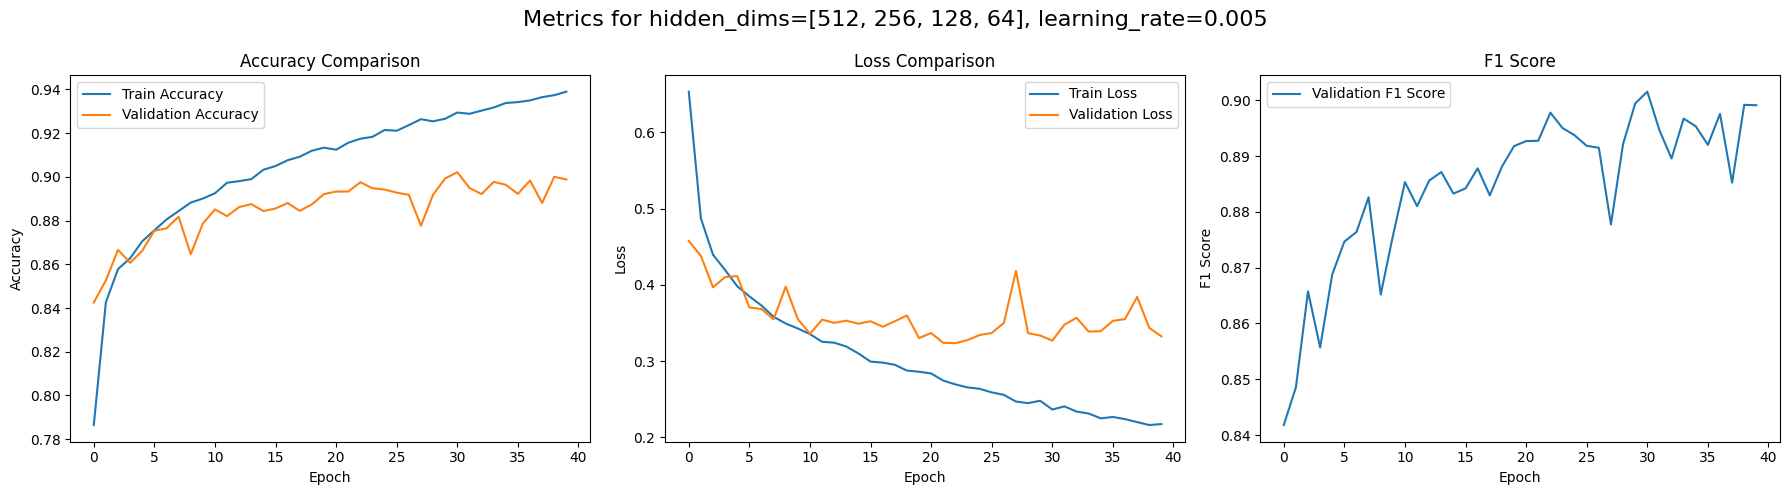

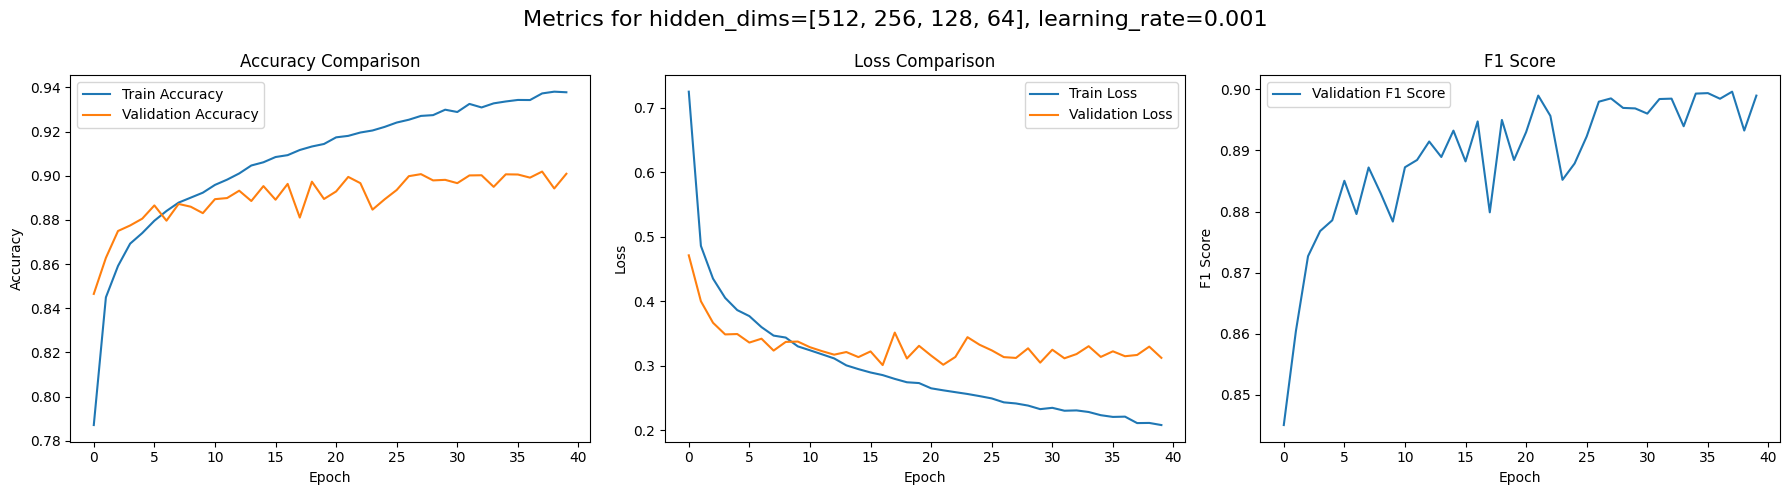

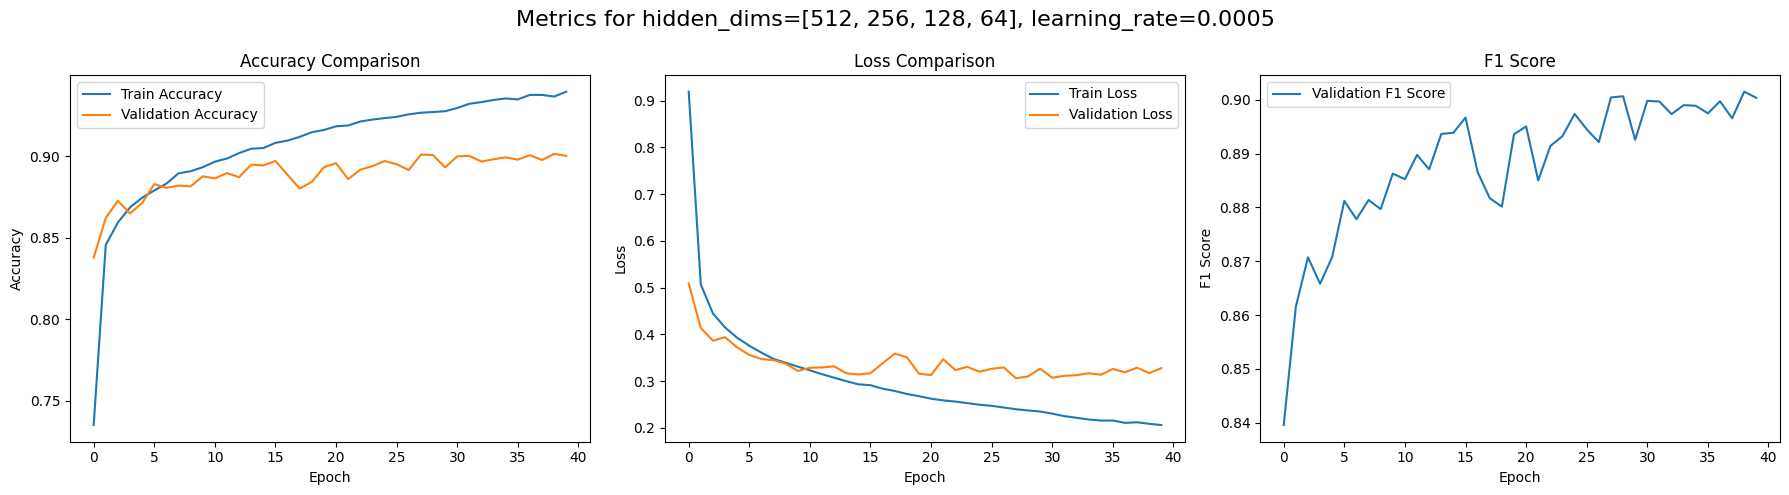

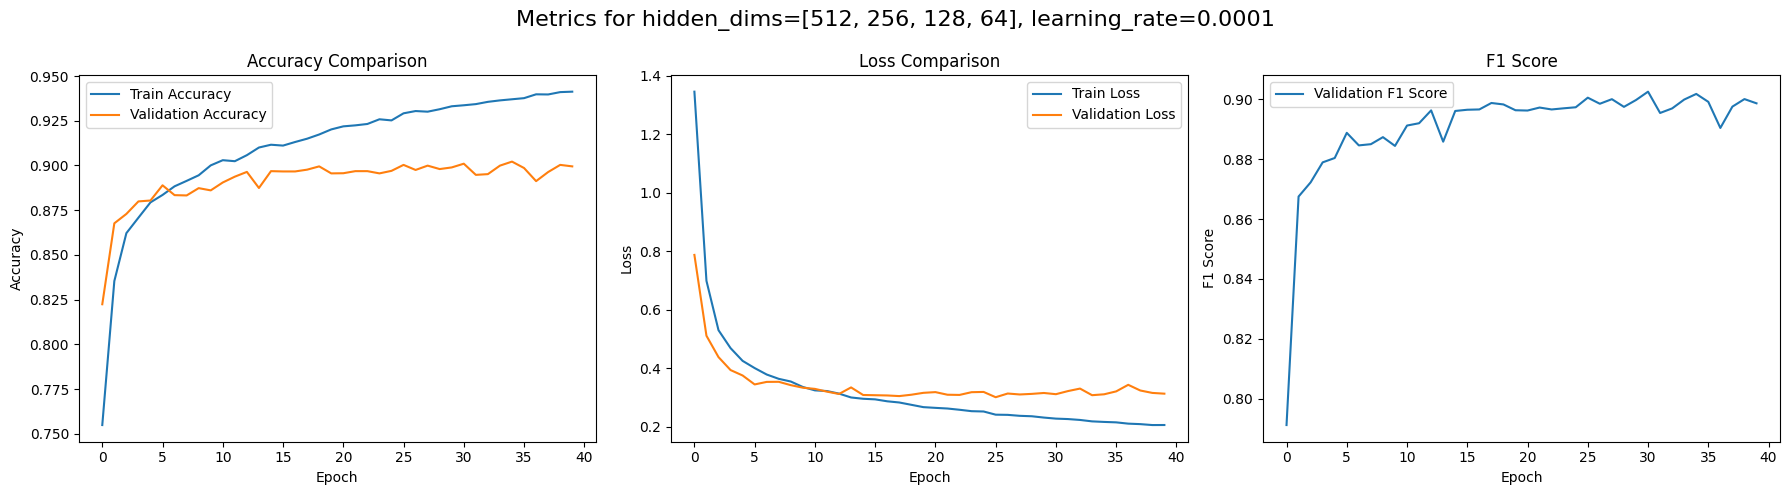

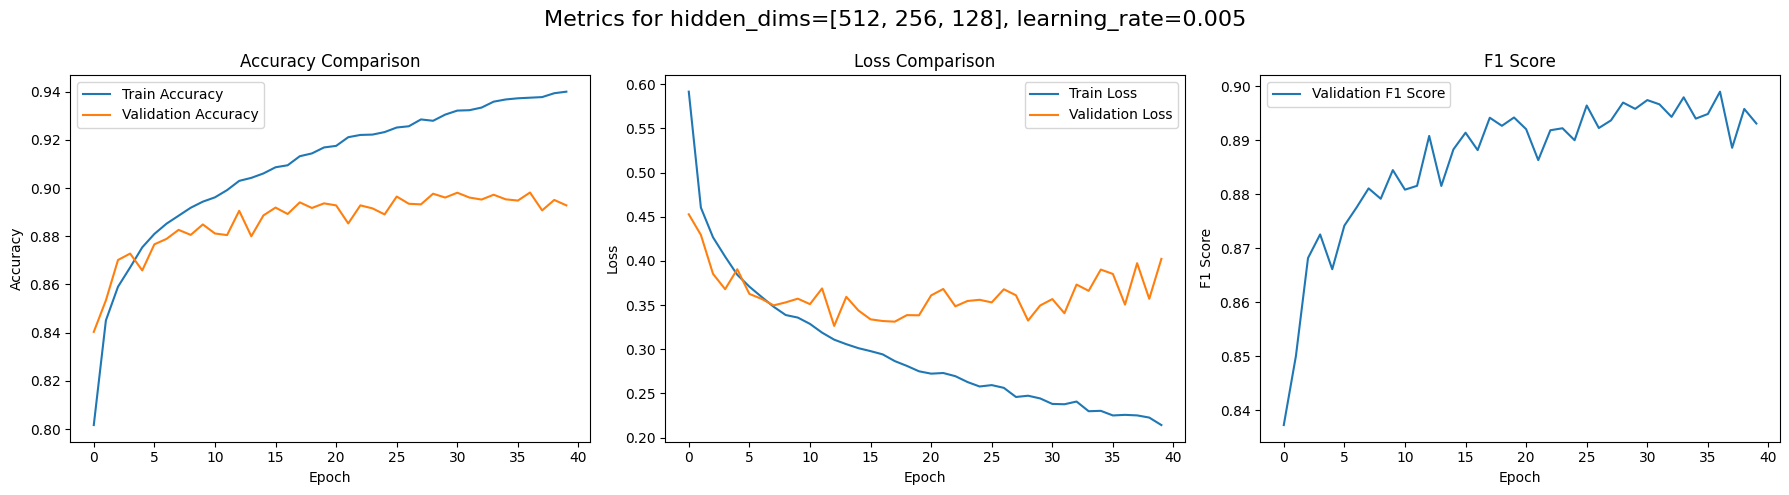

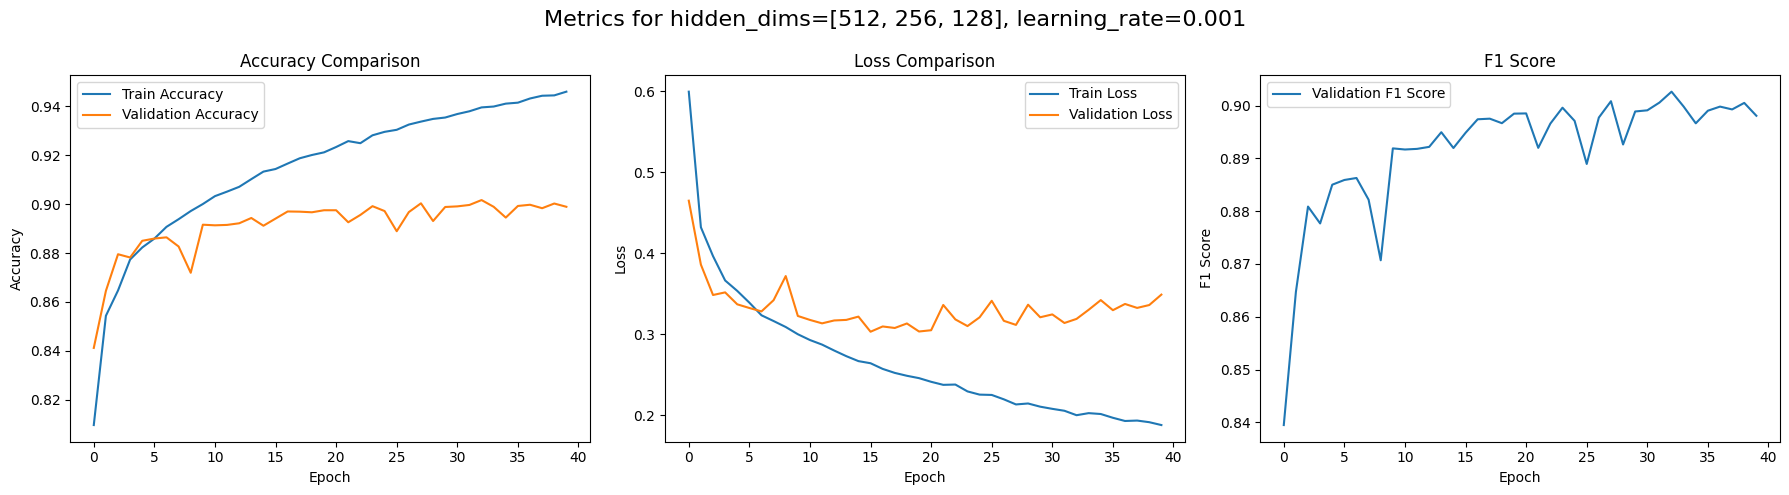

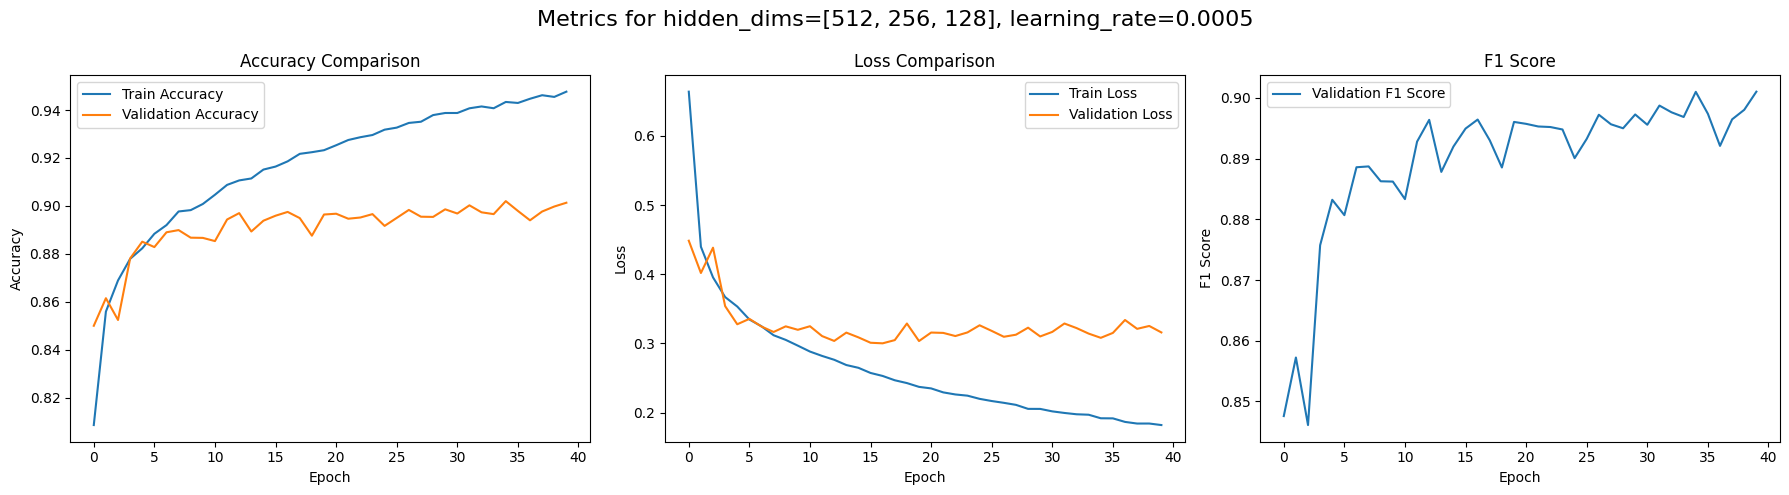

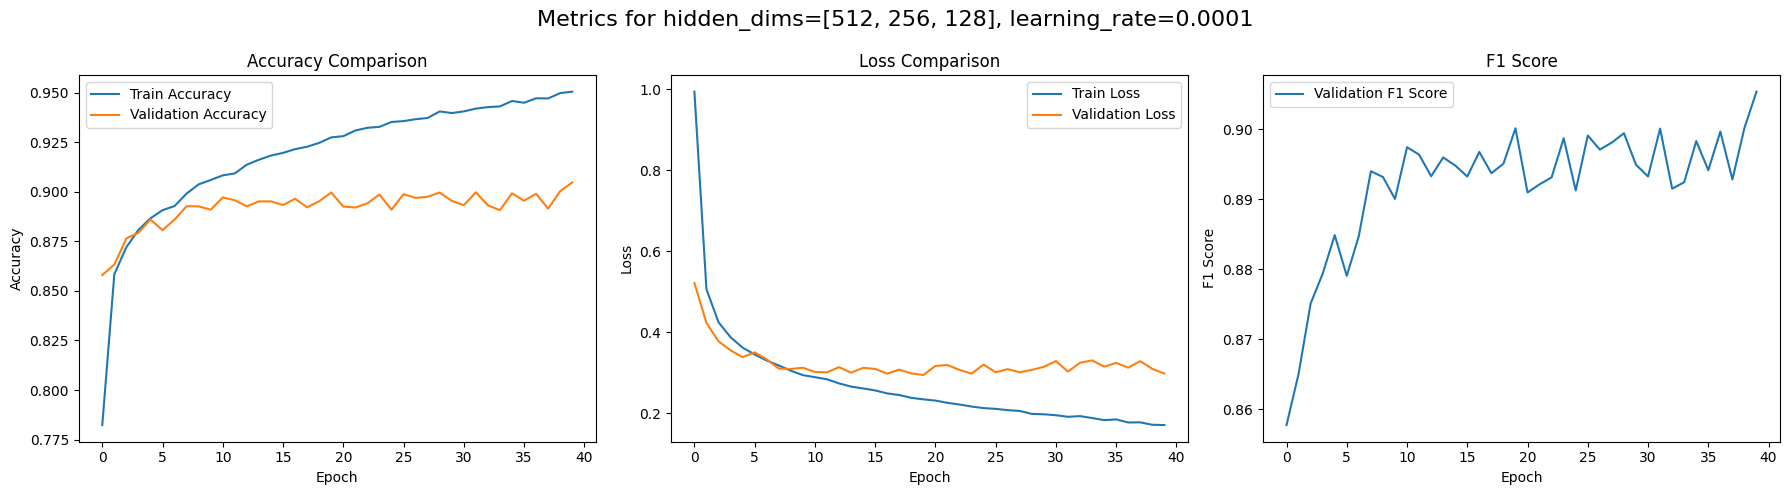

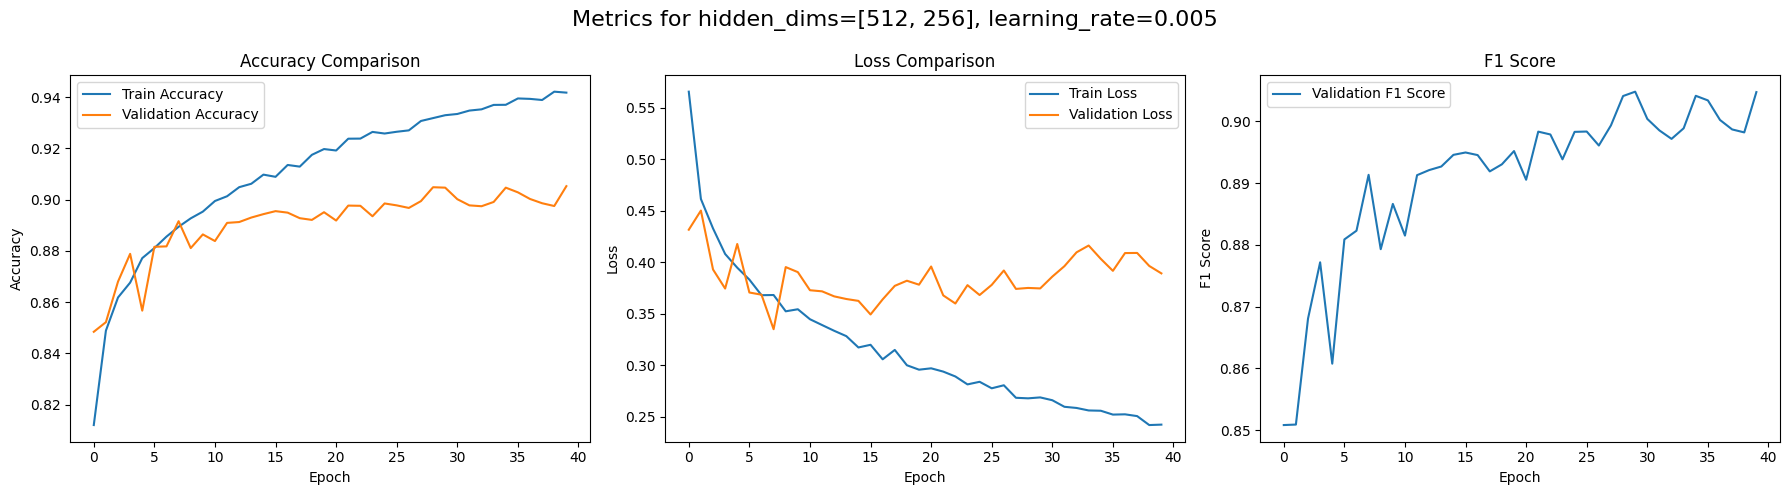

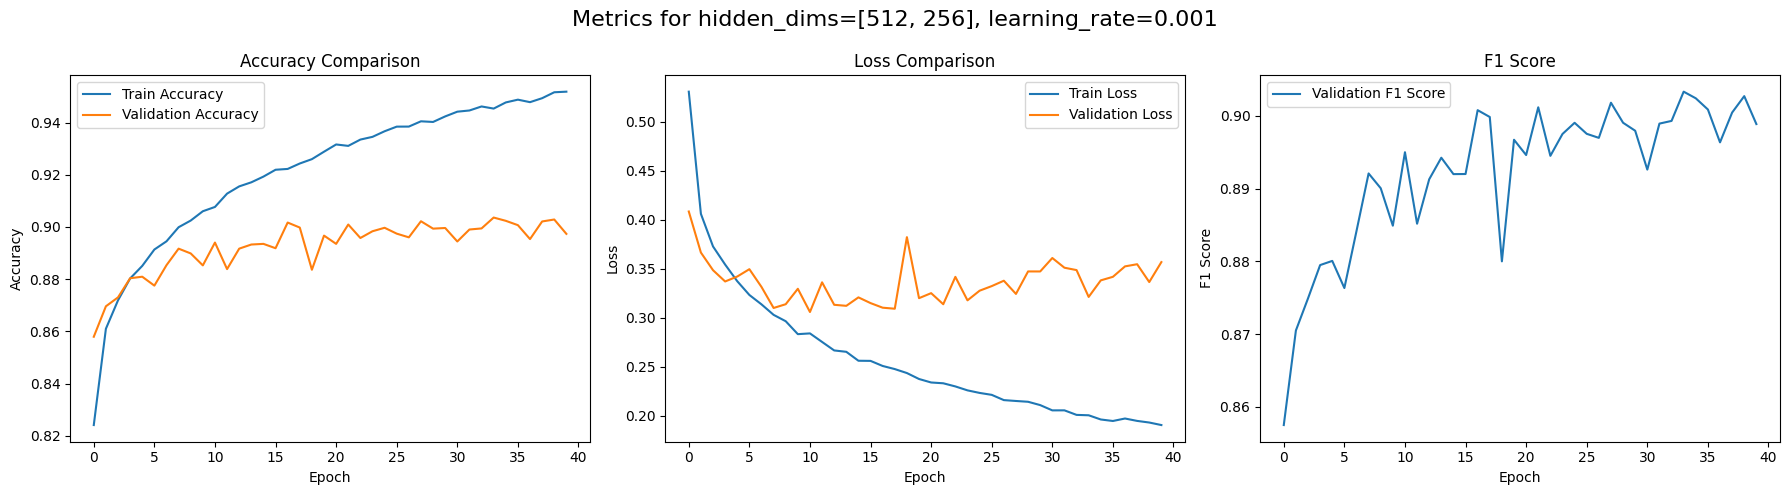

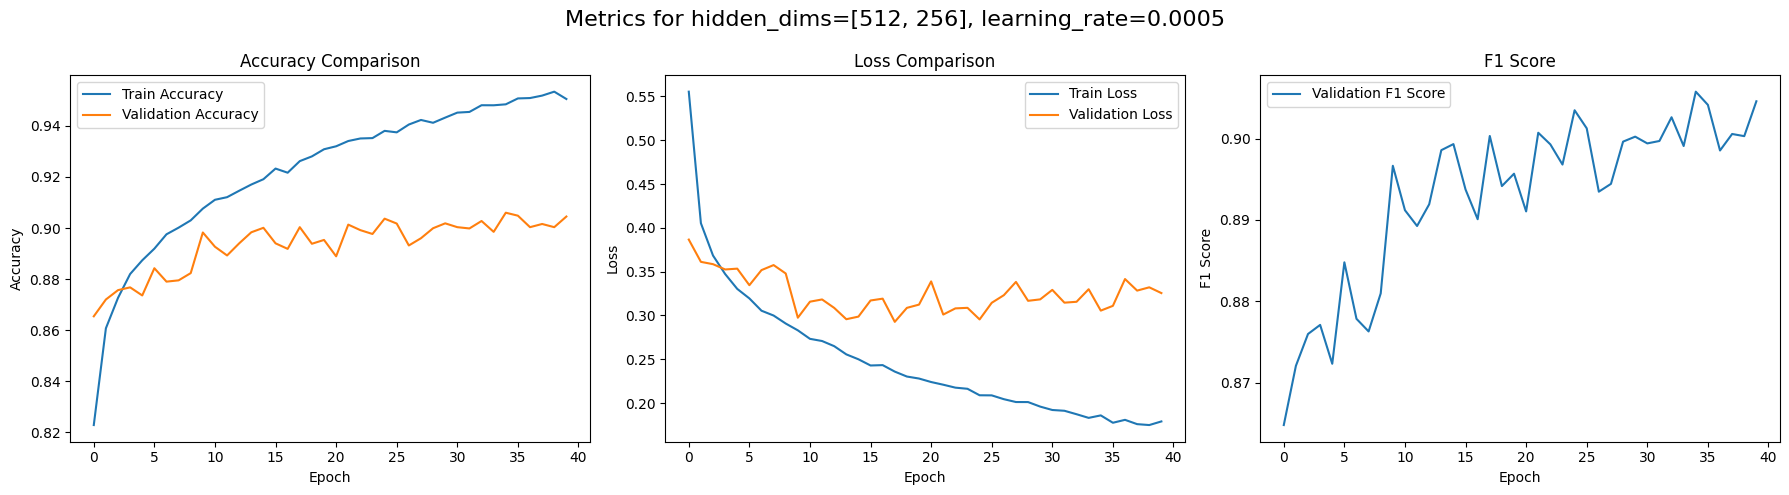

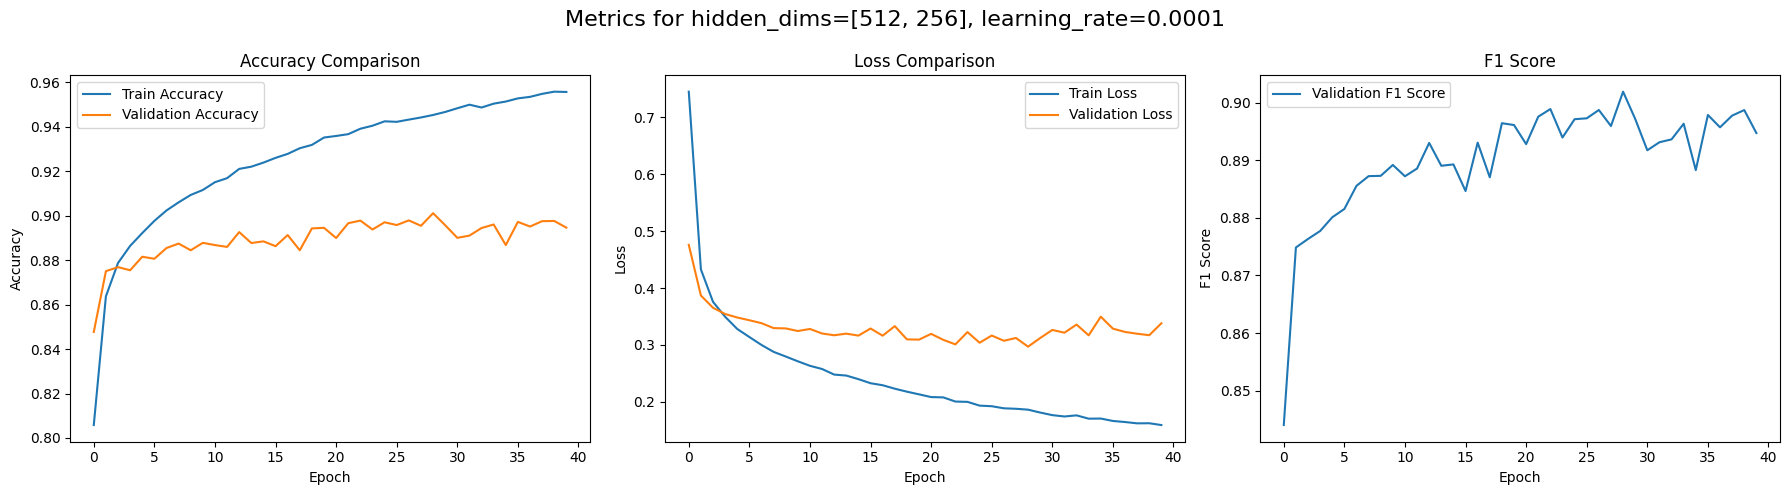

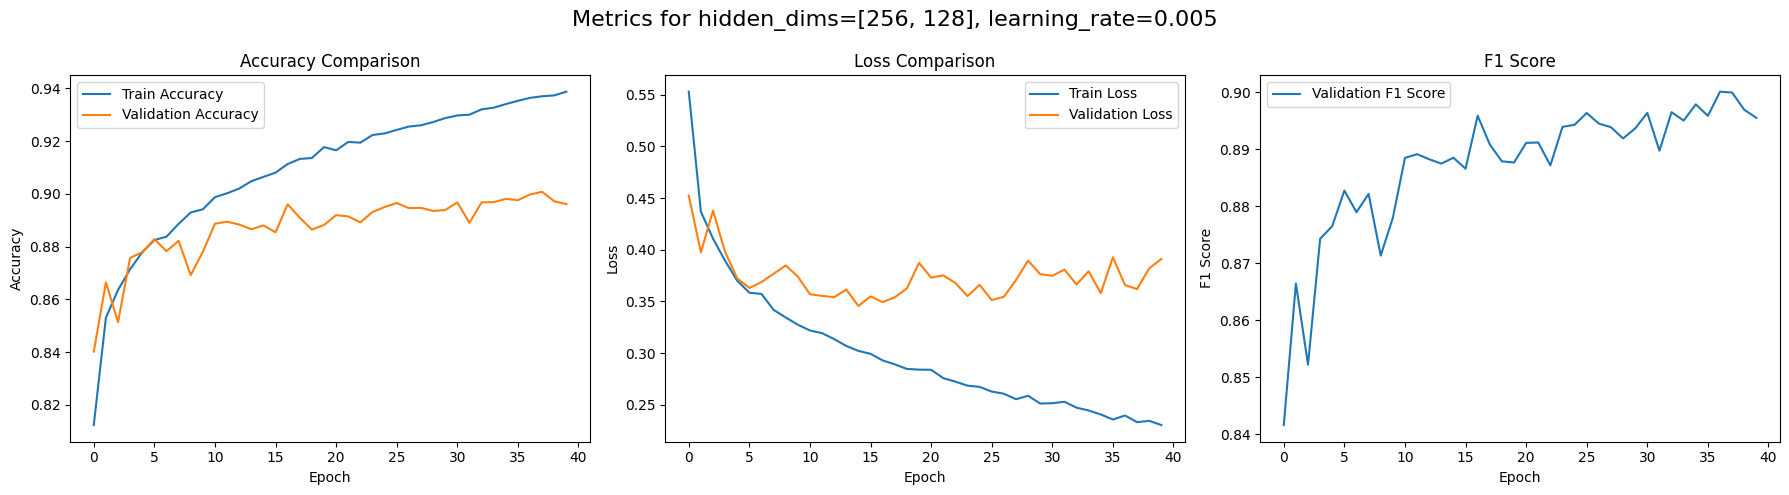

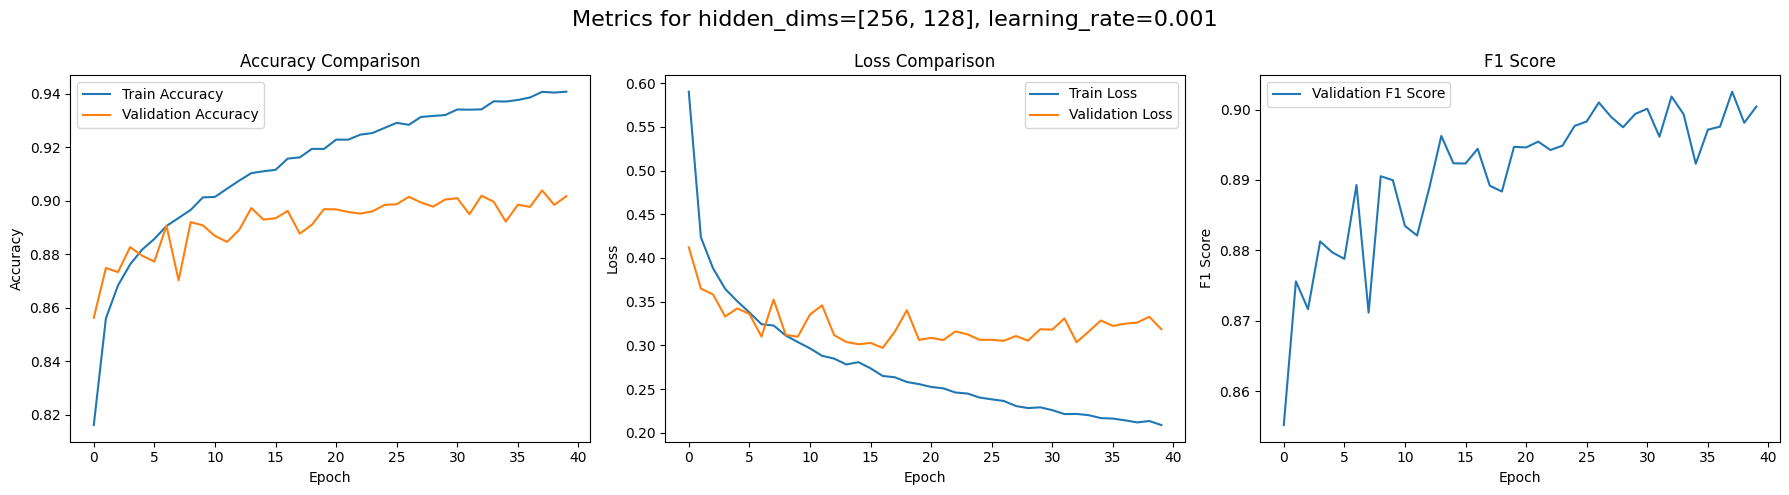

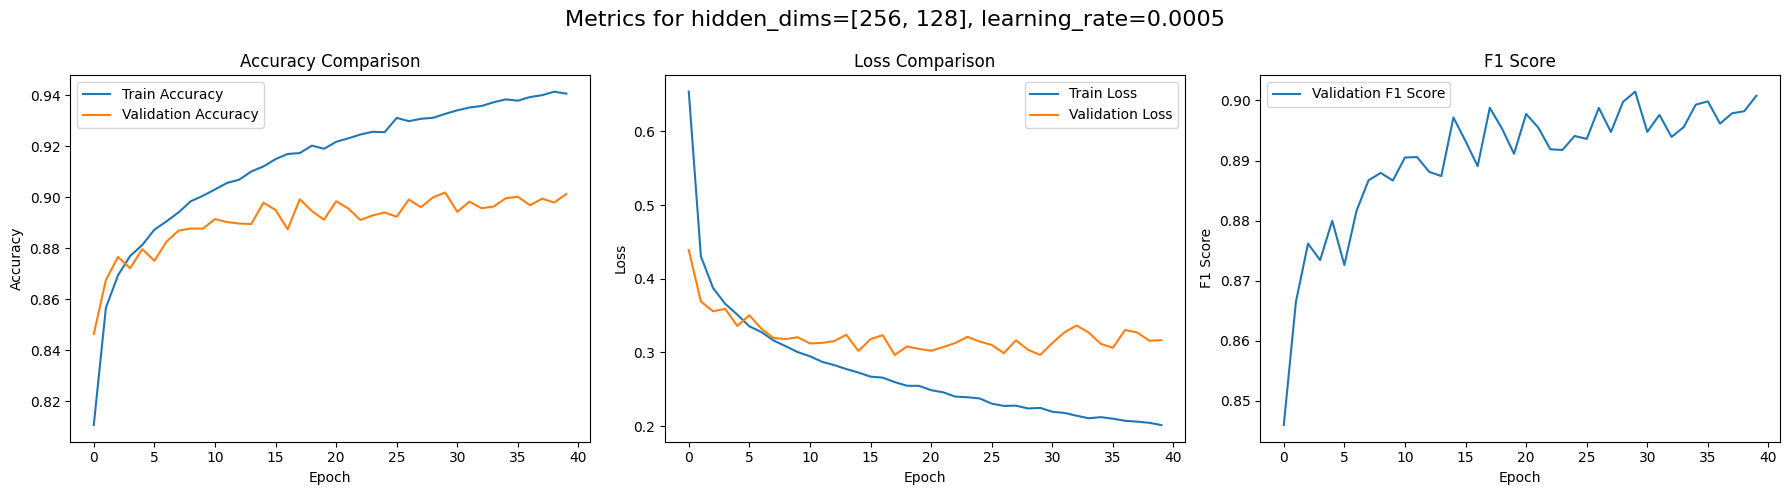

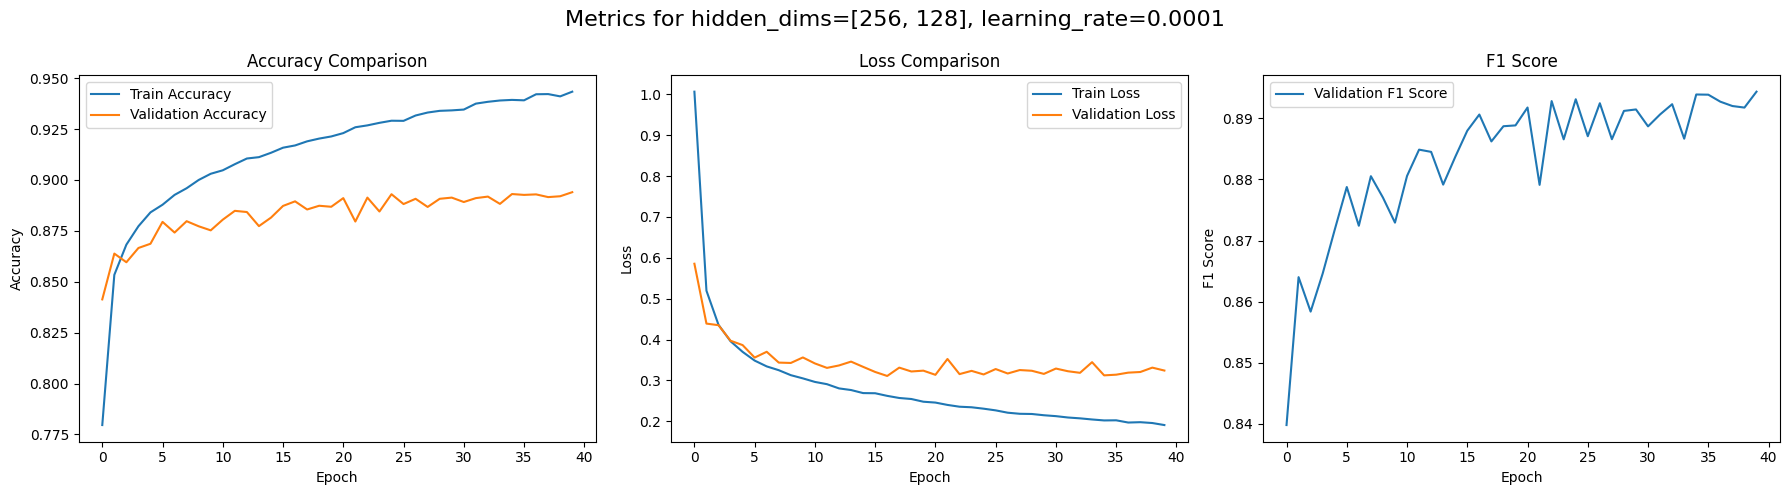

In [14]:
print(histories)
import matplotlib.pyplot as plt
# Function to plot training history
import matplotlib.pyplot as plt

# Function to plot training history
def plot_metrics(history, title="Training and Validation Metrics"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create a 1x3 grid of subplots

    # Plot for Accuracy
    axes[0].plot(history['train_acc'], label='Train Accuracy')
    axes[0].plot(history['val_acc'], label='Validation Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy Comparison')
    axes[0].legend()

    # Plot for Loss
    axes[1].plot(history['train_loss'], label='Train Loss')
    axes[1].plot(history['val_loss'], label='Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Loss Comparison')
    axes[1].legend()

    # Plot for F1 Score
    axes[2].plot(history['val_f1'], label='Validation F1 Score')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_title('F1 Score')
    axes[2].legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the title to fit
    plt.show()


for history in histories:
    plot_metrics(history, title=f"Metrics for hidden_dims={history['model_info'][0]}, learning_rate={history['model_info'][1]}")

In [15]:
# Function to plot training history
def plot_all(histories, title="Training and Validation Metrics",info_model=True):
    fig, axes = plt.subplots(1, 5, figsize=(18, 5))  # Create a 1x3 grid of subplots

    for history in histories:
        if info_model:
            axes[0].plot(history['train_acc'], label=f'{history['model_info'][0]}')
        else:
            axes[0].plot(history['train_acc'], label=f'{history['model_info'][1]}')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Train Accuracy')
    axes[0].set_title('Train Accuracy Comparison')
    axes[0].legend()

    for history in histories:
        if info_model:
            axes[1].plot(history['train_loss'], label=f'{history['model_info'][0]}')
        else:
            axes[1].plot(history['train_loss'], label=f'{history['model_info'][1]}')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Train Loss')
    axes[1].set_title('Train Loss Comparison')
    axes[1].legend()

    for history in histories:
        if info_model:
            axes[2].plot(history['val_acc'], label=f'{history['model_info'][0]}')
        else:
            axes[2].plot(history['val_acc'], label=f'{history['model_info'][1]}')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Validation Accuracy')
    axes[2].set_title('Validation Accuracy Comparison')
    axes[2].legend()

    for history in histories:
        if info_model:
            axes[3].plot(history['val_loss'], label=f'{history['model_info'][0]}')
        else:
            axes[3].plot(history['val_loss'], label=f'{history['model_info'][1]}')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('Validation Loss')
    axes[3].set_title('Validation Loss Comparison')
    axes[3].legend()

    for history in histories:
        if info_model:
            axes[4].plot(history['val_f1'], label=f'{history['model_info'][0]}')
        else:
            axes[4].plot(history['val_f1'], label=f'{history['model_info'][1]}')
    axes[4].set_xlabel('Epoch')
    axes[4].set_ylabel('Validation F1 Score')
    axes[4].set_title('Validation F1 Score Comparison')
    axes[4].legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the title to fit
    plt.show()

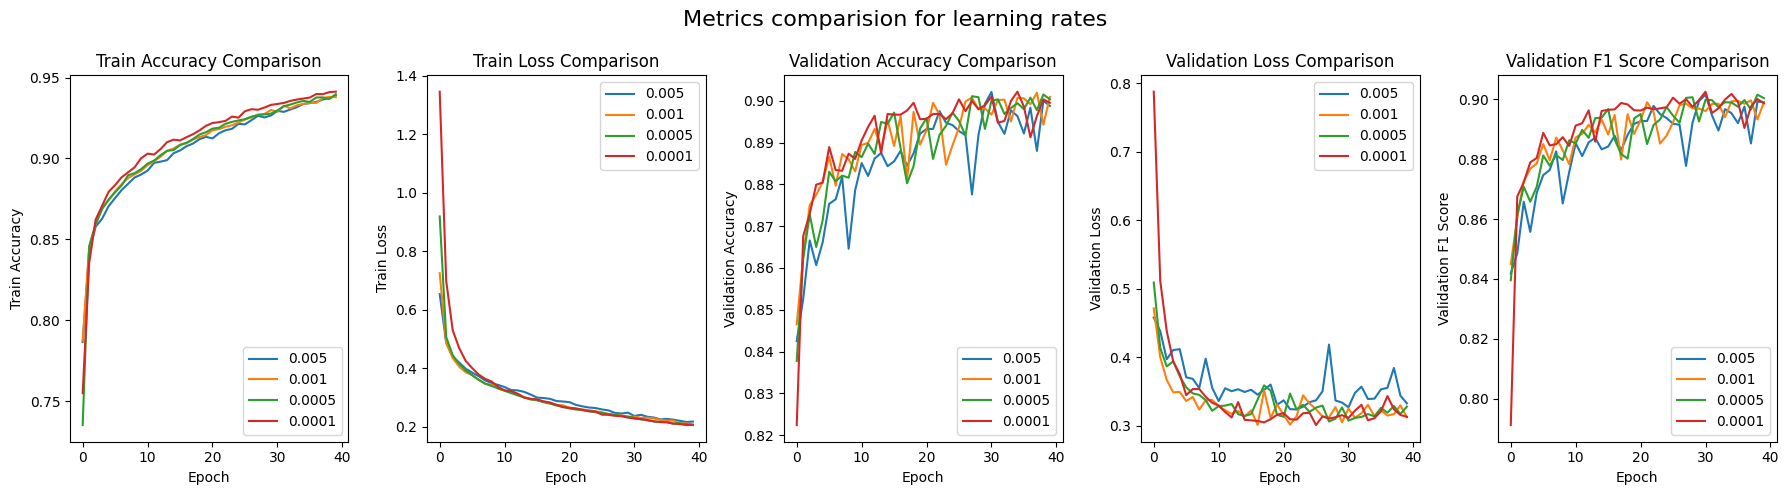

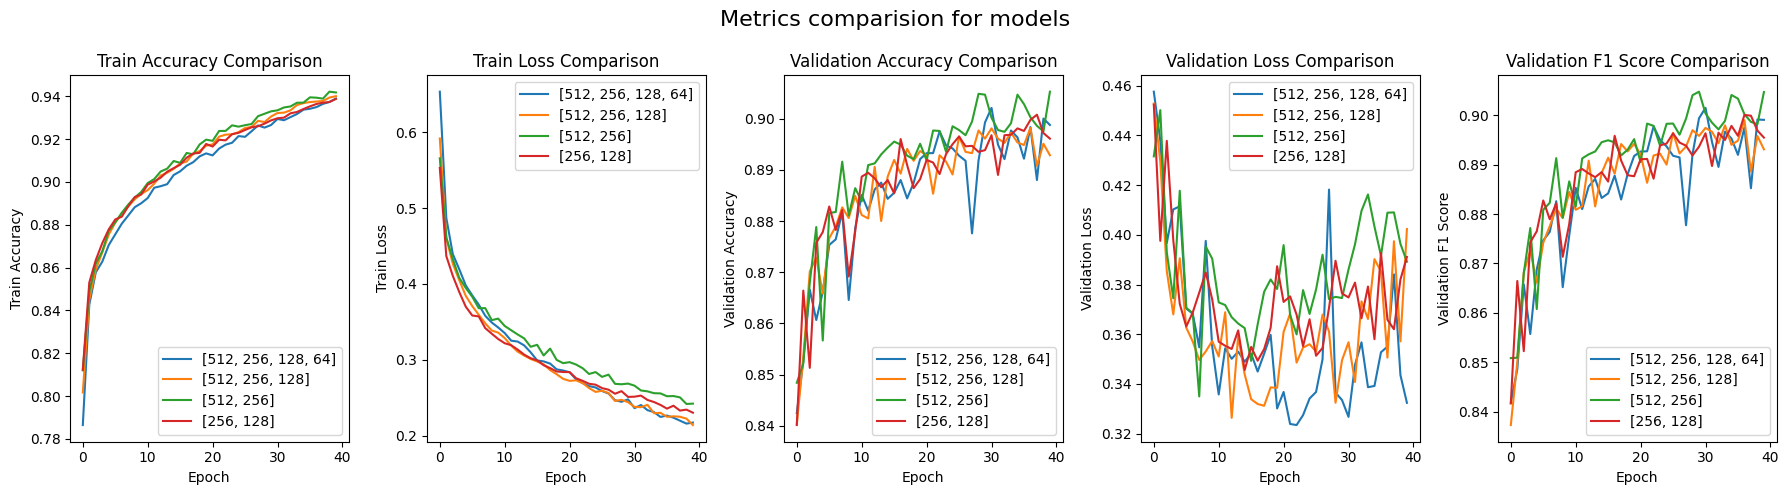

In [16]:
specific_history = histories[:len(learning_rates)]
plot_all(specific_history, title=f"Metrics comparision for learning rates",info_model=False)

specific_history = histories[0::len(learning_rates)] 
plot_all(specific_history, title=f"Metrics comparision for models",info_model=True)

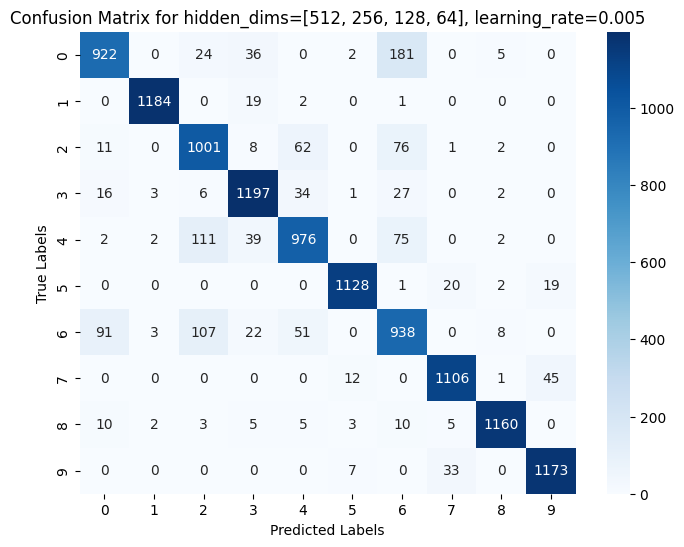

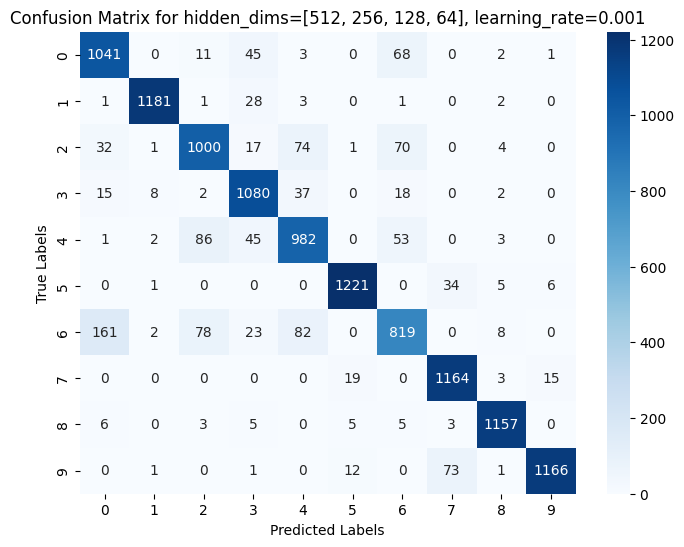

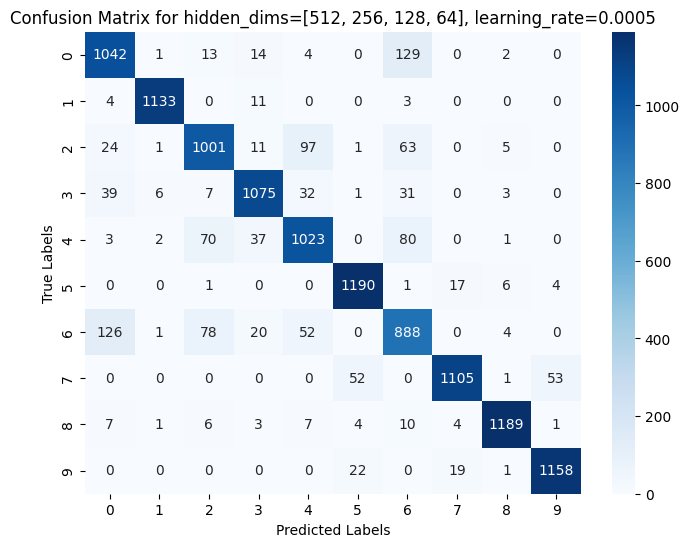

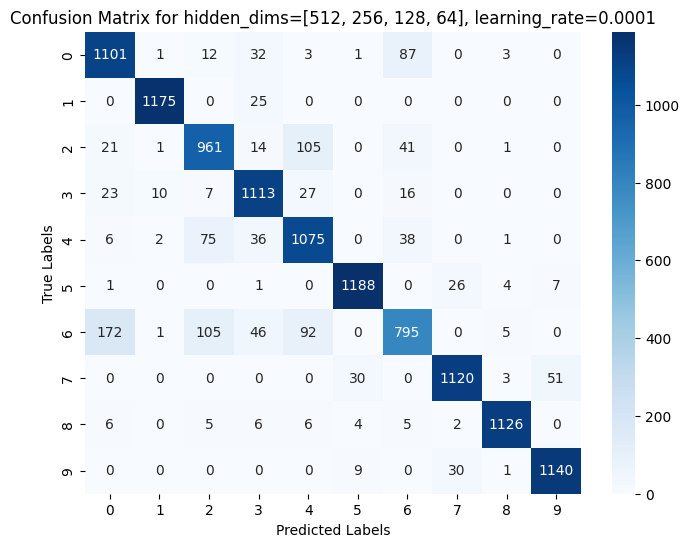

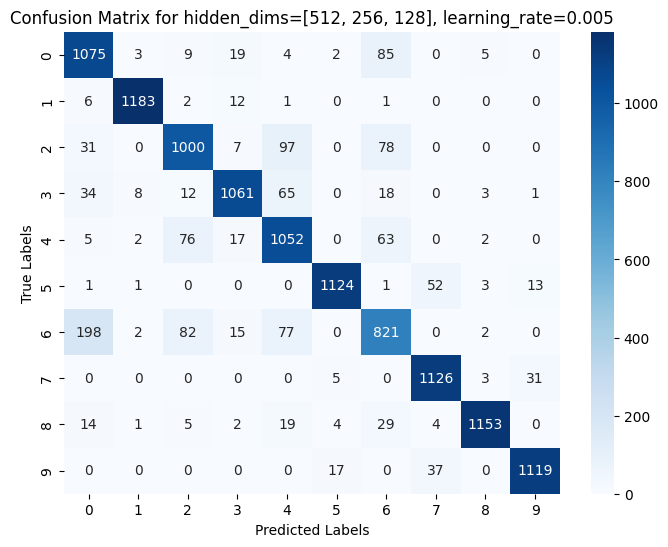

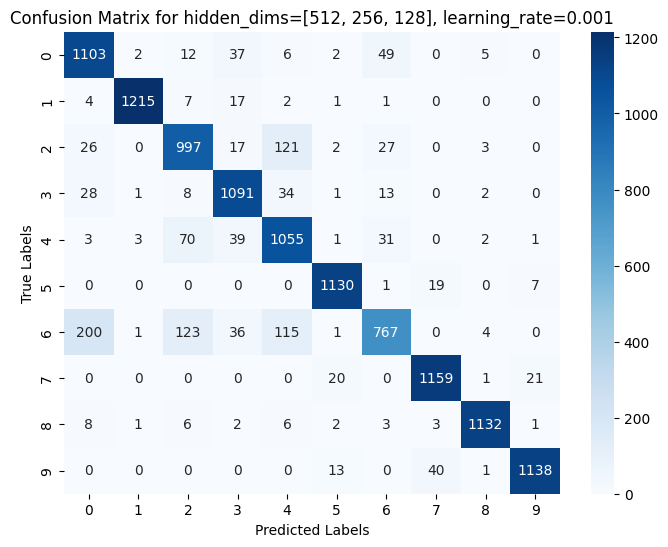

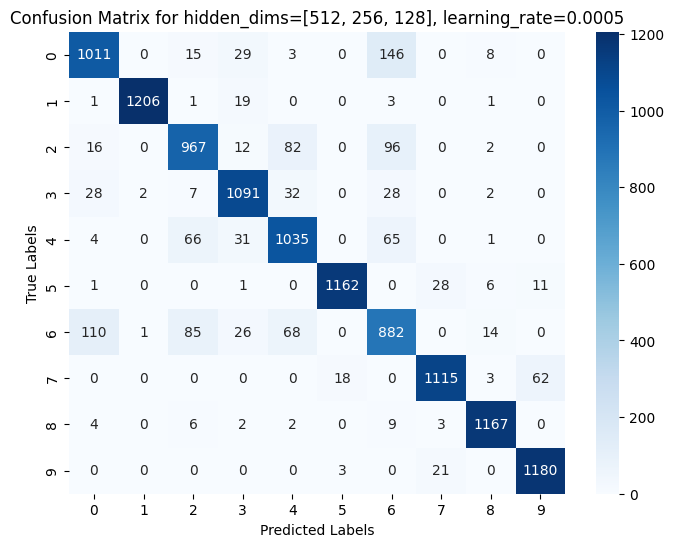

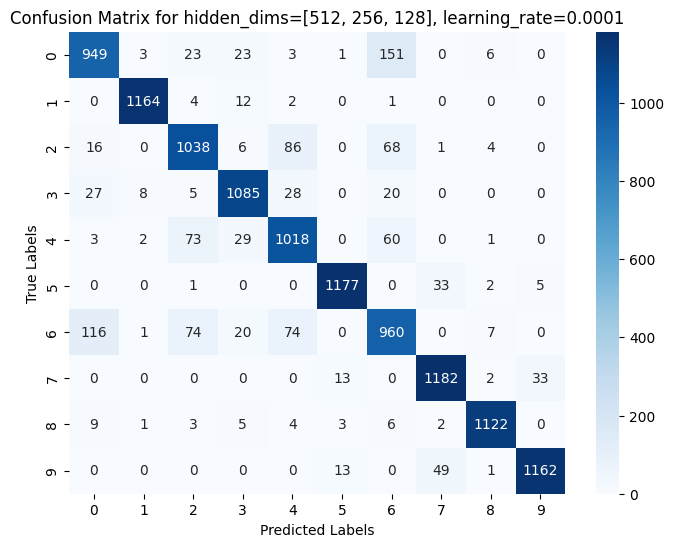

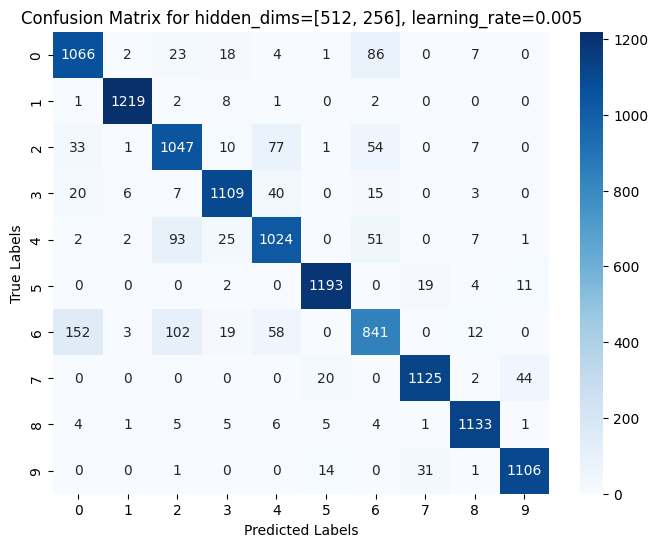

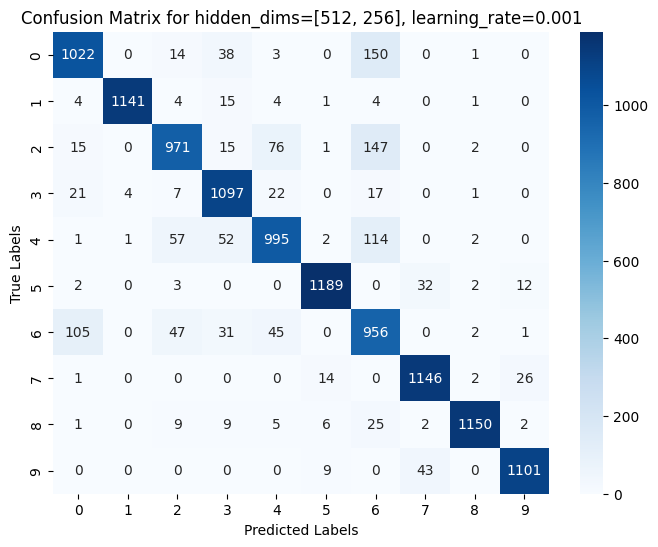

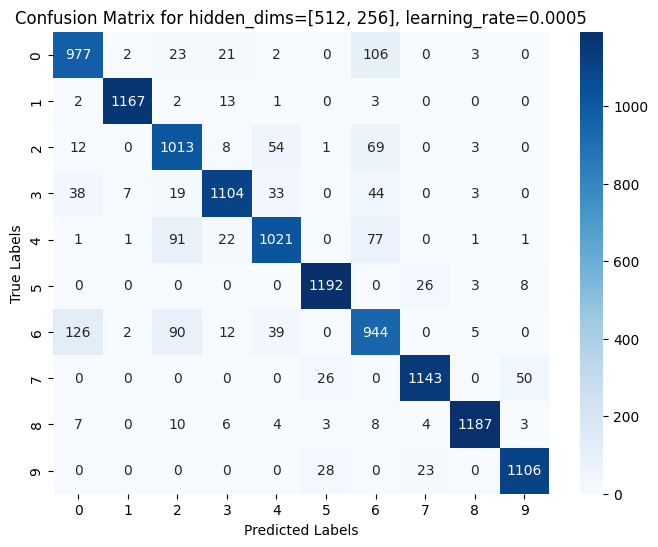

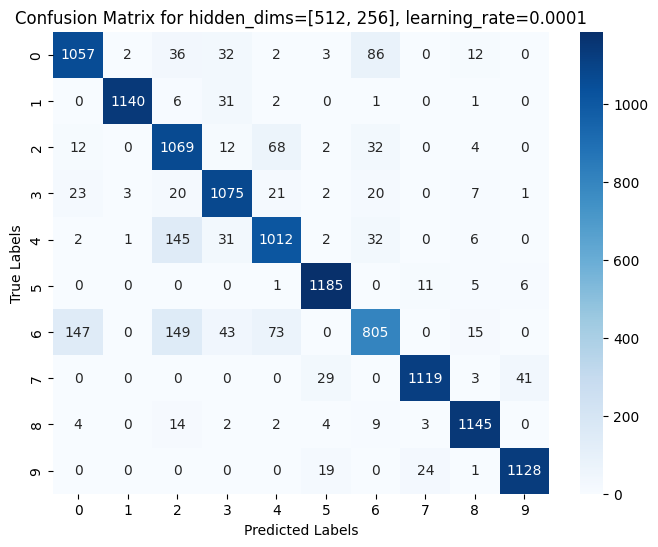

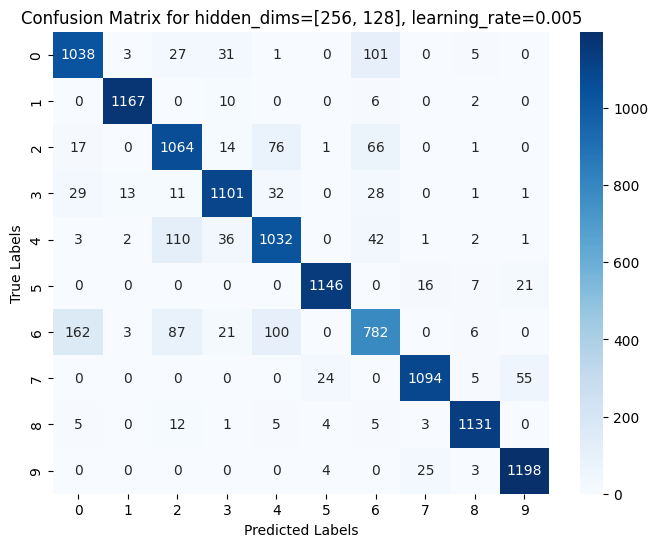

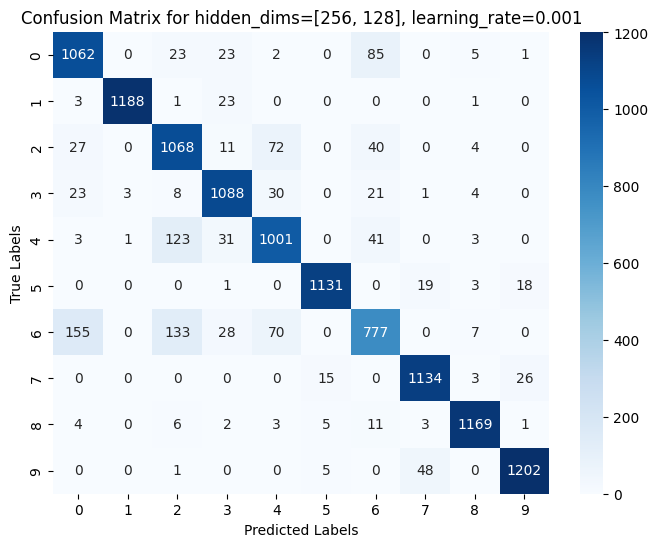

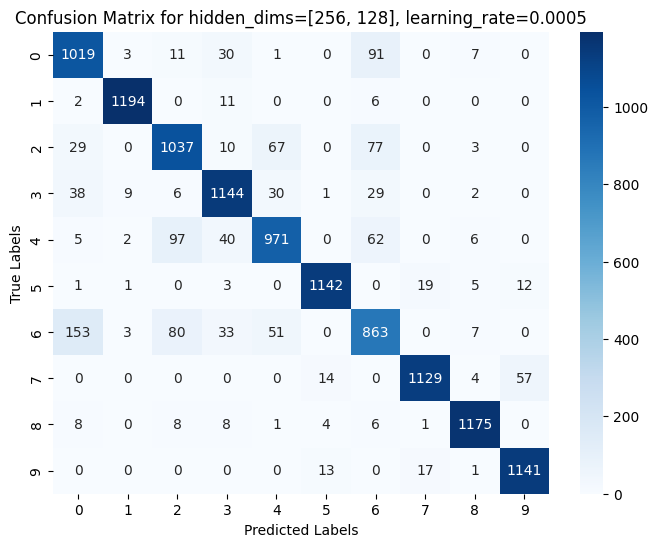

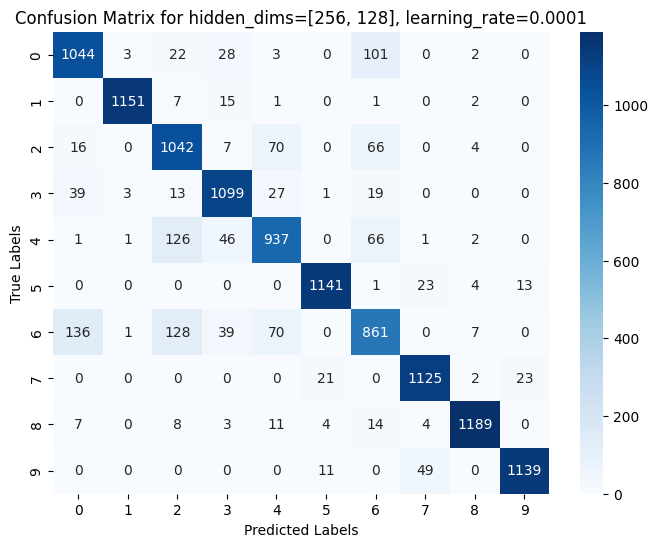

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

for history in histories:
    # Plotting the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(history['confusion_mat'][0], annot=True, fmt="d", cmap="Blues", xticklabels=range(output_dim), yticklabels=range(output_dim))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for hidden_dims={history['model_info'][0]}, learning_rate={history['model_info'][1]}')
    plt.show()

In [18]:
import pandas as pd

# Set global display format to 4 decimal places
pd.options.display.float_format = '{:.4f}'.format

for history in histories:
    print(f"\nfor hidden_dims={history['model_info'][0]}, learning_rate={history['model_info'][1]}:")
    mat = []
    for i in range(len(history['train_loss'])):
        arr = []
        arr.append(i+1)
        arr.append(history['train_loss'][i])
        arr.append(history['train_acc'][i])
        arr.append(history['val_loss'][i])
        arr.append(history['val_acc'][i])
        arr.append(history['val_f1'][i])
        mat.append(arr)
      
    df = pd.DataFrame(mat, columns=['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc','val_f1'])
    print(df.to_string(index=False))



for hidden_dims=[512, 256, 128, 64], learning_rate=0.005:
 epoch  train_loss  train_acc  val_loss  val_acc  val_f1
     1      0.6533     0.7865    0.4576   0.8425  0.8418
     2      0.4871     0.8427    0.4379   0.8527  0.8486
     3      0.4394     0.8578    0.3967   0.8666  0.8658
     4      0.4194     0.8628    0.4102   0.8607  0.8557
     5      0.3981     0.8705    0.4115   0.8662  0.8688
     6      0.3849     0.8755    0.3703   0.8753  0.8747
     7      0.3728     0.8805    0.3683   0.8764  0.8764
     8      0.3581     0.8843    0.3548   0.8818  0.8826
     9      0.3493     0.8882    0.3976   0.8646  0.8652
    10      0.3427     0.8900    0.3551   0.8786  0.8756
    11      0.3353     0.8925    0.3358   0.8851  0.8853
    12      0.3253     0.8973    0.3544   0.8820  0.8810
    13      0.3241     0.8980    0.3501   0.8862  0.8856
    14      0.3191     0.8989    0.3530   0.8875  0.8871
    15      0.3100     0.9032    0.3490   0.8843  0.8833
    16      0.2993     0.9049

Find The Best Model

In [19]:
max_f1_score = 0
best_history = None

for history in histories:
    print(f'for hidden_dims={history['model_info'][0]}, learning_rate={history['model_info'][1]} f1 score: {history['val_f1'][num_epochs-1]:.4f}')
    if history['val_f1'][num_epochs-1] > max_f1_score:
        max_f1_score = history['val_f1'][num_epochs-1]
        best_history = history

print("\nbest model:")
print(f'for hidden_dims={best_history['model_info'][0]}, learning_rate={best_history['model_info'][1]} f1 score: {best_history['val_f1'][num_epochs-1]:.4f} validation_accuracy: {best_history['val_acc'][num_epochs-1]:.4f}')

for hidden_dims=[512, 256, 128, 64], learning_rate=0.005 f1 score: 0.8991
for hidden_dims=[512, 256, 128, 64], learning_rate=0.001 f1 score: 0.8990
for hidden_dims=[512, 256, 128, 64], learning_rate=0.0005 f1 score: 0.9004
for hidden_dims=[512, 256, 128, 64], learning_rate=0.0001 f1 score: 0.8986
for hidden_dims=[512, 256, 128], learning_rate=0.005 f1 score: 0.8931
for hidden_dims=[512, 256, 128], learning_rate=0.001 f1 score: 0.8981
for hidden_dims=[512, 256, 128], learning_rate=0.0005 f1 score: 0.9010
for hidden_dims=[512, 256, 128], learning_rate=0.0001 f1 score: 0.9053
for hidden_dims=[512, 256], learning_rate=0.005 f1 score: 0.9047
for hidden_dims=[512, 256], learning_rate=0.001 f1 score: 0.8989
for hidden_dims=[512, 256], learning_rate=0.0005 f1 score: 0.9046
for hidden_dims=[512, 256], learning_rate=0.0001 f1 score: 0.8947
for hidden_dims=[256, 128], learning_rate=0.005 f1 score: 0.8955
for hidden_dims=[256, 128], learning_rate=0.001 f1 score: 0.9004
for hidden_dims=[256, 128], 

Training The Best Model On The Whole Training Data

In [20]:
history_final = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': [], 'model_info':[],'confusion_mat':[]}
history_final['model_info'].append(best_history['model_info'][0])
history_final['model_info'].append(best_history['model_info'][1])

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model_current = Model(input_dim,best_history['model_info'][0],output_dim,dropout_rate,best_history['model_info'][1],batch_size,num_epochs,data_split_ratio)
best_model = model_current.fit(train_loader_full,history_final,train=False)

40


100%|██████████| 938/938 [00:38<00:00, 24.13it/s]


total:  60000 correct:  47295
Epoch [1/40], Loss: 0.9194, Accuracy: 0.7883


100%|██████████| 938/938 [00:38<00:00, 24.31it/s]


total:  60000 correct:  51621
Epoch [2/40], Loss: 0.4789, Accuracy: 0.8603


100%|██████████| 938/938 [00:46<00:00, 19.99it/s]


total:  60000 correct:  52436
Epoch [3/40], Loss: 0.4086, Accuracy: 0.8739


100%|██████████| 938/938 [00:47<00:00, 19.82it/s]


total:  60000 correct:  52878
Epoch [4/40], Loss: 0.3755, Accuracy: 0.8813


100%|██████████| 938/938 [00:46<00:00, 20.35it/s]


total:  60000 correct:  53242
Epoch [5/40], Loss: 0.3506, Accuracy: 0.8874


100%|██████████| 938/938 [00:43<00:00, 21.52it/s]


total:  60000 correct:  53473
Epoch [6/40], Loss: 0.3347, Accuracy: 0.8912


100%|██████████| 938/938 [00:43<00:00, 21.74it/s]


total:  60000 correct:  53832
Epoch [7/40], Loss: 0.3206, Accuracy: 0.8972


100%|██████████| 938/938 [00:46<00:00, 20.28it/s]


total:  60000 correct:  53999
Epoch [8/40], Loss: 0.3090, Accuracy: 0.9000


100%|██████████| 938/938 [00:45<00:00, 20.39it/s]


total:  60000 correct:  54158
Epoch [9/40], Loss: 0.2997, Accuracy: 0.9026


100%|██████████| 938/938 [00:51<00:00, 18.24it/s]


total:  60000 correct:  54419
Epoch [10/40], Loss: 0.2915, Accuracy: 0.9070


100%|██████████| 938/938 [00:53<00:00, 17.56it/s]


total:  60000 correct:  54597
Epoch [11/40], Loss: 0.2788, Accuracy: 0.9100


100%|██████████| 938/938 [00:49<00:00, 18.99it/s]


total:  60000 correct:  54692
Epoch [12/40], Loss: 0.2749, Accuracy: 0.9115


100%|██████████| 938/938 [00:56<00:00, 16.54it/s]


total:  60000 correct:  54953
Epoch [13/40], Loss: 0.2660, Accuracy: 0.9159


100%|██████████| 938/938 [01:00<00:00, 15.55it/s]


total:  60000 correct:  55001
Epoch [14/40], Loss: 0.2601, Accuracy: 0.9167


100%|██████████| 938/938 [00:56<00:00, 16.63it/s]


total:  60000 correct:  55094
Epoch [15/40], Loss: 0.2566, Accuracy: 0.9182


100%|██████████| 938/938 [00:56<00:00, 16.63it/s]


total:  60000 correct:  55185
Epoch [16/40], Loss: 0.2504, Accuracy: 0.9197


100%|██████████| 938/938 [00:57<00:00, 16.27it/s]


total:  60000 correct:  55236
Epoch [17/40], Loss: 0.2461, Accuracy: 0.9206


100%|██████████| 938/938 [00:56<00:00, 16.57it/s]


total:  60000 correct:  55412
Epoch [18/40], Loss: 0.2407, Accuracy: 0.9235


100%|██████████| 938/938 [00:58<00:00, 15.96it/s]


total:  60000 correct:  55503
Epoch [19/40], Loss: 0.2364, Accuracy: 0.9251


100%|██████████| 938/938 [00:58<00:00, 16.02it/s]


total:  60000 correct:  55630
Epoch [20/40], Loss: 0.2331, Accuracy: 0.9272


100%|██████████| 938/938 [00:59<00:00, 15.69it/s]


total:  60000 correct:  55686
Epoch [21/40], Loss: 0.2294, Accuracy: 0.9281


100%|██████████| 938/938 [01:00<00:00, 15.49it/s]


total:  60000 correct:  55807
Epoch [22/40], Loss: 0.2230, Accuracy: 0.9301


100%|██████████| 938/938 [00:58<00:00, 15.91it/s]


total:  60000 correct:  55988
Epoch [23/40], Loss: 0.2165, Accuracy: 0.9331


100%|██████████| 938/938 [01:04<00:00, 14.62it/s]


total:  60000 correct:  55961
Epoch [24/40], Loss: 0.2154, Accuracy: 0.9327


100%|██████████| 938/938 [01:06<00:00, 14.04it/s]


total:  60000 correct:  56054
Epoch [25/40], Loss: 0.2122, Accuracy: 0.9342


100%|██████████| 938/938 [01:03<00:00, 14.77it/s]


total:  60000 correct:  56052
Epoch [26/40], Loss: 0.2108, Accuracy: 0.9342


100%|██████████| 938/938 [01:03<00:00, 14.80it/s]


total:  60000 correct:  56296
Epoch [27/40], Loss: 0.2040, Accuracy: 0.9383


100%|██████████| 938/938 [00:57<00:00, 16.20it/s]


total:  60000 correct:  56220
Epoch [28/40], Loss: 0.2047, Accuracy: 0.9370


100%|██████████| 938/938 [01:08<00:00, 13.70it/s]


total:  60000 correct:  56274
Epoch [29/40], Loss: 0.2002, Accuracy: 0.9379


100%|██████████| 938/938 [00:59<00:00, 15.81it/s]


total:  60000 correct:  56329
Epoch [30/40], Loss: 0.1978, Accuracy: 0.9388


100%|██████████| 938/938 [01:01<00:00, 15.17it/s]


total:  60000 correct:  56432
Epoch [31/40], Loss: 0.1944, Accuracy: 0.9405


100%|██████████| 938/938 [00:50<00:00, 18.61it/s]


total:  60000 correct:  56473
Epoch [32/40], Loss: 0.1935, Accuracy: 0.9412


100%|██████████| 938/938 [00:46<00:00, 20.20it/s]


total:  60000 correct:  56559
Epoch [33/40], Loss: 0.1894, Accuracy: 0.9426


100%|██████████| 938/938 [00:56<00:00, 16.66it/s]


total:  60000 correct:  56663
Epoch [34/40], Loss: 0.1843, Accuracy: 0.9444


100%|██████████| 938/938 [00:45<00:00, 20.81it/s]


total:  60000 correct:  56680
Epoch [35/40], Loss: 0.1841, Accuracy: 0.9447


100%|██████████| 938/938 [00:47<00:00, 19.69it/s]


total:  60000 correct:  56738
Epoch [36/40], Loss: 0.1825, Accuracy: 0.9456


100%|██████████| 938/938 [01:01<00:00, 15.29it/s]


total:  60000 correct:  56750
Epoch [37/40], Loss: 0.1807, Accuracy: 0.9458


100%|██████████| 938/938 [00:45<00:00, 20.70it/s]


total:  60000 correct:  56805
Epoch [38/40], Loss: 0.1796, Accuracy: 0.9467


100%|██████████| 938/938 [00:46<00:00, 20.18it/s]


total:  60000 correct:  56884
Epoch [39/40], Loss: 0.1751, Accuracy: 0.9481


100%|██████████| 938/938 [00:40<00:00, 23.05it/s]


total:  60000 correct:  56866
Epoch [40/40], Loss: 0.1738, Accuracy: 0.9478


Loading Test Data

In [21]:
# DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Test The Best Model

In [22]:
Test(best_model,test_loader)

Confusion Matrix:
[[900   2  13  29   3   0  48   0   5   0]
 [  5 968   1  20   3   0   2   0   1   0]
 [ 20   0 808  14  98   0  58   0   2   0]
 [ 30   6  11 911  25   1  12   0   4   0]
 [  2   2  69  37 846   0  42   0   2   0]
 [  0   0   0   0   1 965   0  19   4  11]
 [172   4  77  31  97   1 610   0   8   0]
 [  0   0   0   0   0  17   0 942   0  41]
 [  4   1   6   4   4   2  14   7 958   0]
 [  0   0   0   0   0   9   1  27   0 963]]
Test Accuracy: 88.71%


Save The Best Model

In [ ]:
import pickle

# Save the trained model to a file
with open('1905114.pkl', 'wb') as file:
    pickle.dump(best_model, file)
print("Model saved successfully!")

Model saved successfully!


Load The Best Model

In [19]:
# Load the model from the file
import pickle
with open('1905114.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully!")

Model loaded successfully!


Test The Loaded Model

In [20]:
Test(loaded_model,test_loader)

Confusion Matrix:
[[903   0  11  29   4   4  43   1   5   0]
 [  4 967   3  16   4   0   3   0   3   0]
 [ 20   0 806  17  98   0  56   0   3   0]
 [ 30  11   8 909  28   0  11   0   3   0]
 [  2   0  71  39 843   1  38   0   6   0]
 [  1   0   0   1   0 967   1  13   4  13]
 [180   2  73  32 101   0 607   0   5   0]
 [  1   0   0   1   0  22   2 931   0  43]
 [  7   0   6   5   4   1   8   5 964   0]
 [  0   0   0   0   0  14   1  25   0 960]]
Test Accuracy: 88.57%


## Online

In [36]:
with open('a1.pkl', 'rb') as a1:
    test_dataset = pickle.load(a1)

In [22]:
from torchvision import datasets, transforms

# Define transformation
transform = transforms.ToTensor()

# Load the training dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Load the test dataset separately
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

In [ ]:
import tqdm
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix

def Test2(model,data):
    all_predictions = []
    all_labels = []
    for images, labels in data:
        # Flatten the images
        images = (images.view(images.size(0), -1).numpy()+1)/2
        #print(f"Minimum value: {images.min().item()}")
        #print(f"Maximum value: {images.max().item()}")
        

        # Forward pass through the loaded model
        outputs = model.forward(images)

        # Get the predicted class (highest probability)
        predictions = np.argmax(outputs, axis=1)

        # Collect predictions and true labels for accuracy computation
        all_predictions.extend(predictions)
        all_labels.extend(labels.numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Step 4: Evaluate the model
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [42]:
from torch.utils.data import DataLoader, random_split
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
print(test_loader)

In [44]:
Test2(loaded_model,test_loader)

Confusion Matrix:
[[252  15  30  43  29  16 145  16  69  39]
 [ 45 322  16  64   1   6   8   9   4  20]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [ 24  17  66  35  25 196  58 144  15 273]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [ 61  17 128 136 254 254 209  85 435  30]
 [  0   0   0   0   0   0   0   0   0   0]]
Test Accuracy: 33.37%
